# DESCRIPTIVE STATISTICS:

### This code will begin similar to the one for the main model, but will not feature a train test split or a model building; wrangling will continue until one step before model building and then will focus on the database's descriptive statistics
### These steps as they are here present would induce data leakage if they were to feed a model

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

Train test split<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Target variable normalization<br>

### Data description
- Categorical volumes<br>
- Dummies' impacts charts and tables<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, shapiro, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox
from itertools import combinations

In [2]:
sns.set() # makes all charts look better by default

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-16

In [4]:
aijobs # first look at the data

work_year experience_level employment_type  \
0           2024               SE              FT   
1           2024               SE              FT   
2           2024               SE              FT   
3           2024               SE              FT   
4           2024               SE              FT   
...          ...              ...             ...   
14631       2020               SE              FT   
14632       2021               MI              FT   
14633       2020               EN              FT   
14634       2020               EN              CT   
14635       2021               SE              FT   

                            job_title   salary salary_currency  salary_in_usd  \
0                   Research Engineer   196720             USD         196720   
1                   Research Engineer   113210             USD         113210   
2      Business Intelligence Engineer   204500             USD         204500   
3      Business Intelligence Engineer   139000             USD         139000   
4           Machine Learning Engineer   270000             USD         270000   
...                               ...      ...             ...            ...   
14631                  Data Scientist   412000             USD         412000   
14632        Principal Data Scientist   151000             USD         151000   
14633                  Data Scientist   105000             USD         105000   
14634           Business Data Analyst   100000             USD         100000   
14635            Data Science Manager  7000000             INR          94665   

      employee_residence  remote_ratio company_location company_size  
0                     US             0               US            M  
1                     US             0               US            M  
2                     US             0               US            M  
3                     US             0               US            M  
4                     US             0               US            M  
...                  ...           ...              ...          ...  
14631                 US           100               US            L  
14632                 US           100               US            L  
14633                 US           100               US            S  
14634                 US           100               US            L  
14635                 IN            50               IN            L  

[14636 rows x 11 columns]

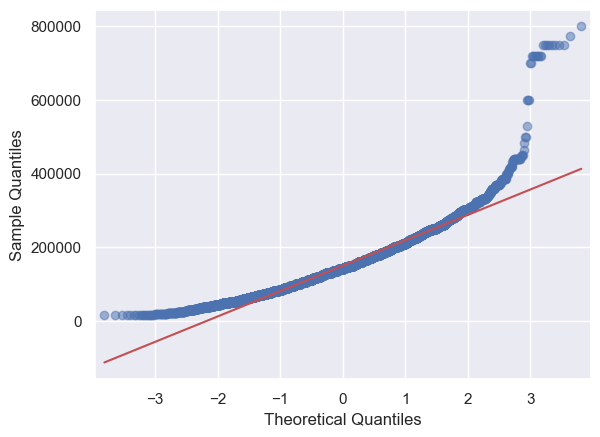

In [5]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [6]:
# The first outliers are absurd. They will skew every result too much and must be removed.
outmax = 450_000
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

Index([ 245,  404,  727,  729,  737,  906, 1534, 1741, 1749, 1757, 2232, 2318,
       2408, 2412, 2548, 2724, 3135, 3910, 3940, 3950, 3954, 4508, 4514, 4817,
       5168, 5444, 5492, 5600],
      dtype='int64')


work_year experience_level employment_type                 job_title  \
14390       2020               MI              FT        Research Scientist   
3703        2024               SE              FT         Research Engineer   
289         2024               SE              FT              AI Architect   
2251        2024               EX              FT  Head of Machine Learning   
3747        2024               SE              FT        Research Scientist   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
14390  450000             USD         450000                 US             0   
3703   450000             USD         450000                 US             0   
289    449000             USD         449000                 US             0   
2251   448000             USD         448000                 US           100   
3747   440000             USD         440000                 US             0   

      company_location company_size  
14390               US            M  
3703                US            M  
289                 US            M  
2251                US            M  
3747                US            M

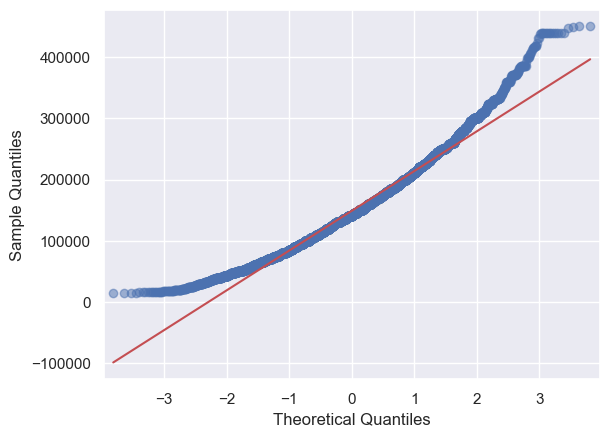

In [7]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling:
These steps will be equally done so no data leakage will occur if done now

In [8]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [9]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

work_year experience_level employment_type  \
14598       2021               SE              FT   
14599       2021               MI              FT   
14600       2021               MI              FT   
14601       2021               MI              FT   
14602       2021               SE              FT   
14603       2020               SE              FT   
14604       2021               MI              FT   
14605       2020               EN              FT   
14606       2020               EN              CT   
14607       2021               SE              FT   

                                job_title salary_currency  salary_in_usd  \
14598            Director of Data Science             USD         168000   
14599                      Data Scientist             SGD         119059   
14600  Applied Machine Learning Scientist             USD         423000   
14601                       Data Engineer             EUR          28369   
14602                     Data Specialist             USD         165000   
14603                      Data Scientist             USD         412000   
14604            Principal Data Scientist             USD         151000   
14605                      Data Scientist             USD         105000   
14606               Business Data Analyst             USD         100000   
14607                Data Science Manager             INR          94665   

      employee_residence  remote_ratio company_location company_size  \
14598                 JP             0               JP            S   
14599                 SG           100               IL            M   
14600                 US            50               US            L   
14601                 MT            50               MT            L   
14602                 US           100               US            L   
14603                 US           100               US            L   
14604                 US           100               US            L   
14605                 US           100               US            S   
14606                 US           100               US            L   
14607                 IN            50               IN            L   

       work_abroad  
14598            0  
14599            1  
14600            0  
14601            0  
14602            0  
14603            0  
14604            0  
14605            0  
14606            0  
14607            0

In [10]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0        On_Site
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14603     Remote
14604     Remote
14605     Remote
14606     Remote
14607     Hybrid
Name: remote_ratio, Length: 14608, dtype: object

In [11]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

## Feature Engineering

In [12]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs.job_title.unique()), "different job titles \n")
print(aijobs.job_title.unique())

151 different job titles 

['Research Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Integration Specialist' 'Data Analyst'
 'Data Scientist' 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Applied Scientist'
 'Research Scientist' 'Analytics Engineer' 'Data Engineer'
 'Data Developer' 'Data Science' 'Business Intelligence'
 'Business Intelligence Analyst' 'AI Engineer' 'CRM Data Analyst'
 'Data Integration Engineer' 'ETL Developer'
 'Business Intelligence Manager' 'Data Architect' 'Data Manager'
 'Data Science Engineer' 'Data Analytics Manager' 'Data Specialist'
 'AI Architect' 'Robotics Engineer' 'Research Analyst' 'BI Developer'
 'Head of Data' 'Data Science Manager' 'Data Modeler'
 'Cloud Database Engineer' 'Machine Learning Scientist'
 'Data Operations Analyst' 'Data Science Analyst'
 'Data Science Practitioner' 'Data Management Analyst'
 'Data Science Consultant' 'BI Data Analyst' 'Applied Data Scientist'
 'Insight

In [13]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs.job_title.unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

80 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Engineer', 'Engineering', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Tech', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [14]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Consultant', 'Computational', 'Computer', 'Managing', 'Power', 'Sales', 'Tech', 'Technician', 
              'Vehicle', 'Autonomous', 'Compliance', 'DevOps', 'Marketing']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.
# All other ones present themselves only at most in a couple of entries and therefore are prone to overfitting.

In [15]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller','Modeler',
                 'Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager']

In [16]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',       # Typo
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager'}

In [17]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning \n\n", clean_terms)

39 terms after cleaning 

 ['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Database', 'Decision', 'Deep', 'Developer', 'Director', 'ETL', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Software', 'Specialist', 'Staff', 'Vision', 'Visualization']


In [18]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs

work_year experience_level employment_type  \
0           2024               SE              FT   
1           2024               SE              FT   
2           2024               SE              FT   
3           2024               SE              FT   
4           2024               SE              FT   
...          ...              ...             ...   
14603       2020               SE              FT   
14604       2021               MI              FT   
14605       2020               EN              FT   
14606       2020               EN              CT   
14607       2021               SE              FT   

                            job_title salary_currency  salary_in_usd  \
0                   Research Engineer             USD         196720   
1                   Research Engineer             USD         113210   
2      Business Intelligence Engineer             USD         204500   
3      Business Intelligence Engineer             USD         139000   
4           Machine Learning Engineer             USD         270000   
...                               ...             ...            ...   
14603                  Data Scientist             USD         412000   
14604        Principal Data Scientist             USD         151000   
14605                  Data Scientist             USD         105000   
14606           Business Data Analyst             USD         100000   
14607            Data Science Manager             INR          94665   

      employee_residence remote_ratio company_location company_size  ...  \
0                     US      On_Site               US            M  ...   
1                     US      On_Site               US            M  ...   
2                     US      On_Site               US            M  ...   
3                     US      On_Site               US            M  ...   
4                     US      On_Site               US            M  ...   
...                  ...          ...              ...          ...  ...   
14603                 US       Remote               US            L  ...   
14604                 US       Remote               US            L  ...   
14605                 US       Remote               US            S  ...   
14606                 US       Remote               US            L  ...   
14607                 IN       Hybrid               IN            L  ...   

       job_name_Intelligence  job_name_Business  job_name_Cloud  \
0                          0                  0               0   
1                          0                  0               0   
2                          1                  1               0   
3                          1                  1               0   
4                          0                  0               0   
...                      ...                ...             ...   
14603                      0                  0               0   
14604                      0                  0               0   
14605                      0                  0               0   
14606                      0                  1               0   
14607                      0                  0               0   

       job_name_Modeler  job_name_Engineer  job_name_Finance  \
0                     0                  1                 0   
1                     0                  1                 0   
2                     0                  1                 0   
3                     0                  1                 0   
4                     0                  1                 0   
...                 ...                ...               ...   
14603                 0                  0                 0   
14604                 0                  0                 0   
14605                 0                  0                 0   
14606                 0                  0                 0   
14607                 0                  0                 0   

       job_name_Re

In [19]:
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)

aijobs

work_year experience_level employment_type  \
0           2024               SE              FT   
1           2024               SE              FT   
2           2024               SE              FT   
3           2024               SE              FT   
4           2024               SE              FT   
...          ...              ...             ...   
14603       2020               SE              FT   
14604       2021               MI              FT   
14605       2020               EN              FT   
14606       2020               EN              CT   
14607       2021               SE              FT   

                            job_title salary_currency  salary_in_usd  \
0                   Research Engineer             USD         196720   
1                   Research Engineer             USD         113210   
2      Business Intelligence Engineer             USD         204500   
3      Business Intelligence Engineer             USD         139000   
4           Machine Learning Engineer             USD         270000   
...                               ...             ...            ...   
14603                  Data Scientist             USD         412000   
14604        Principal Data Scientist             USD         151000   
14605                  Data Scientist             USD         105000   
14606           Business Data Analyst             USD         100000   
14607            Data Science Manager             INR          94665   

      employee_residence remote_ratio company_location company_size  ...  \
0                     US      On_Site               US            M  ...   
1                     US      On_Site               US            M  ...   
2                     US      On_Site               US            M  ...   
3                     US      On_Site               US            M  ...   
4                     US      On_Site               US            M  ...   
...                  ...          ...              ...          ...  ...   
14603                 US       Remote               US            L  ...   
14604                 US       Remote               US            L  ...   
14605                 US       Remote               US            S  ...   
14606                 US       Remote               US            L  ...   
14607                 IN       Hybrid               IN            L  ...   

       company_location_SI  company_location_TH  company_location_TR  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14603                    0                    0                    0   
14604                    0                    0                    0   
14605                    0                    0                    0   
14606                    0                    0                    0   
14607                    0                    0                    0   

       company_location_UA  company_location_US  company_location_VN  \
0                        0                    1                    0   
1                        0                    1                    0   
2                        0                    1                    0   
3                        0                    1                    0   
4                        0                    1                    0   
...                    ...                  ...                  ...   
14603                    0                    1                    0   
14604                    0                    1                    0   
14605                    0                    1                    0   
14606  

In [20]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       23
employee_residence    88
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [21]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_CRM',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_n

In [22]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 is a minimum threshold

def del_vars(X_train, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    if printing == True:
        print("After:", X_train.shape)

In [23]:
new_X = aijobs[X_vars + ['salary_in_usd']].copy()

In [24]:
new_X

work_year  work_abroad  job_name_AI  job_name_Admin  job_name_Analyst  \
0           2024            0            0               0                 0   
1           2024            0            0               0                 0   
2           2024            0            0               0                 0   
3           2024            0            0               0                 0   
4           2024            0            0               0                 0   
...          ...          ...          ...             ...               ...   
14603       2020            0            0               0                 0   
14604       2021            0            0               0                 0   
14605       2020            0            0               0                 0   
14606       2020            0            0               0                 1   
14607       2021            0            0               0                 0   

       job_name_Analytics  job_name_Applied  job_name_Architect  \
0                       0                 0                   0   
1                       0                 0                   0   
2                       0                 0                   0   
3                       0                 0                   0   
4                       0                 0                   0   
...                   ...               ...                 ...   
14603                   0                 0                   0   
14604                   0                 0                   0   
14605                   0                 0                   0   
14606                   0                 0                   0   
14607                   0                 0                   0   

       job_name_Associate  job_name_Big  ...  company_location_TH  \
0                       0             0  ...                    0   
1                       0             0  ...                    0   
2                       0             0  ...                    0   
3                       0             0  ...                    0   
4                       0             0  ...                    0   
...                   ...           ...  ...                  ...   
14603                   0             0  ...                    0   
14604                   0             0  ...                    0   
14605                   0             0  ...                    0   
14606                   0             0  ...                    0   
14607                   0             0  ...                    0   

       company_location_TR  company_location_UA  company_location_US  \
0                        0                    0                    1   
1                        0                    0                    1   
2                        0                    0                    1   
3                        0                    0                    1   
4                        0                    0                    1   
...                    ...                  ...                  ...   
14603                    0                    0                    1   
14604                    0                    0                    1   
14605                    0                    0                    1   
14606                    0                    0                    1   
14607                    0                    0                    0   

       company_location_VN  company_location_ZA  company_size_L  \
0                        0                    0               0   
1                        0                    0               0   
2                        0                    0               0   
3                        0                    0               0   
4                        0                    0               0   
...                    ...                  ...             ...   
14603                    0                    0               1   
14604      

In [25]:
del_vars(new_X, printing=True)

Before: (14608, 256)
Rows deleted: 146
Columns dropped: 109
Rows deleted: 33
Columns dropped: 124
Rows deleted: 9
Columns dropped: 128
Rows deleted: 0
Columns dropped: 128
After: (14420, 128)


In [26]:
new_X

work_year  work_abroad  job_name_AI  job_name_Analyst  \
0           2024            0            0                 0   
1           2024            0            0                 0   
2           2024            0            0                 0   
3           2024            0            0                 0   
4           2024            0            0                 0   
...          ...          ...          ...               ...   
14603       2020            0            0                 0   
14604       2021            0            0                 0   
14605       2020            0            0                 0   
14606       2020            0            0                 1   
14607       2021            0            0                 0   

       job_name_Analytics  job_name_Applied  job_name_Architect  \
0                       0                 0                   0   
1                       0                 0                   0   
2                       0                 0                   0   
3                       0                 0                   0   
4                       0                 0                   0   
...                   ...               ...                 ...   
14603                   0                 0                   0   
14604                   0                 0                   0   
14605                   0                 0                   0   
14606                   0                 0                   0   
14607                   0                 0                   0   

       job_name_Associate  job_name_Big  job_name_Database  ...  \
0                       0             0                  0  ...   
1                       0             0                  0  ...   
2                       0             0                  0  ...   
3                       0             0                  0  ...   
4                       0             0                  0  ...   
...                   ...           ...                ...  ...   
14603                   0             0                  0  ...   
14604                   0             0                  0  ...   
14605                   0             0                  0  ...   
14606                   0             0                  0  ...   
14607                   0             0                  0  ...   

       company_location_PL  company_location_PT  company_location_SI  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
14603                    0                    0                    0   
14604                    0                    0                    0   
14605                    0                    0                    0   
14606                    0                    0                    0   
14607                    0                    0                    0   

       company_location_UA  company_location_US  company_location_ZA  \
0                        0                    1                    0   
1                        0                    1                    0   
2                        0                    1                    0   
3                        0                    1                    0   
4                        0                    1                    0   
...                    ...                  ...                  ...   
14603                    0                    1                    0   
14604                    0                    1                    0   
14605                    0                    1                    0   
14606                    0                 

## Box-Cox transformation

Best Lambda Value: 0.4458


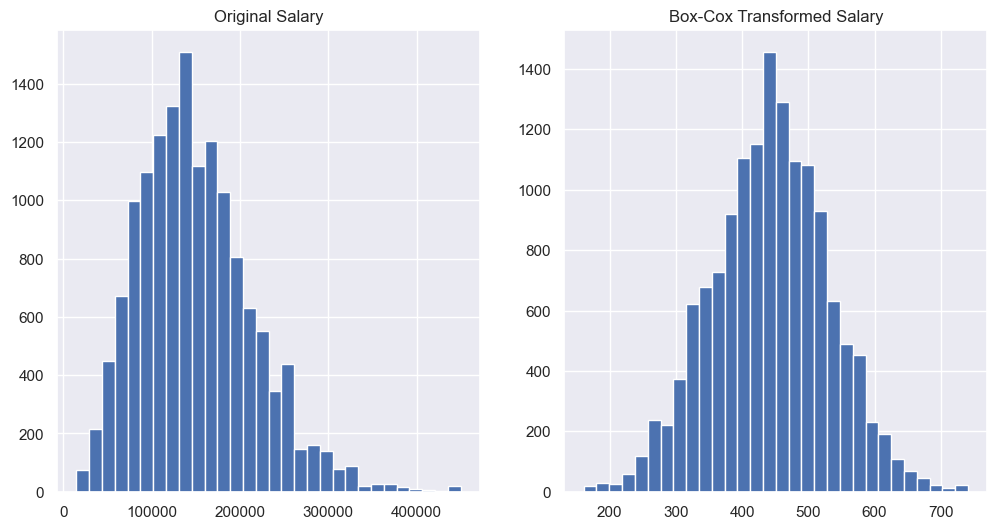

Normal test: NormaltestResult(statistic=0.8948621087755665, pvalue=0.6392682894745733)
Shapiro-Wilk test: ShapiroResult(statistic=0.9992362856864929, pvalue=4.209837243251968e-06)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=160.9257380064905, statistic_sign=-1)


C:\Users\Captain\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [27]:
# fit the lambda and transform the train dependent variable
new_X['transformed_salary'], lmbda = boxcox(new_X['salary_in_usd'])
print(f'Best Lambda Value: {lmbda:.4f}')

# plot

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.hist(new_X['salary_in_usd'], bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(new_X['transformed_salary'], bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(new_X['transformed_salary']))
print('Shapiro-Wilk test:', shapiro(new_X['transformed_salary']))
print('Kolmogorov-Smirnov test:', kstest(new_X['transformed_salary'], "norm"))

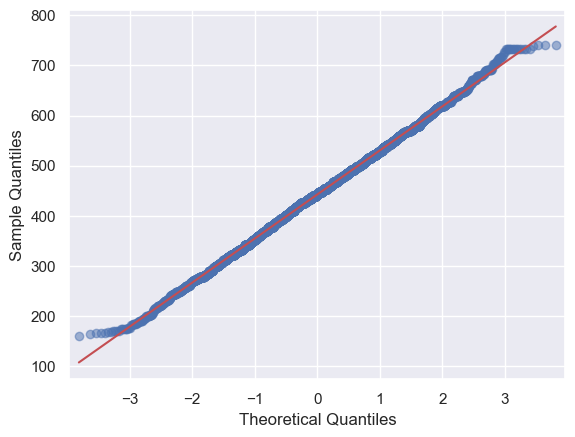

In [28]:
sm.qqplot(new_X['transformed_salary'], line='s', alpha=0.5)
plt.show()

# DATA DESCRIPTION

work_year
2023    8512
2024    4151
2022    1652
2021     218
2020      75
Name: count, dtype: int64


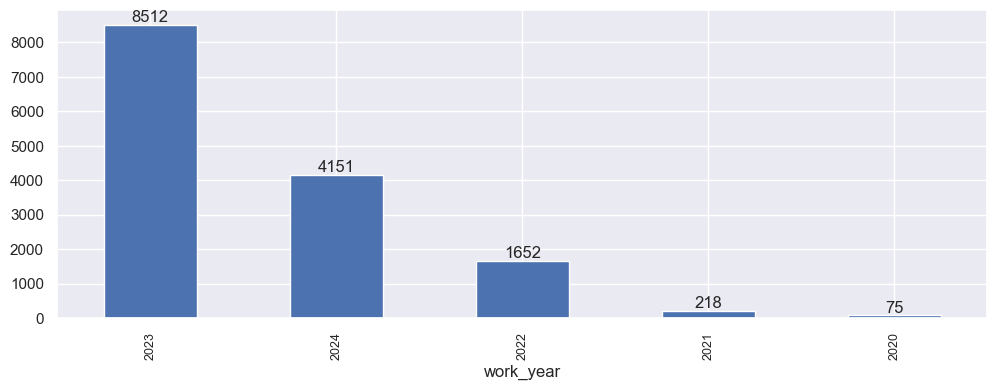

experience_level
SE    9564
MI    3477
EN    1133
EX     434
Name: count, dtype: int64


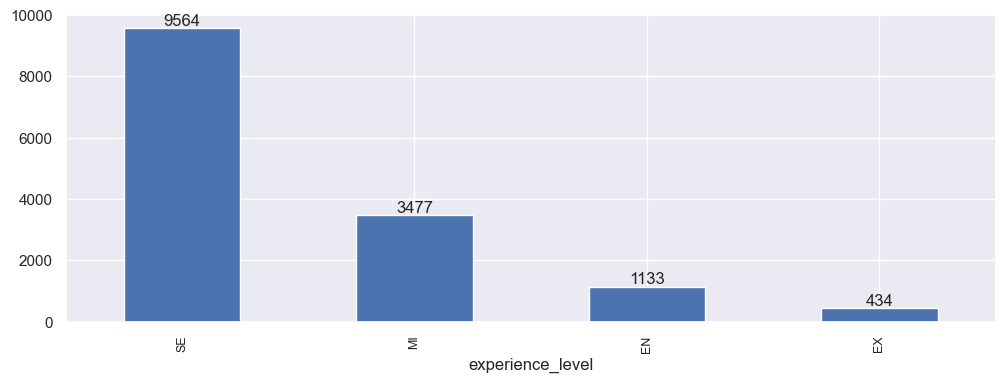

employment_type
FT    14544
CT       26
PT       25
FL       13
Name: count, dtype: int64


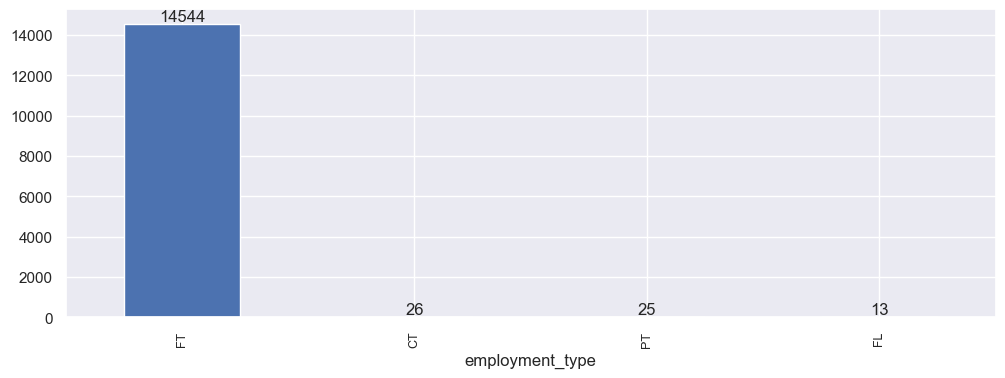

salary_currency
USD    13460
GBP      561
EUR      423
INR       53
CAD       51
AUD       12
CHF        7
PLN        7
SGD        6
JPY        4
BRL        4
DKK        3
HUF        3
TRY        3
NOK        2
THB        2
ZAR        1
HKD        1
ILS        1
PHP        1
NZD        1
MXN        1
CLP        1
Name: count, dtype: int64


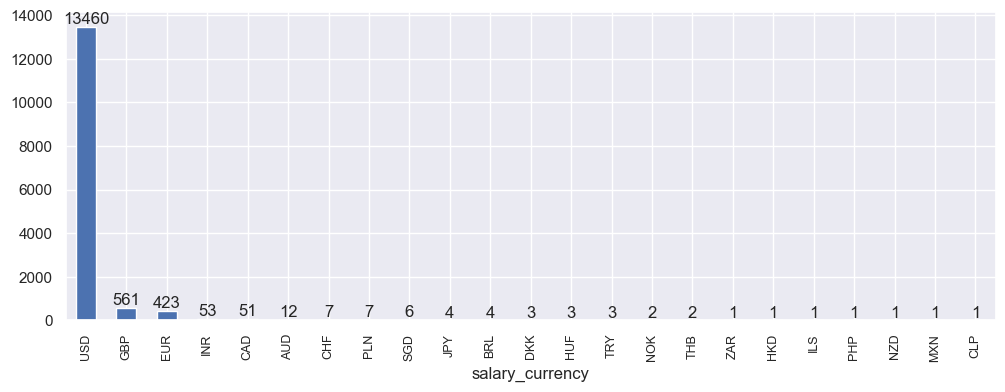

employee_residence
US    12722
GB      641
CA      377
ES      131
DE       90
      ...  
QA        1
MU        1
OM        1
UG        1
LU        1
Name: count, Length: 88, dtype: int64


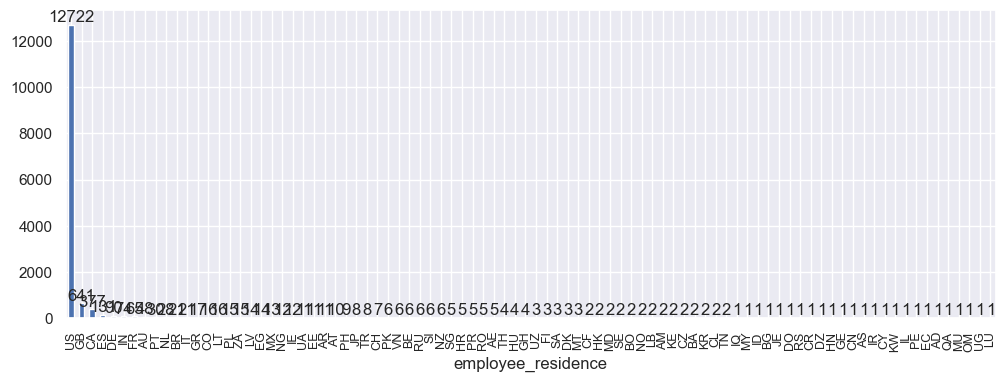

remote_ratio
On_Site    9679
Remote     4682
Hybrid      247
Name: count, dtype: int64


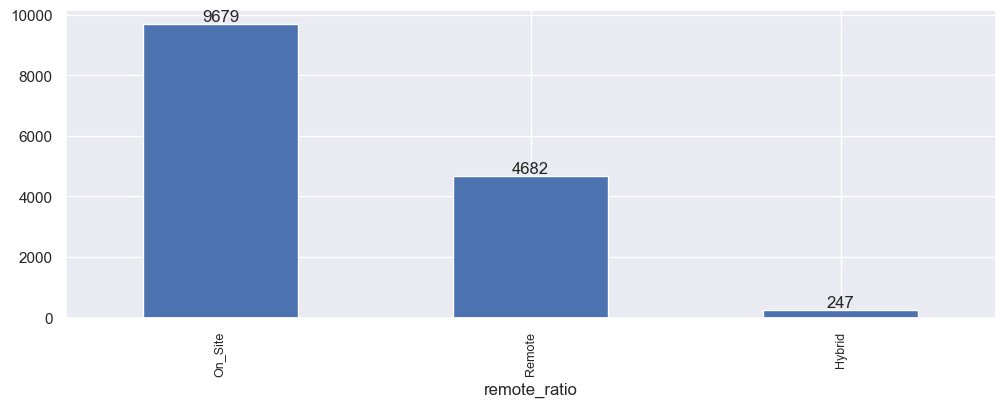

company_location
US    12771
GB      649
CA      379
ES      127
DE       97
      ...  
MU        1
AM        1
QA        1
AD        1
MD        1
Name: count, Length: 77, dtype: int64


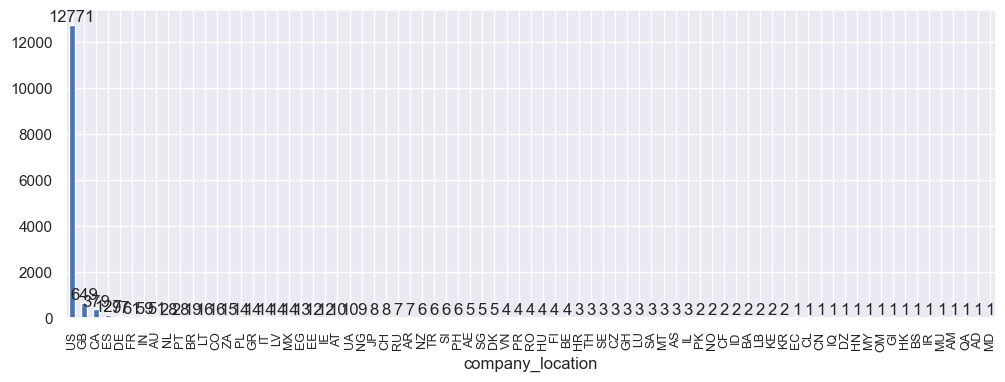

company_size
M    13448
L      980
S      180
Name: count, dtype: int64


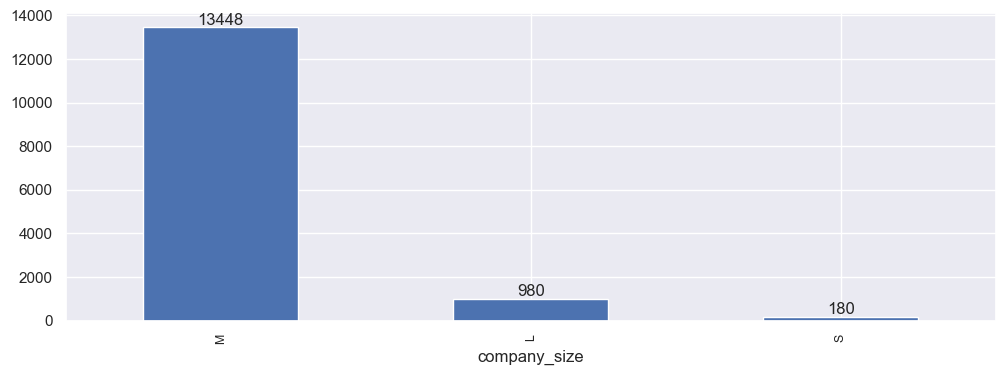

In [29]:
# Quick chart view of the raw base counts for all categorical columns
plt.rc('xtick', labelsize=9)
for col in ['work_year'] + categorical_columns:
    print(aijobs[col].value_counts())
    ax = aijobs[col].value_counts().plot(kind='bar', figsize=(12, 4))
    ax.bar_label(ax.containers[0])
    plt.show()
plt.rc('xtick', labelsize=12) #resetting it for the next plots

In [30]:
# definition for plotting all post treatment dummies' counts, averages and deviation of target variable

def plotting(var):
    usd = new_X.groupby(var)['salary_in_usd']
    box = new_X.groupby(var)['transformed_salary']

    fig, ax = plt.subplots(layout='constrained', figsize=(12, 4))
    ax.remove()

    ax1 = plt.subplot(1, 2, 1)
    rects = ax1.bar(1, usd.mean()[1].astype(int), 0.8, yerr=usd.std()[1].astype(int), color='mediumturquoise')
    ax1.bar_label(rects, label_type='center')
    rects = ax1.bar(2, usd.mean()[0].astype(int), 0.8, yerr=usd.std()[0].astype(int), color='salmon')
    ax1.bar_label(rects, label_type='center')
    ax1.set_xticks([1, 2], [var, 'not ' + var])
    ax1.set_title('Salary in USD')

    ax2 = plt.subplot(1, 2, 2)
    rects = ax2.bar(1, box.mean()[1].astype(int), 0.8, yerr=box.std()[1].astype(int), color='mediumaquamarine')
    ax2.bar_label(rects, label_type='center')
    rects = ax2.bar(2, box.mean()[0].astype(int), 0.8, yerr=box.std()[0].astype(int), color='lightcoral')
    ax2.bar_label(rects, label_type='center')
    ax2.set_xticks([1, 2], [var, 'not ' + var])
    ax2.set_title('Transformed Salary')

    plt.show()

In [31]:
avg = new_X[['transformed_salary']].mean()[0]
avg

442.43998025306894

salary_in_usd              transformed_salary     
                   mean    std count               mean  std
work_year                                                   
2020             107839  84984    63                368  117
2021             107461  68681   179                371  107
2022             135837  57094  1614                423   85
2023             153995  63032  8437                448   85
2024             149484  67694  4127                441   89

salary_in_usd               transformed_salary    
                     mean    std  count               mean std
work_abroad                                                   
0                  150194  64303  14357                442  87
1                   81138  57509     63                326  98

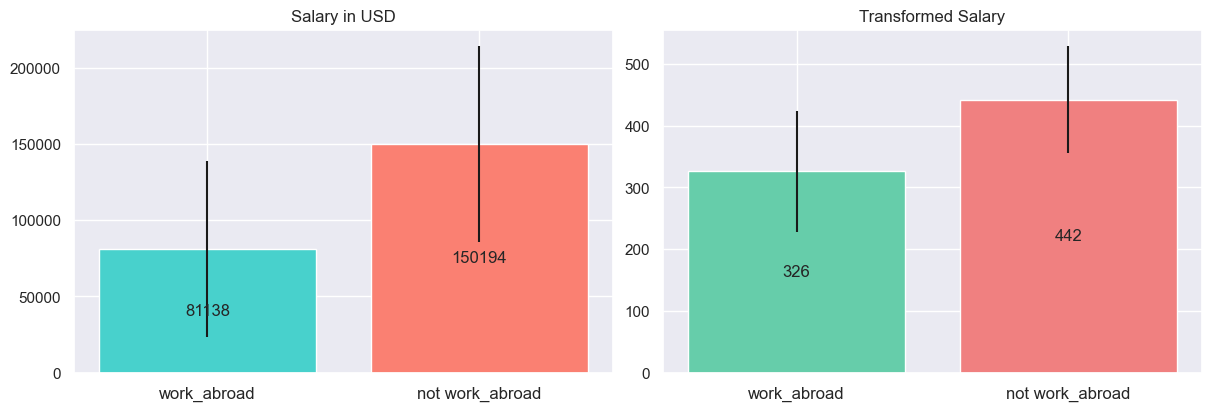

salary_in_usd               transformed_salary     
                     mean    std  count               mean  std
job_name_AI                                                    
0                  149669  64134  14253                442   87
1                  168997  84408    167                461  112

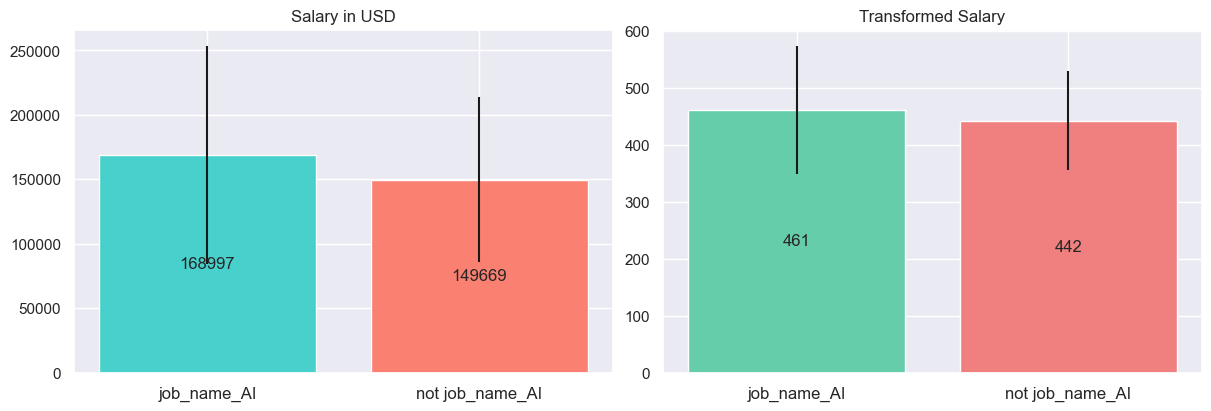

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Analyst                                                   
0                       159191  64466  11849                455  85
1                       107039  43573   2571                381  70

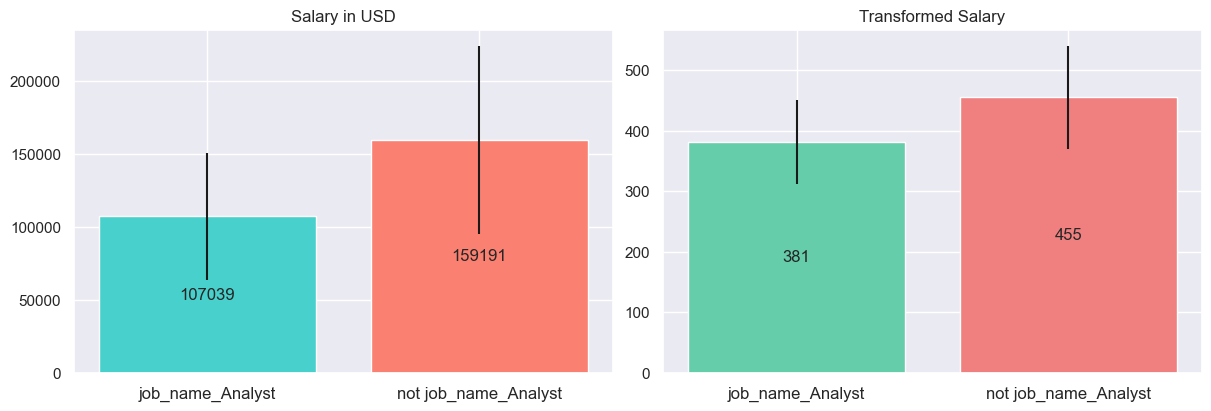

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Analytics                                                   
0                         149814  64647  13941                442  88
1                         152174  57923    479                448  74

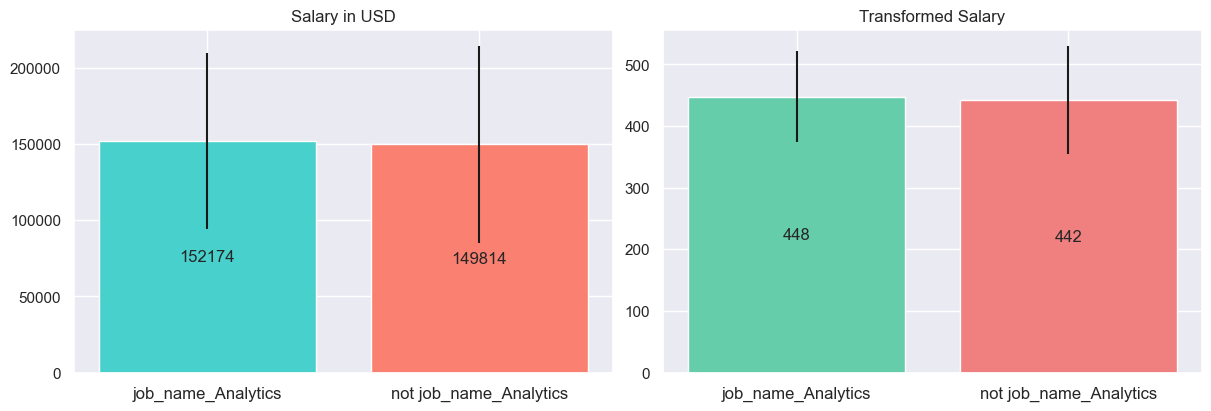

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Applied                                                   
0                       148855  64287  14018                441  87
1                       186079  58962    402                492  76

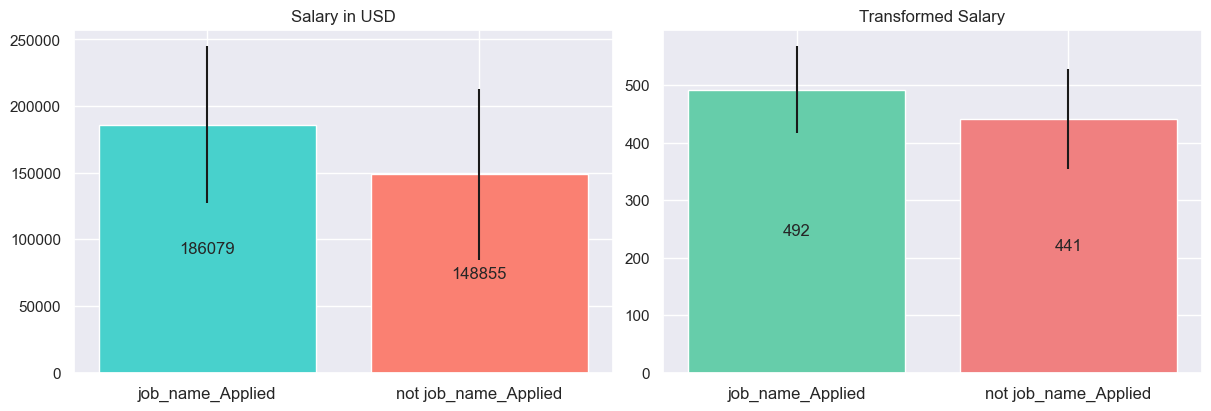

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Architect                                                   
0                         149373  64378  14032                441  88
1                         168687  63726    388                469  78

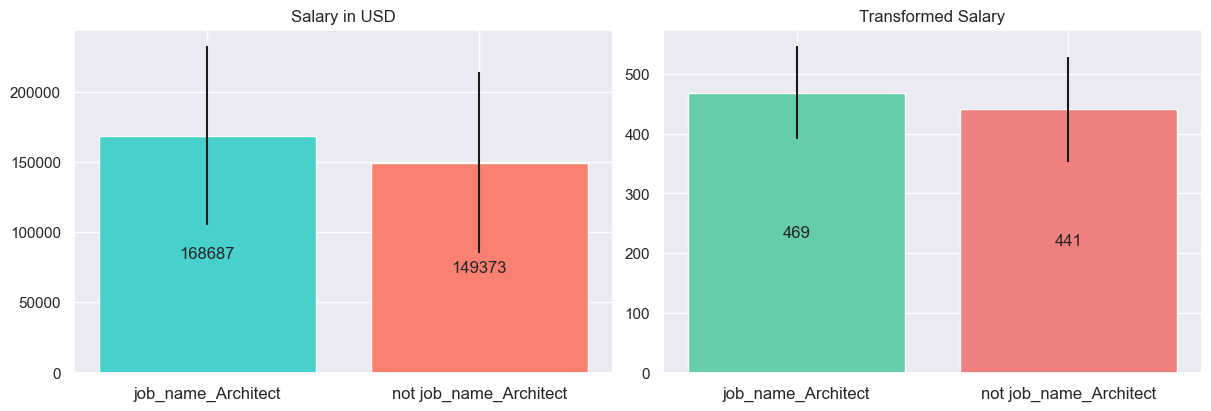

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Associate                                                   
0                         149921  64427  14415                442  87
1                          67319  15618      5                314  32

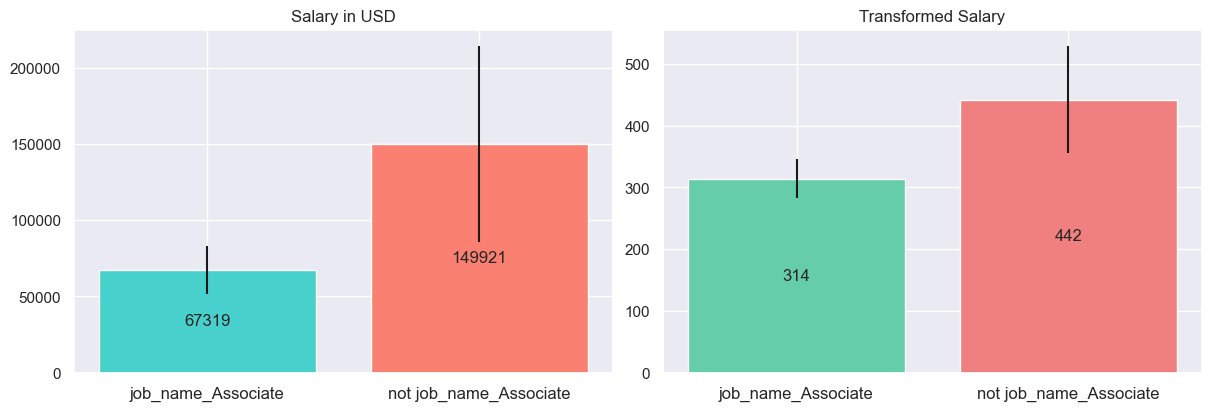

salary_in_usd               transformed_salary     
                      mean    std  count               mean  std
job_name_Big                                                    
0                   149951  64413  14408                442   87
1                    79793  53002     12                320  112

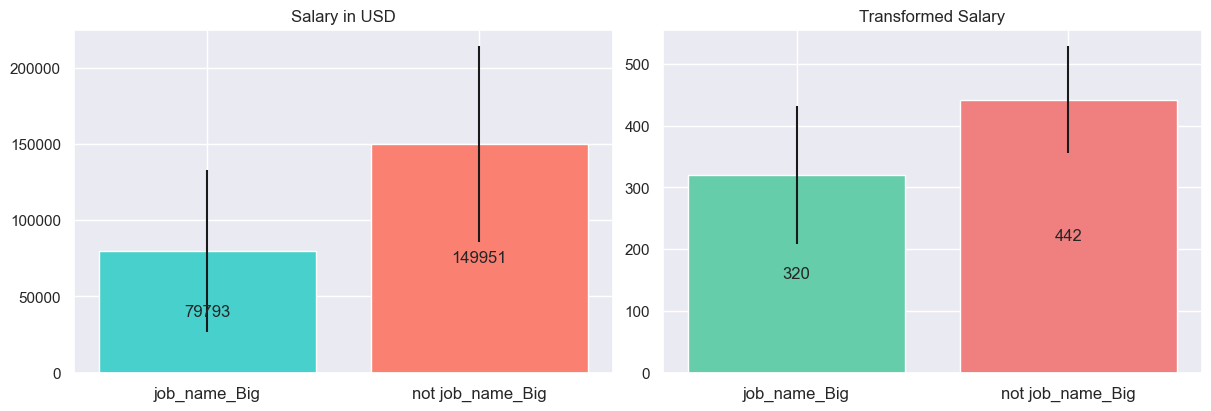

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Database                                                   
0                        149898  64454  14407                442  88
1                        143538  37756     13                440  53

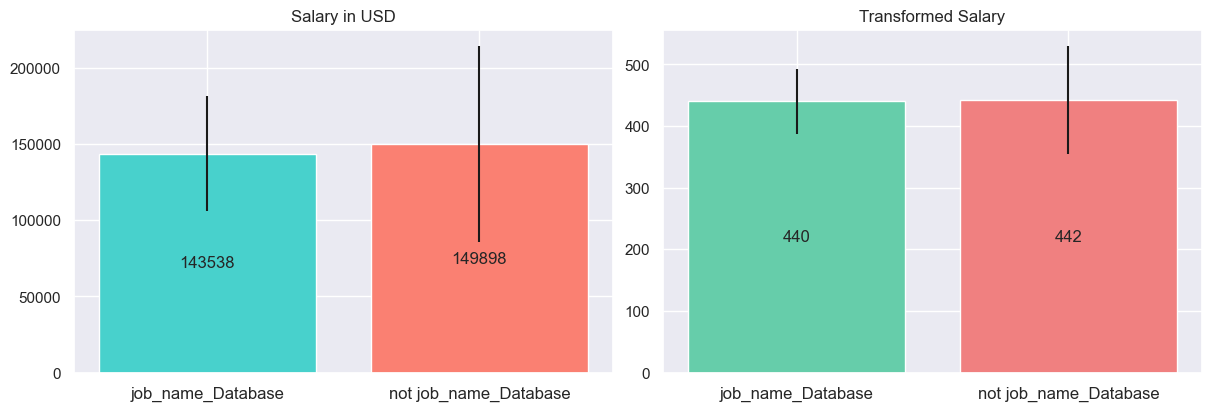

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Decision                                                   
0                        149850  64494  14382                442  88
1                        166094  31969     38                472  41

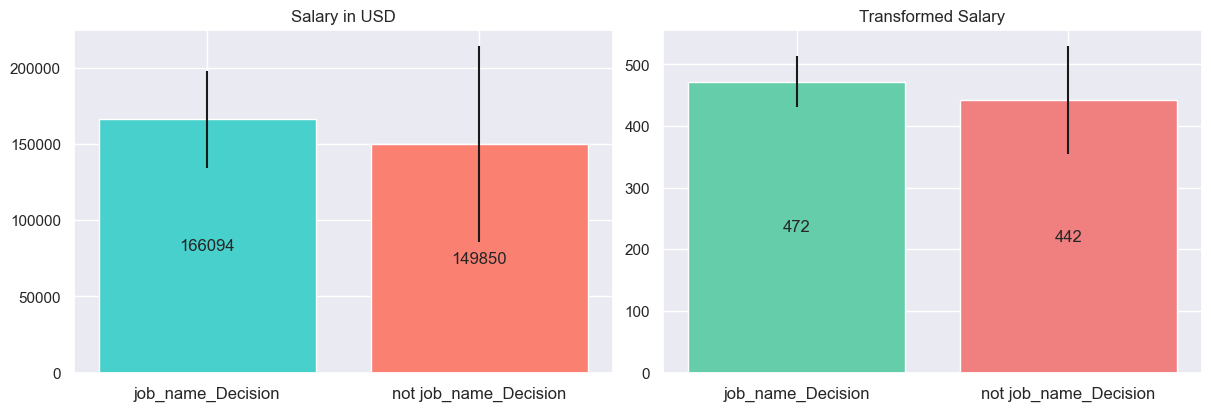

salary_in_usd                transformed_salary     
                       mean     std  count               mean  std
job_name_Deep                                                     
0                    149860   64385  14407                442   87
1                    185681  103900     13                479  127

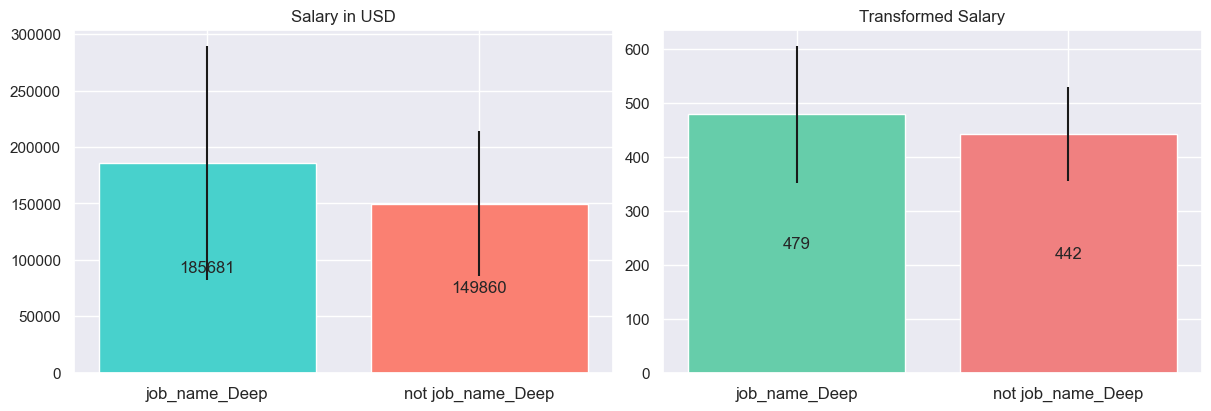

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
job_name_Developer                                                   
0                         150499  64490  14205                443  87
1                         109832  45410    215                386  71

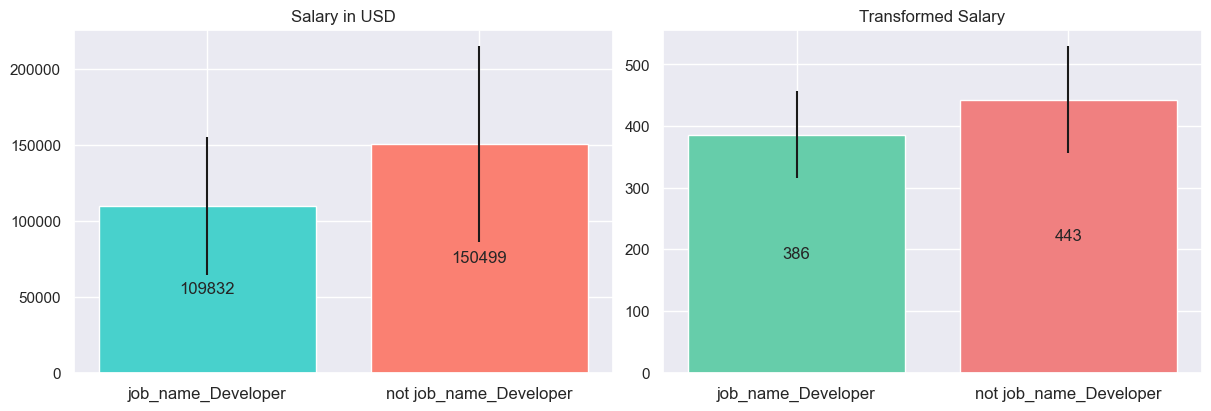

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Director                                                   
0                        149702  64322  14378                442  87
1                        215021  70399     42                525  80

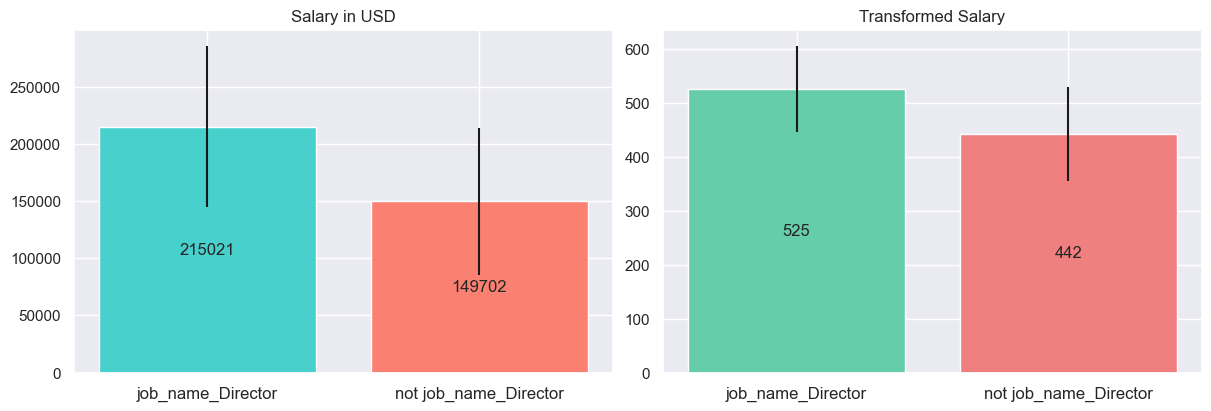

salary_in_usd               transformed_salary    
                      mean    std  count               mean std
job_name_ETL                                                   
0                   149957  64433  14389                442  87
1                   119922  58809     31                398  87

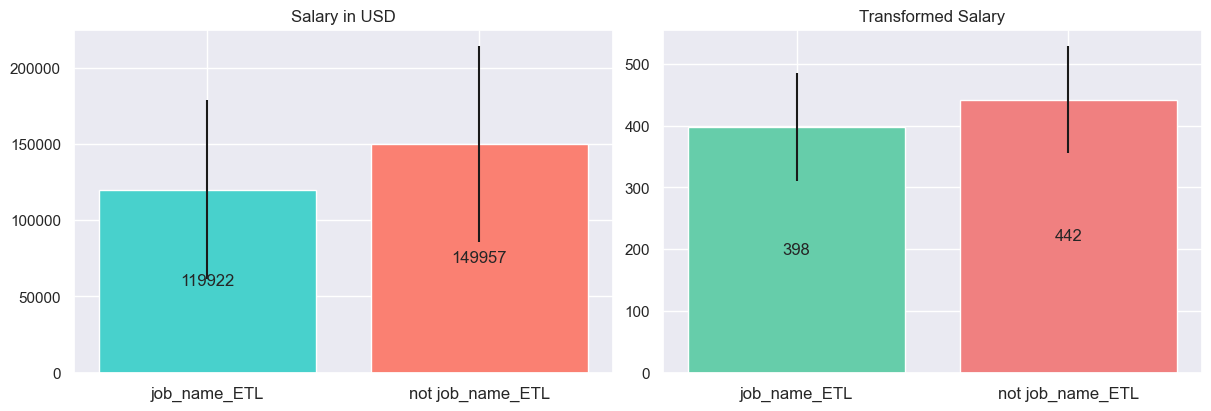

salary_in_usd               transformed_salary     
                       mean    std  count               mean  std
job_name_Head                                                    
0                    149595  64165  14355                442   87
1                    215609  87077     65                521  102

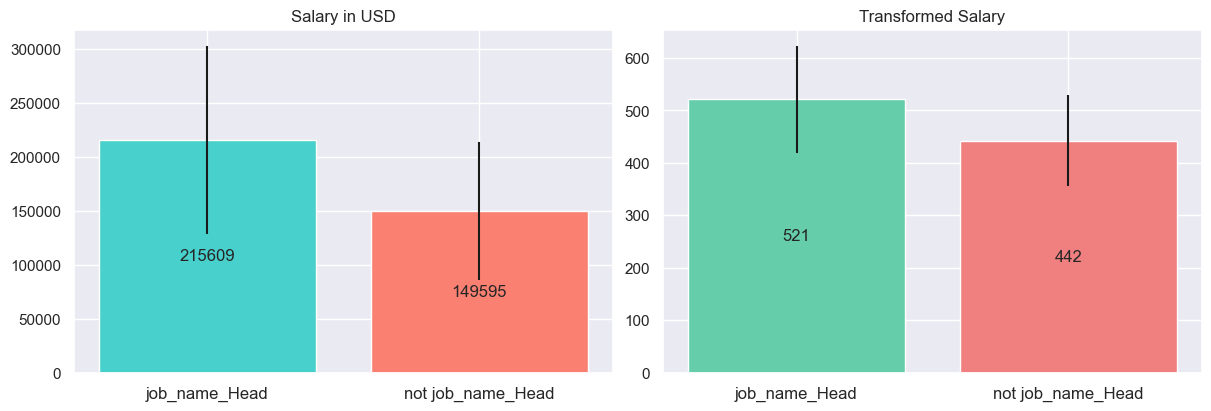

salary_in_usd               transformed_salary    
                                 mean    std  count               mean std
job_name_Infrastructure                                                   
0                              149788  64401  14371                442  87
1                              180436  67587     49                483  82

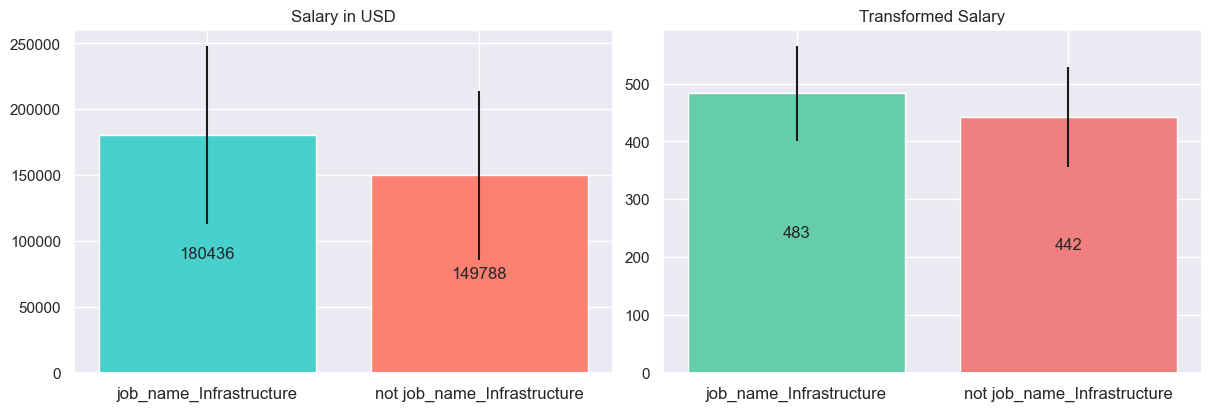

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Insight                                                   
0                       149979  64392  14408                442  87
1                        46459   7158     12                267  19

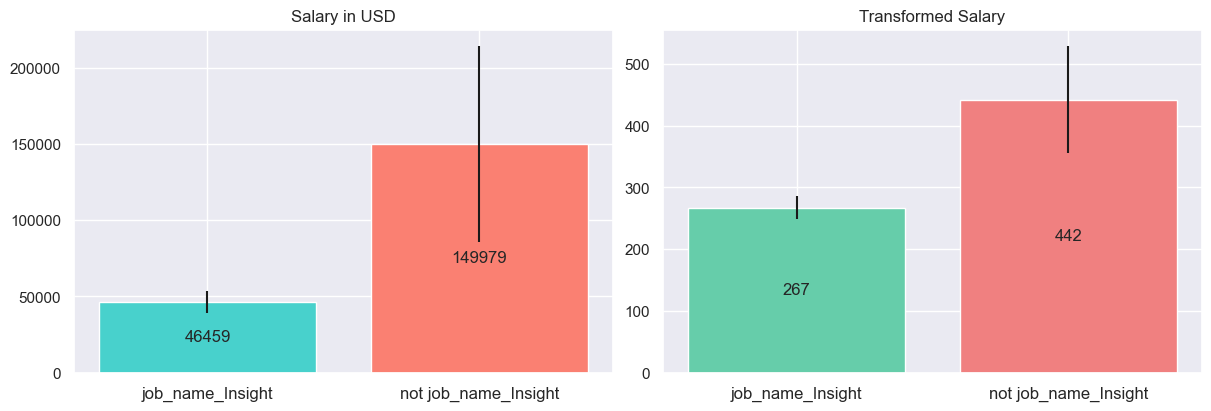

salary_in_usd               transformed_salary    
                              mean    std  count               mean std
job_name_Integration                                                   
0                           150015  64443  14377                442  87
1                           108925  46077     43                384  72

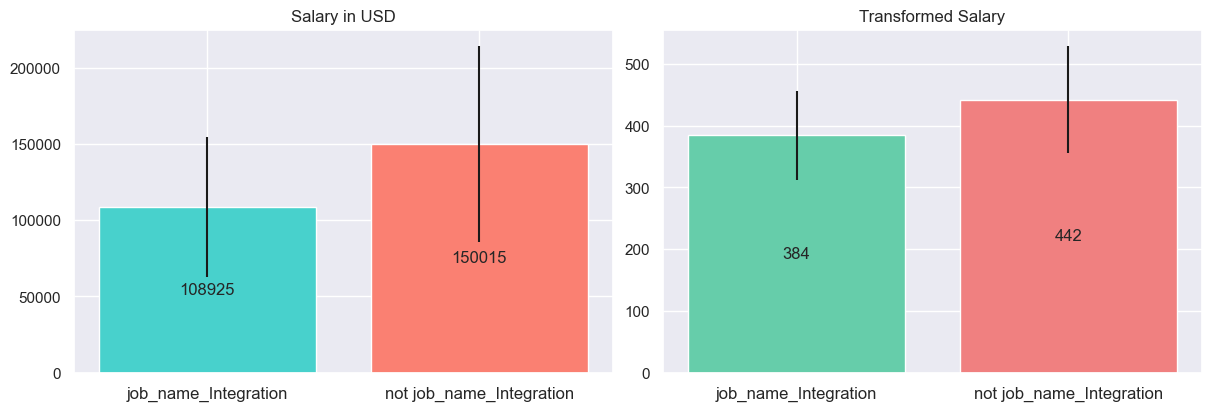

salary_in_usd               transformed_salary     
                       mean    std  count               mean  std
job_name_Lead                                                    
0                    149850  64279  14323                442   87
1                    156099  84432     97                443  114

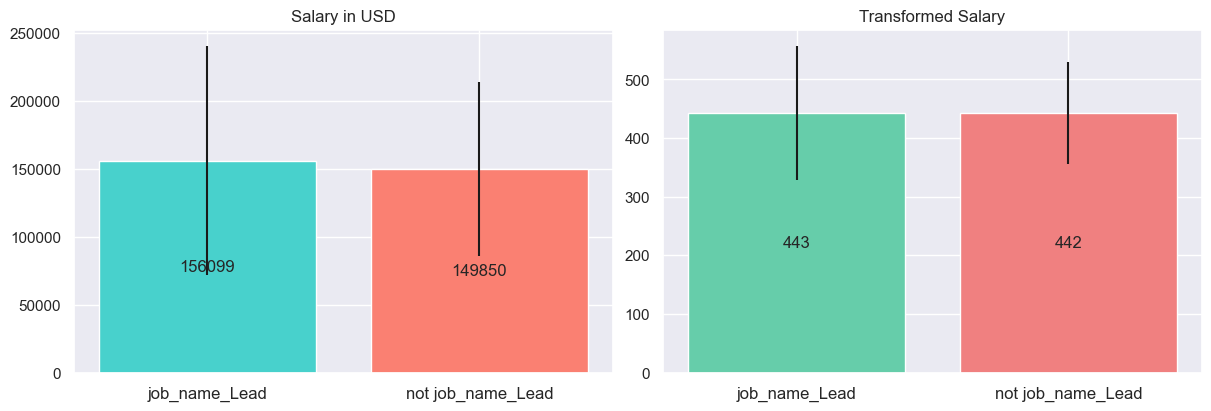

salary_in_usd               transformed_salary     
                      mean    std  count               mean  std
job_name_NLP                                                    
0                   149913  64420  14405                442   87
1                   130002  77349     15                406  116

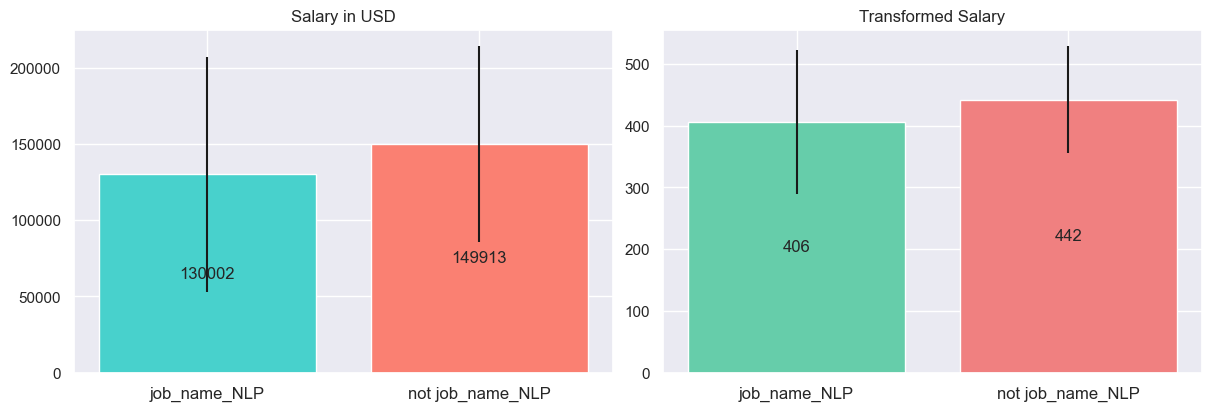

salary_in_usd               transformed_salary    
                      mean    std  count               mean std
job_name_Ops                                                   
0                   149912  64445  14397                442  88
1                   137904  57511     23                427  82

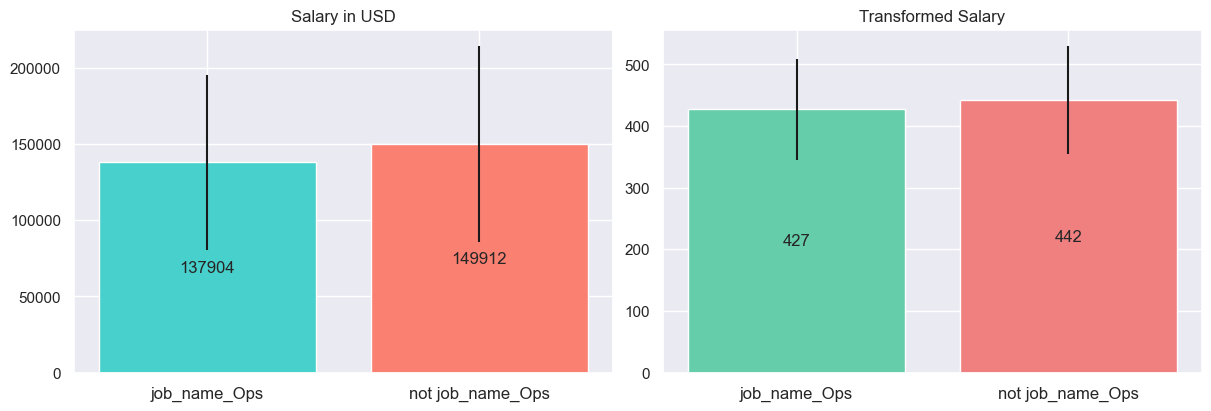

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
job_name_Practitioner                                                   
0                            149910  64451  14404                442  88
1                            133650  45759     16                424  67

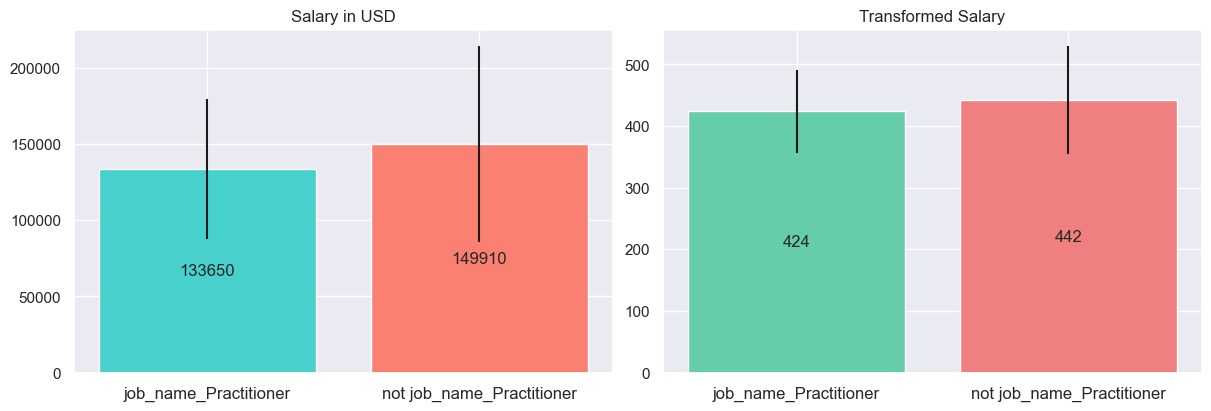

salary_in_usd               transformed_salary     
                            mean    std  count               mean  std
job_name_Principal                                                    
0                         149868  64411  14402                442   87
1                         169490  80500     18                466  100

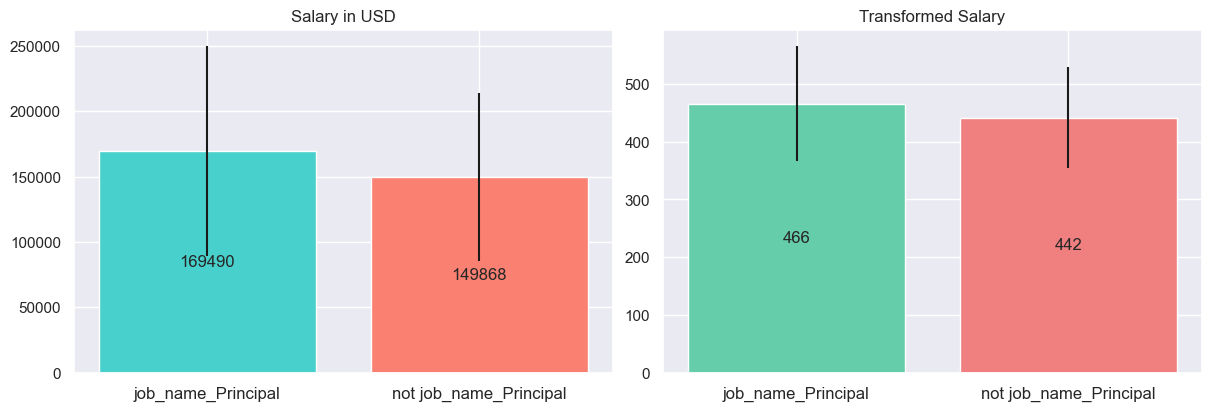

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Product                                                   
0                       149892  64472  14383                442  88
1                       150021  48119     37                446  74

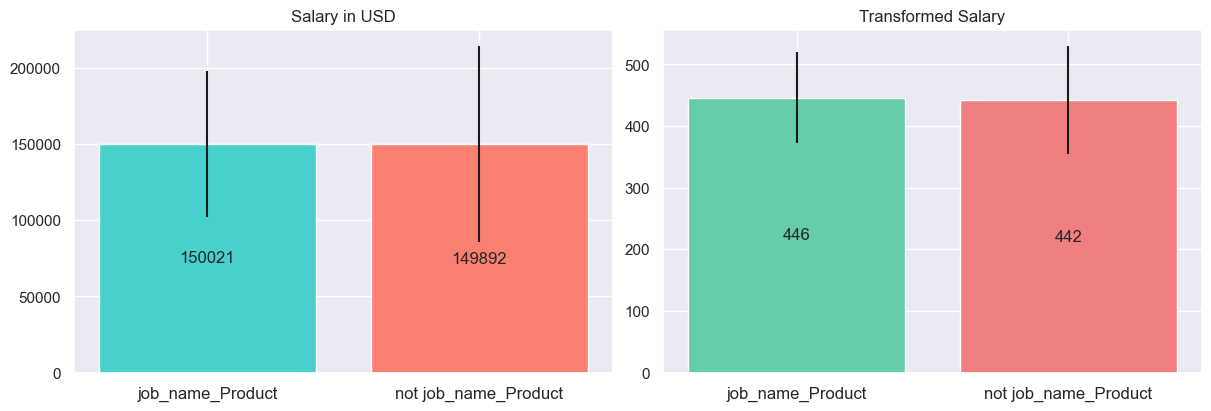

salary_in_usd               transformed_salary    
                         mean    std  count               mean std
job_name_Prompt                                                   
0                      149865  64436  14406                442  87
1                      177937  58683     14                482  78

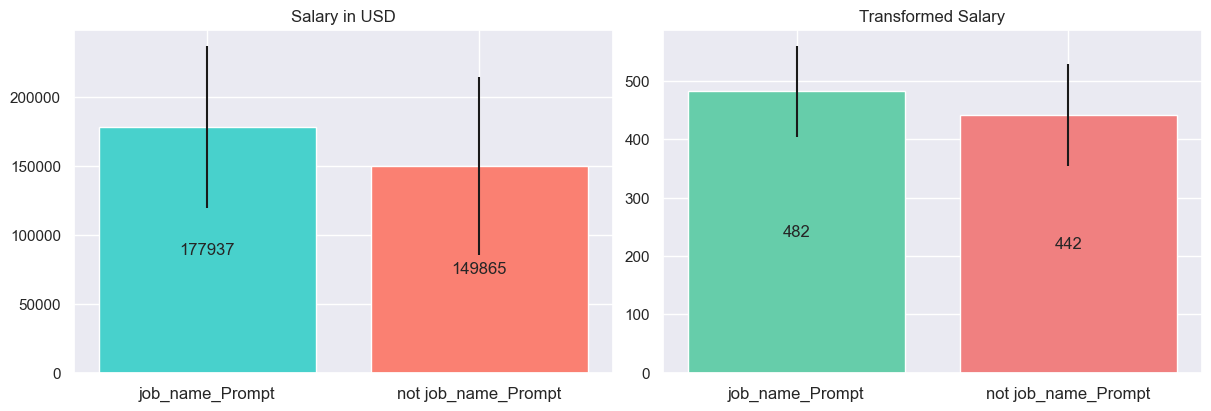

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Quality                                                   
0                       150022  64411  14391                442  87
1                        85532  39020     29                343  71

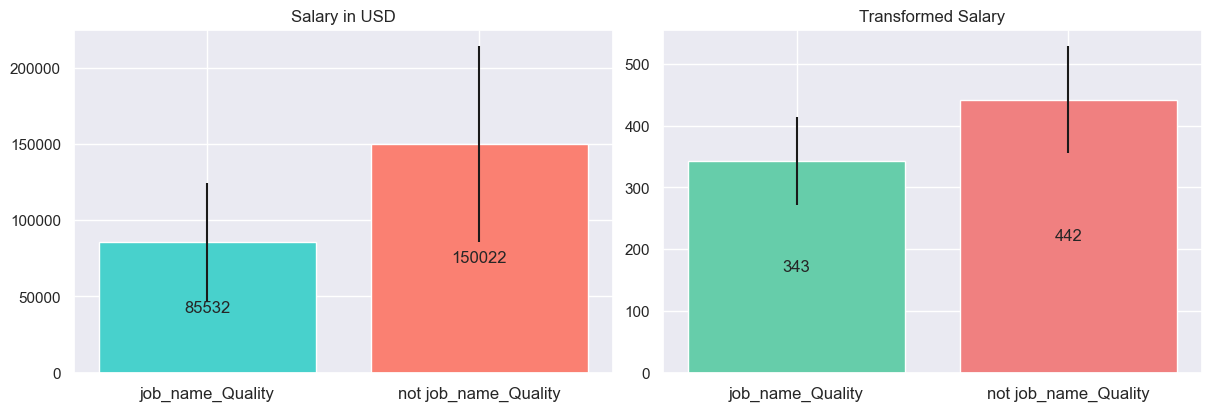

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Robotics                                                   
0                        149878  64439  14406                442  88
1                        165071  59157     14                465  79

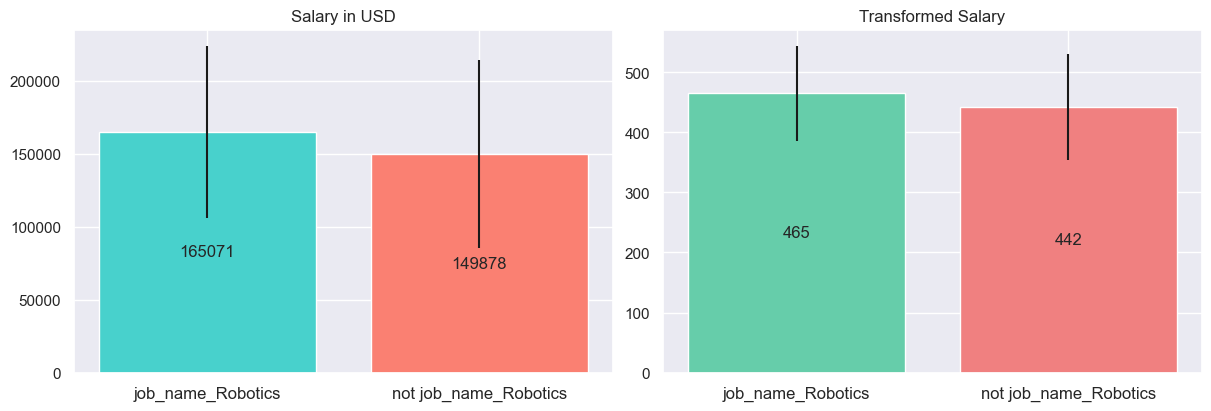

salary_in_usd               transformed_salary     
                           mean    std  count               mean  std
job_name_Software                                                    
0                        149834  64389  14390                442   87
1                        178101  79705     30                475  108

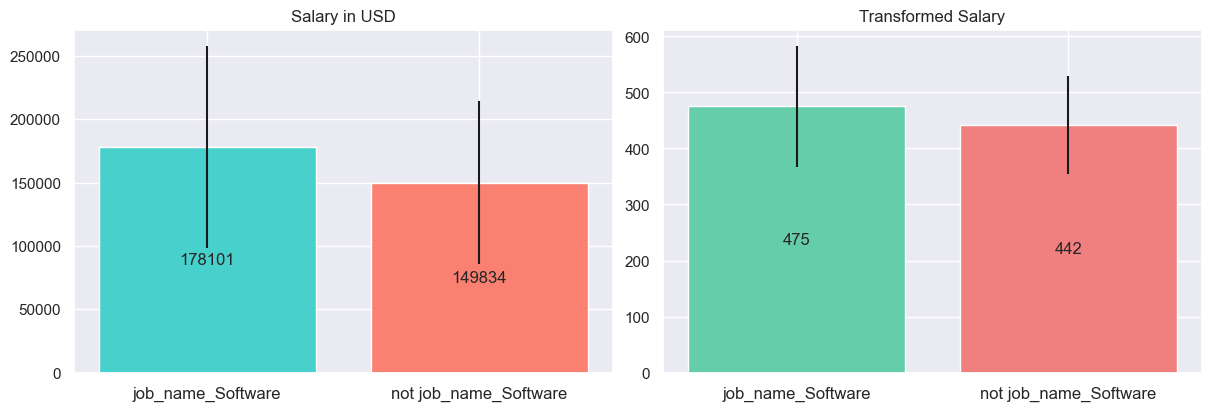

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Specialist                                                   
0                          150414  64383  14283                443  87
1                           95537  43337    137                362  68

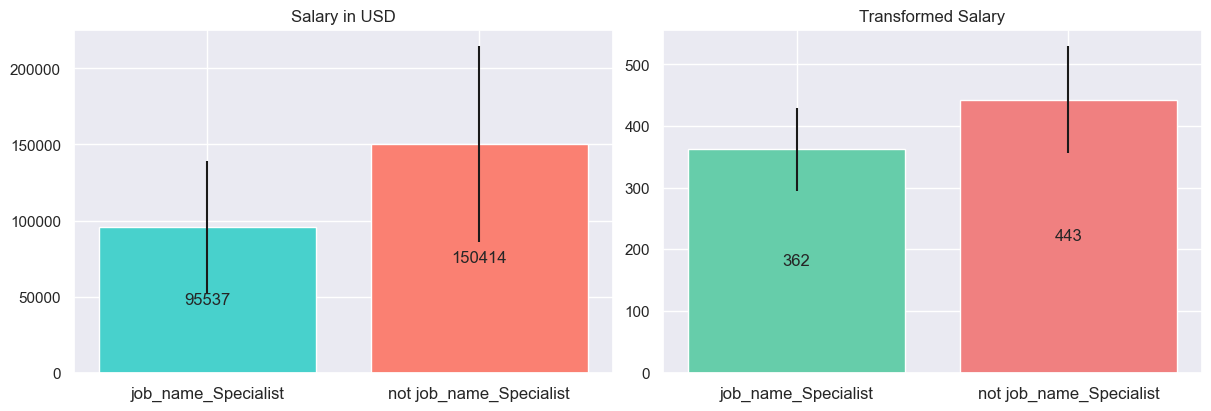

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
job_name_Staff                                                    
0                     149909  64428  14415                442   87
1                     102750  73459      5                356  142

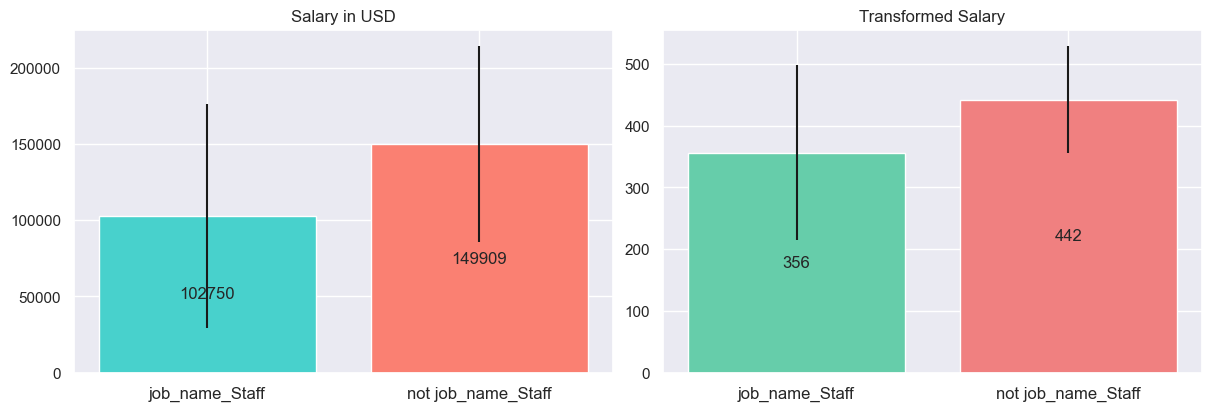

salary_in_usd               transformed_salary     
                         mean    std  count               mean  std
job_name_Vision                                                    
0                      149834  64379  14387                442   87
1                      175390  82702     33                468  118

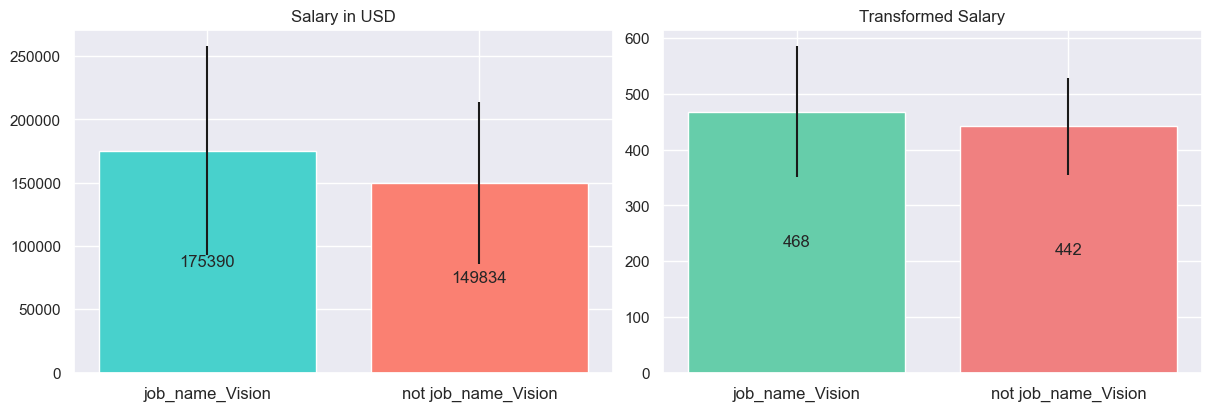

salary_in_usd               transformed_salary    
                                mean    std  count               mean std
job_name_Visualization                                                   
0                             149931  64449  14402                442  88
1                             119144  42584     18                402  66

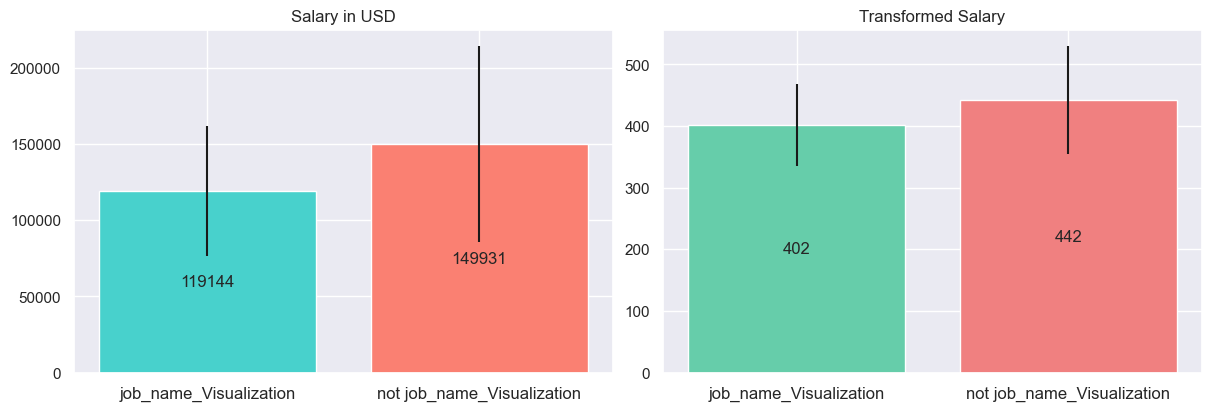

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Machine                                                   
0                       144367  62447  12510                435  86
1                       186081  65541   1910                490  82

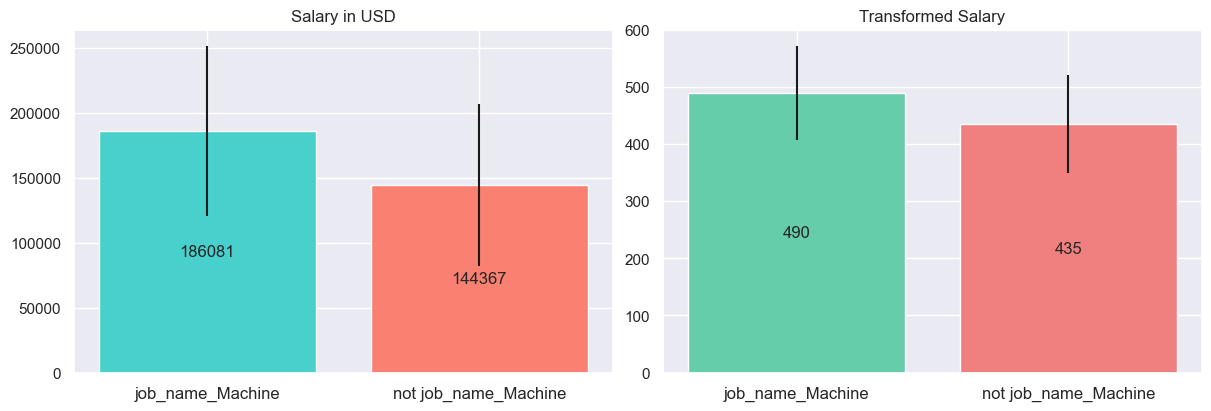

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Operations                                                   
0                          150071  64436  14342                442  87
1                          117005  55428     78                395  82

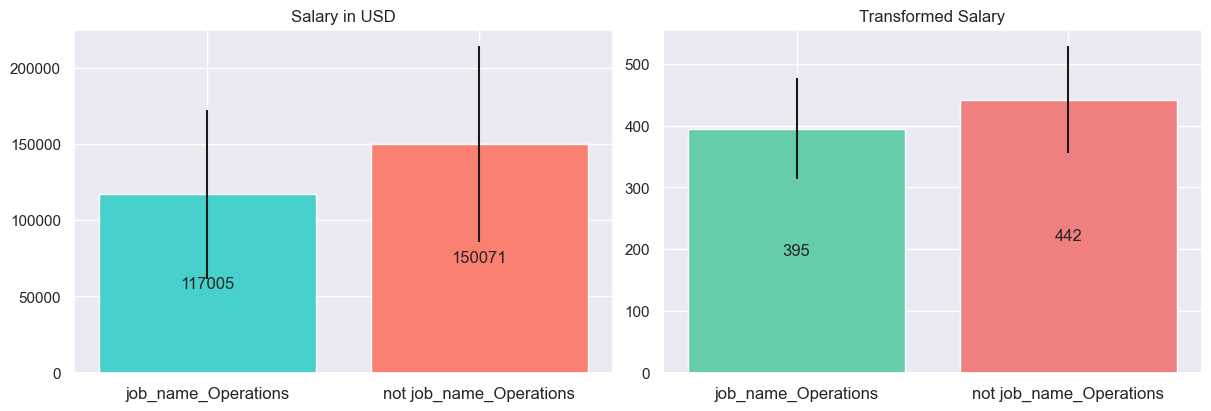

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
job_name_Intelligence                                                   
0                            151085  64741  13790                444  88
1                            123784  50757    630                406  77

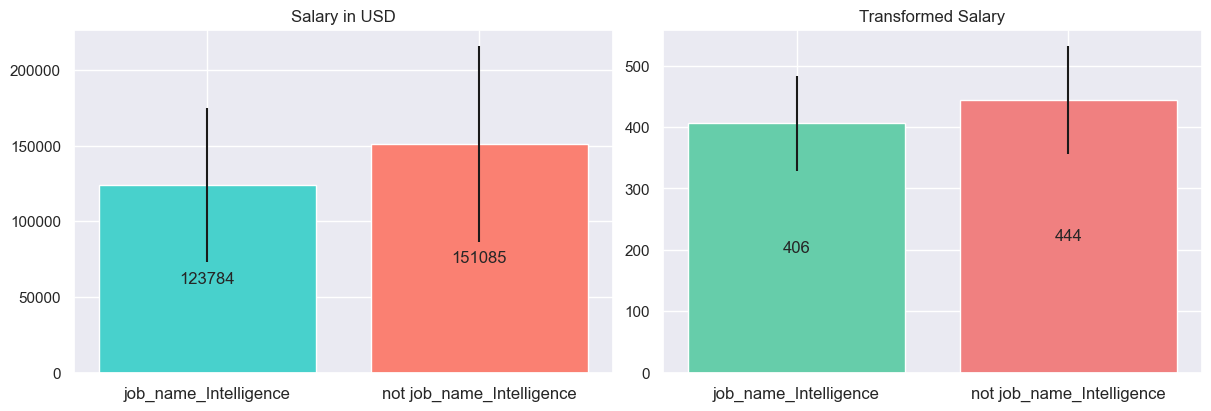

salary_in_usd               transformed_salary    
                           mean    std  count               mean std
job_name_Business                                                   
0                        151159  64718  13775                444  88
1                        122838  51054    645                405  79

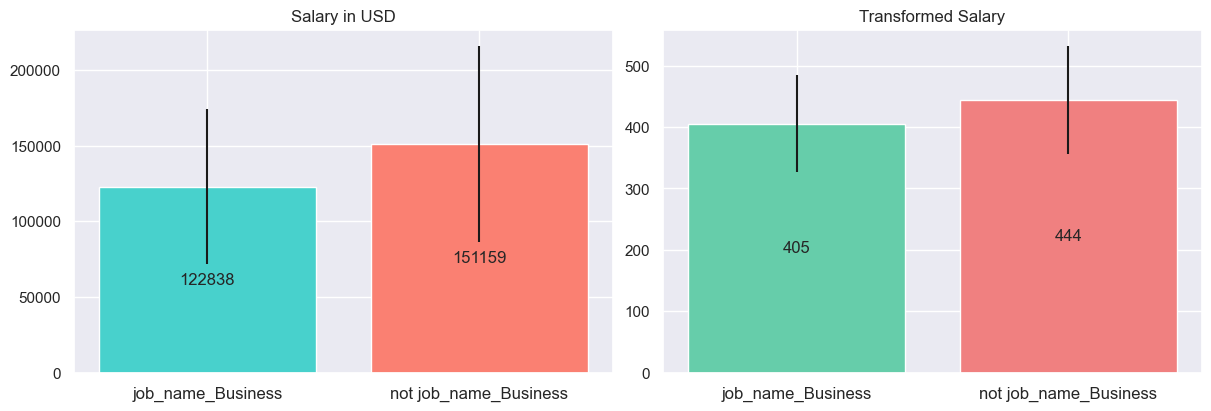

salary_in_usd               transformed_salary    
                        mean    std  count               mean std
job_name_Cloud                                                   
0                     149888  64452  14401                442  88
1                     153219  49975     19                451  66

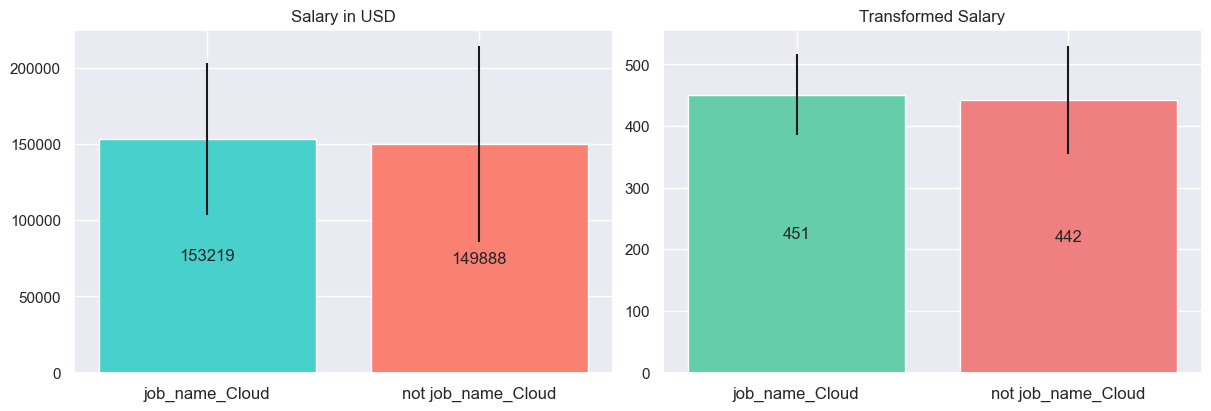

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Modeler                                                   
0                       149963  64487  14372                442  88
1                       128646  41086     48                417  60

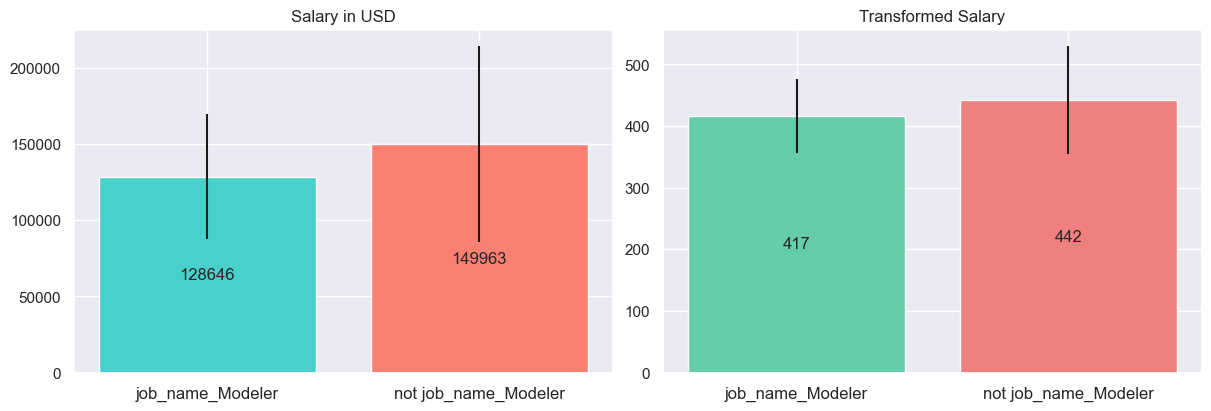

salary_in_usd              transformed_salary    
                           mean    std count               mean std
job_name_Engineer                                                  
0                        141865  63219  8352                431  88
1                        160941  64460  6068                458  85

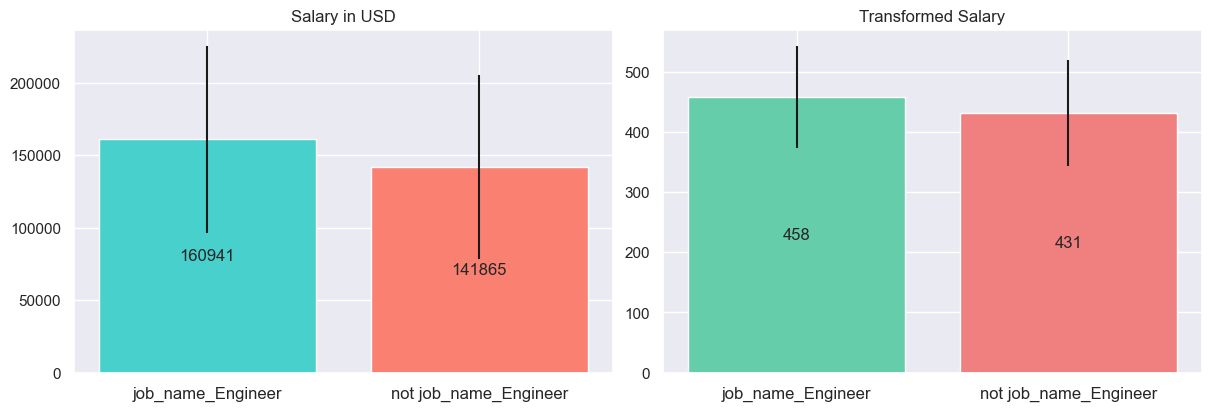

salary_in_usd               transformed_salary     
                          mean    std  count               mean  std
job_name_Finance                                                    
0                       149911  64414  14413                442   87
1                       112471  97906      7                374  130

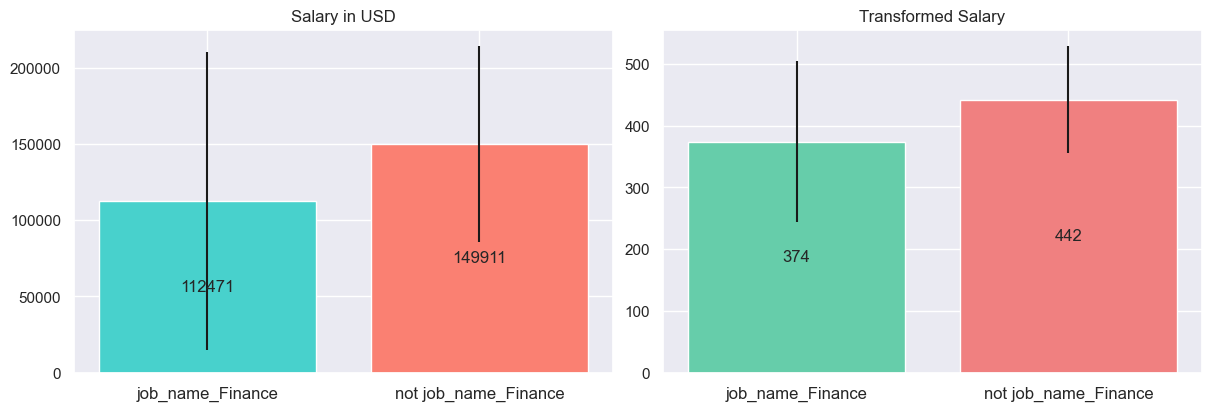

salary_in_usd               transformed_salary     
                           mean    std  count               mean  std
job_name_Research                                                    
0                        148118  62805  13550                440   86
1                        177522  81087    870                475  100

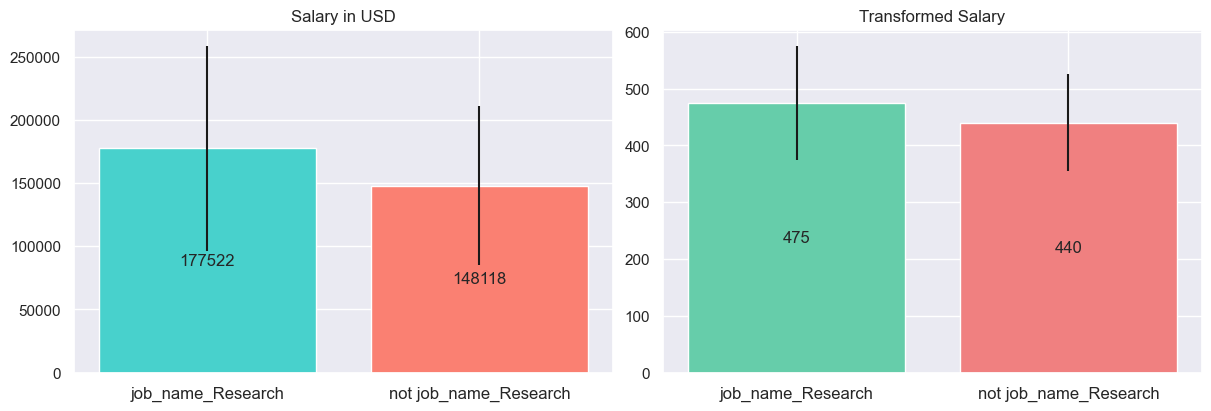

salary_in_usd              transformed_salary    
                            mean    std count               mean std
job_name_Scientist                                                  
0                         144007  64017  9905                434  88
1                         162805  63464  4515                460  84

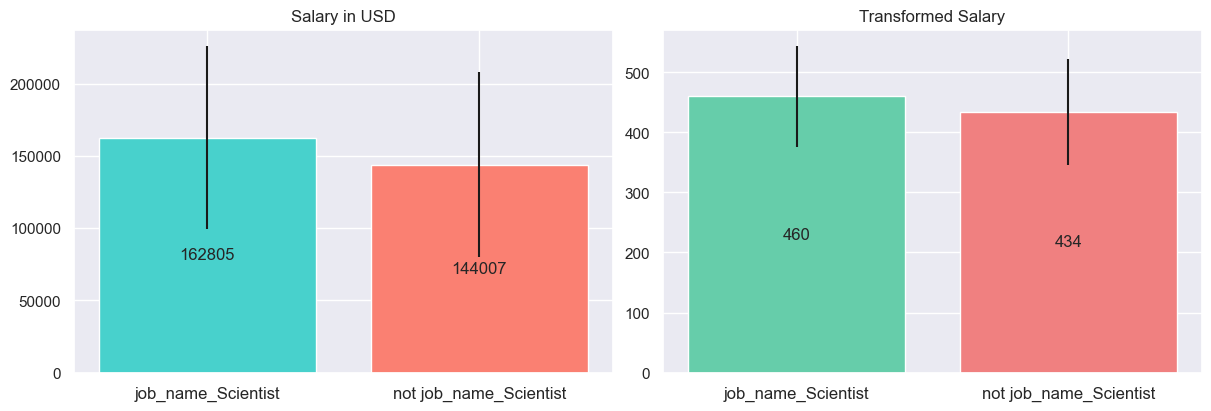

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
job_name_Strategist                                                   
0                          149975  64440  14392                442  88
1                          107593  45466     28                384  63

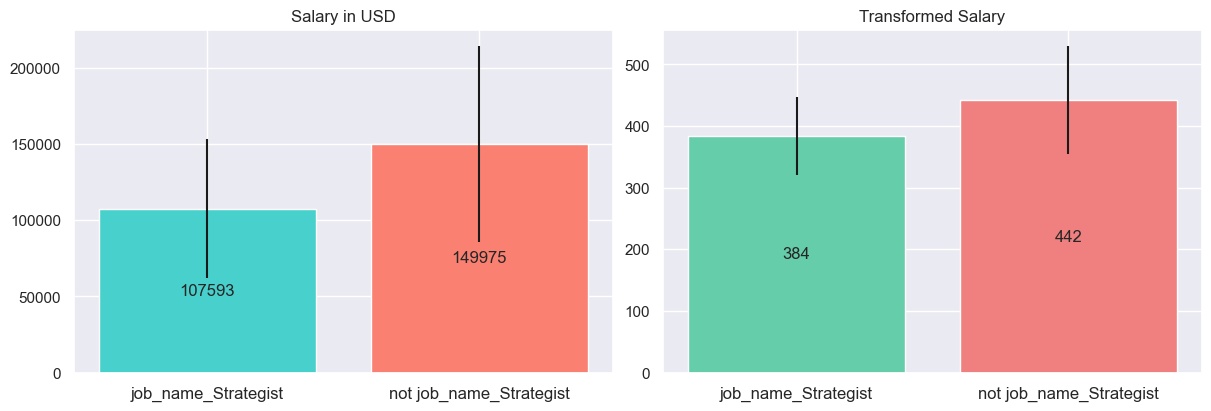

salary_in_usd               transformed_salary    
                          mean    std  count               mean std
job_name_Manager                                                   
0                       150266  64500  13981                442  88
1                       137980  61190    439                426  84

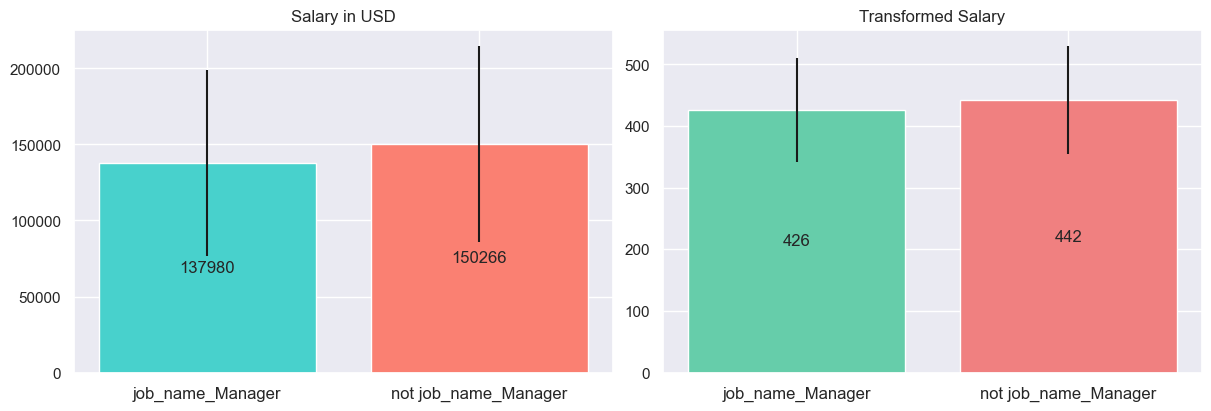

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_EN                                                   
0                          154431  63411  13349                449  84
1                           93324  48245   1071                354  81

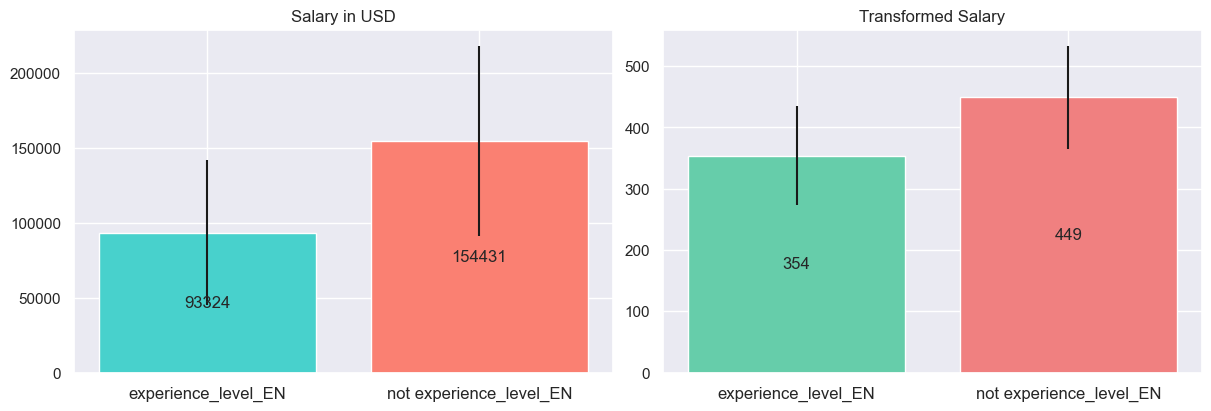

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_EX                                                   
0                          148524  63746  13991                440  87
1                          194529  70611    429                500  84

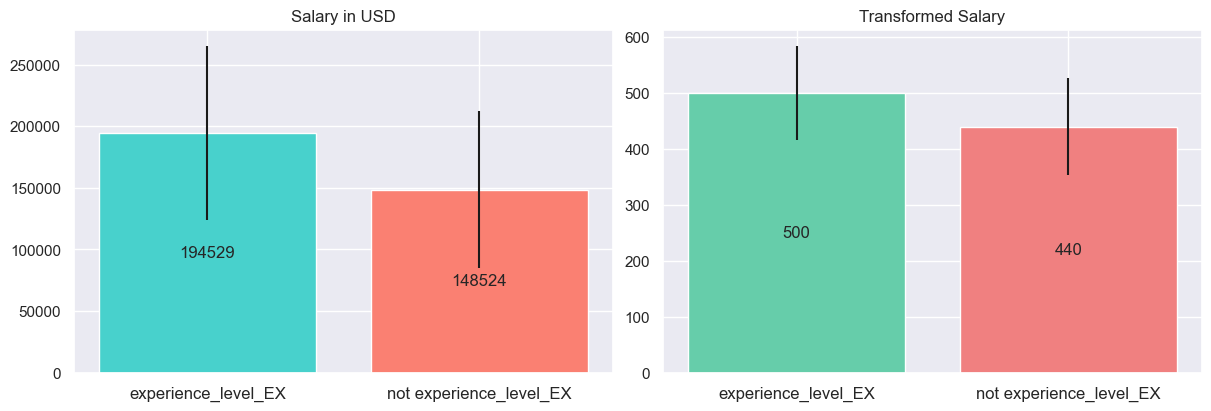

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
experience_level_MI                                                   
0                          157818  64263  11011                453  86
1                          124294  58014   3409                405  84

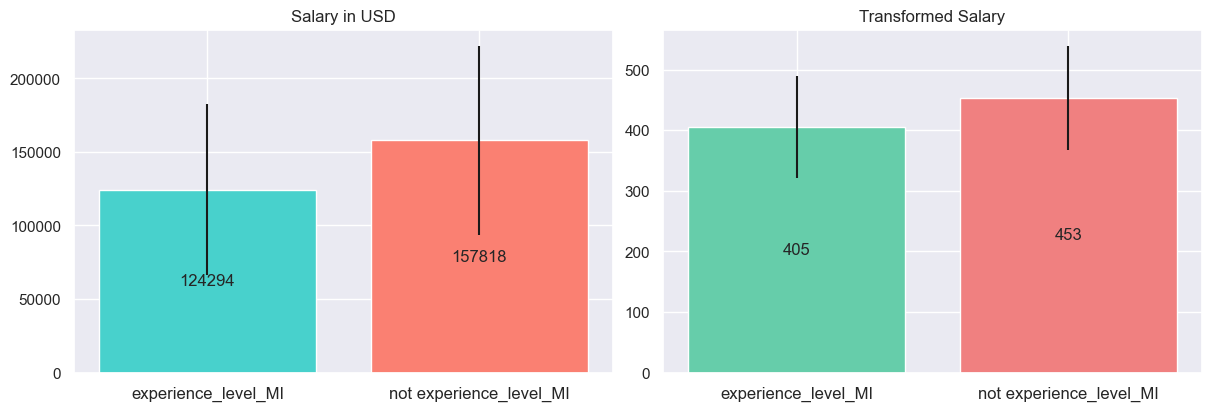

salary_in_usd              transformed_salary    
                             mean    std count               mean std
experience_level_SE                                                  
0                          123675  62605  4909                403  91
1                          163424  61109  9511                462  78

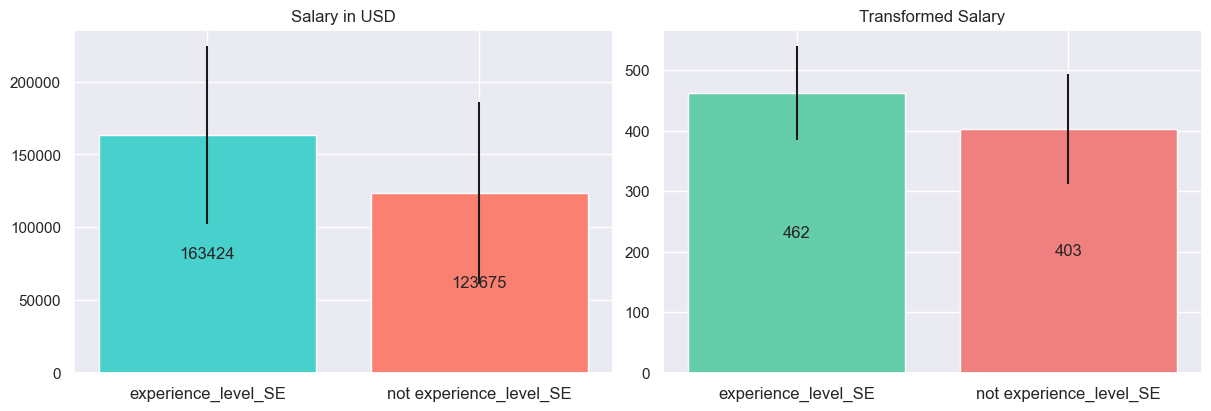

salary_in_usd                transformed_salary     
                            mean     std  count               mean  std
employment_type_CT                                                     
0                         149938   64359  14398                442   87
1                         120154  100501     22                382  134

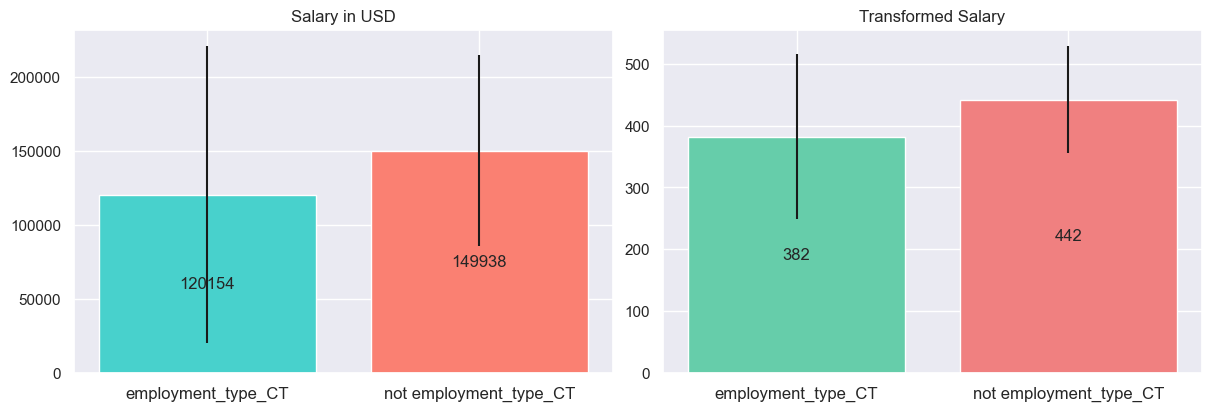

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
employment_type_FL                                                   
0                         149942  64409  14413                442  87
1                          48646  26666      7                265  64

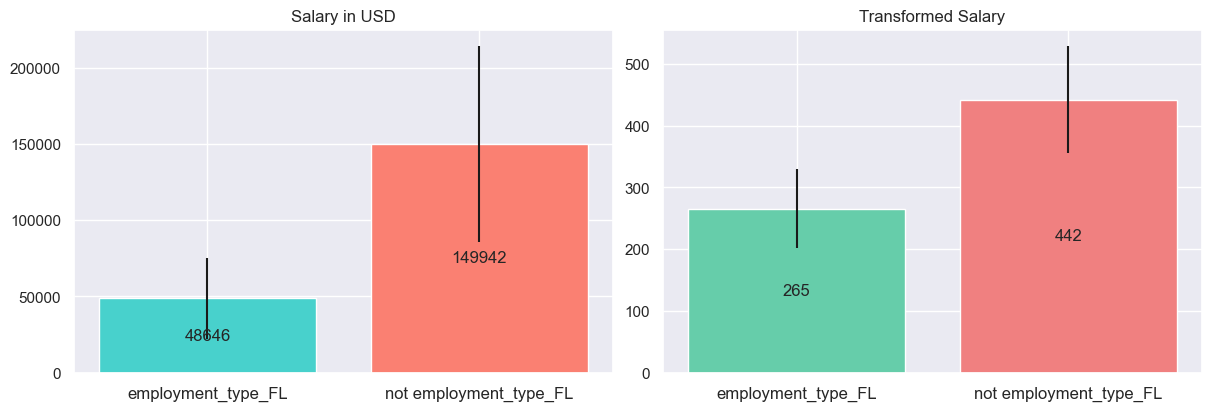

salary_in_usd               transformed_salary     
                            mean    std  count               mean  std
employment_type_FT                                                    
0                          86786  80043     47                327  121
1                         150099  64279  14373                442   87

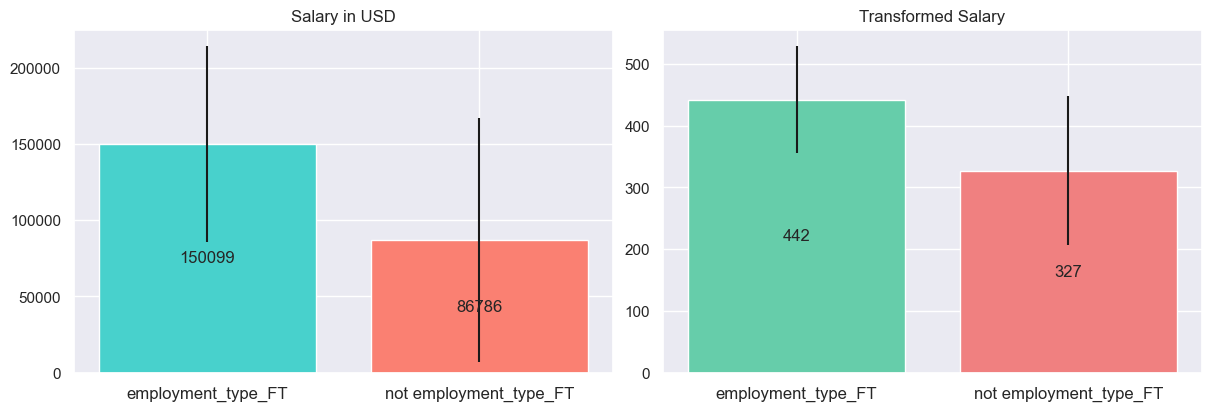

salary_in_usd               transformed_salary    
                            mean    std  count               mean std
employment_type_PT                                                   
0                         150004  64381  14402                442  87
1                          60835  43073     18                285  93

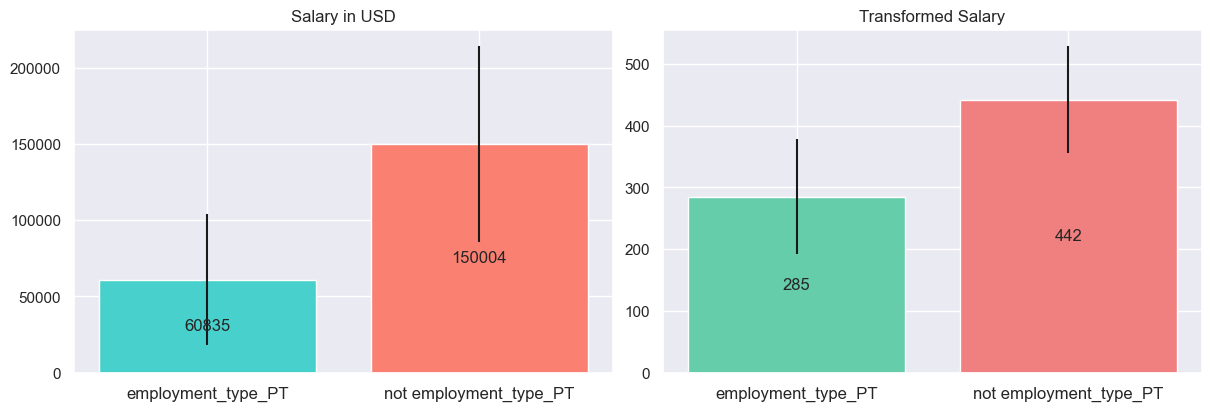

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_AUD                                                   
0                          149946  64426  14409                442  87
1                           79662  27474     11                336  52

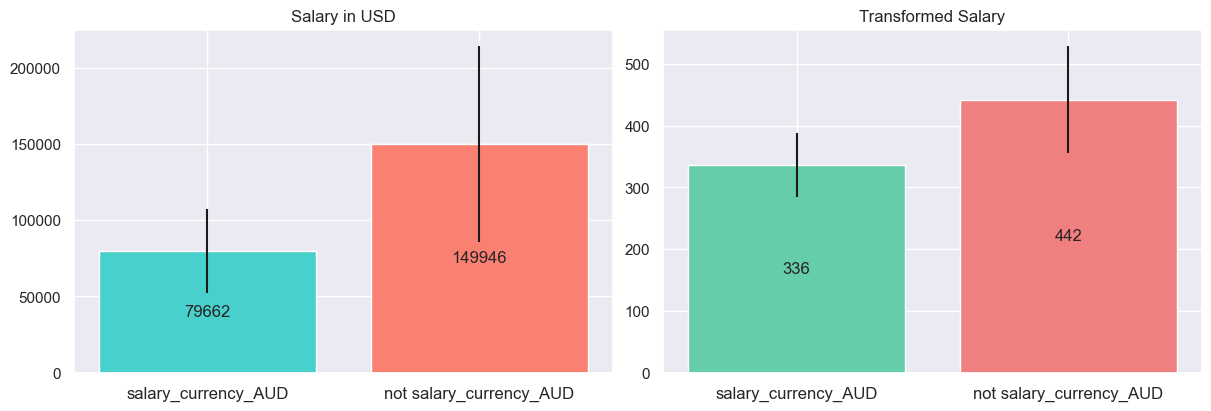

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_CAD                                                   
0                          150032  64427  14372                442  87
1                          108122  52213     48                381  79

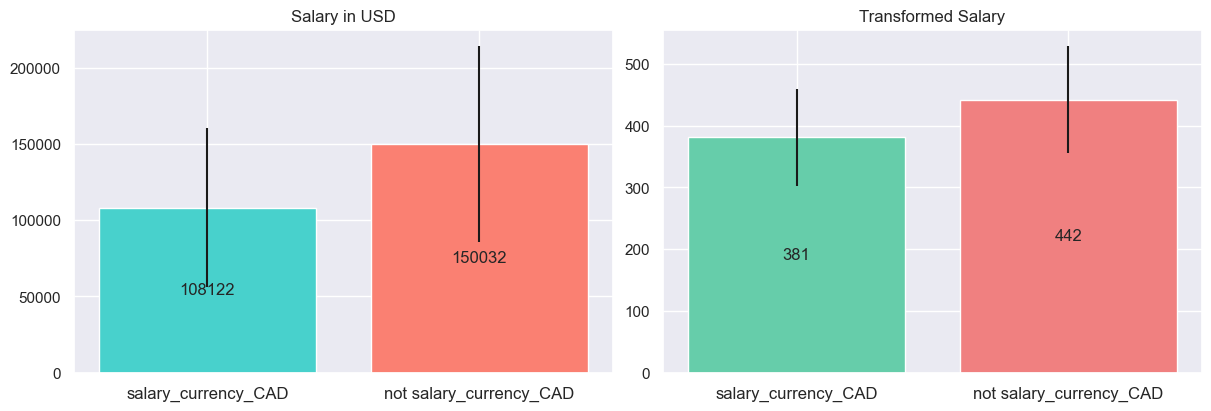

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
salary_currency_CHF                                                    
0                          149899  64426  14413                442   87
1                          137305  85486      7                421  105

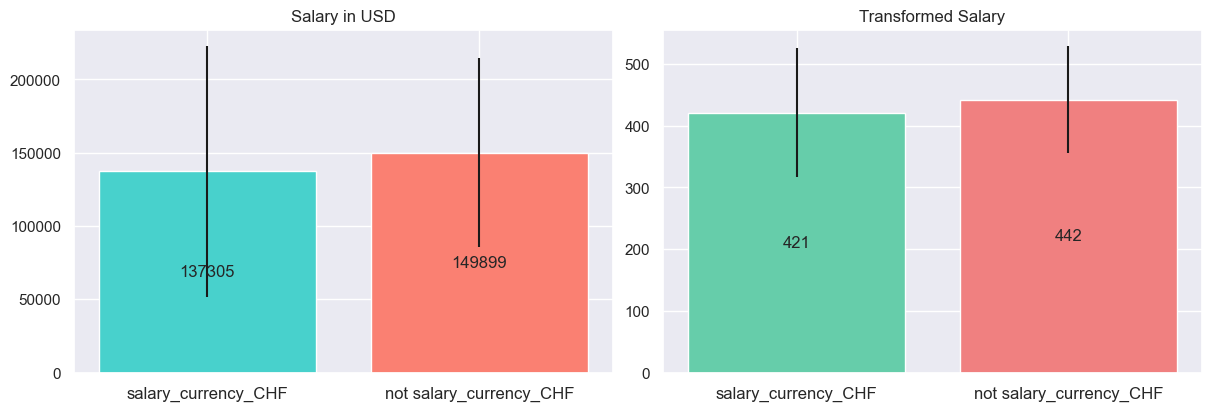

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_EUR                                                   
0                          152305  63454  14025                446  85
1                           64224  32542    395                301  62

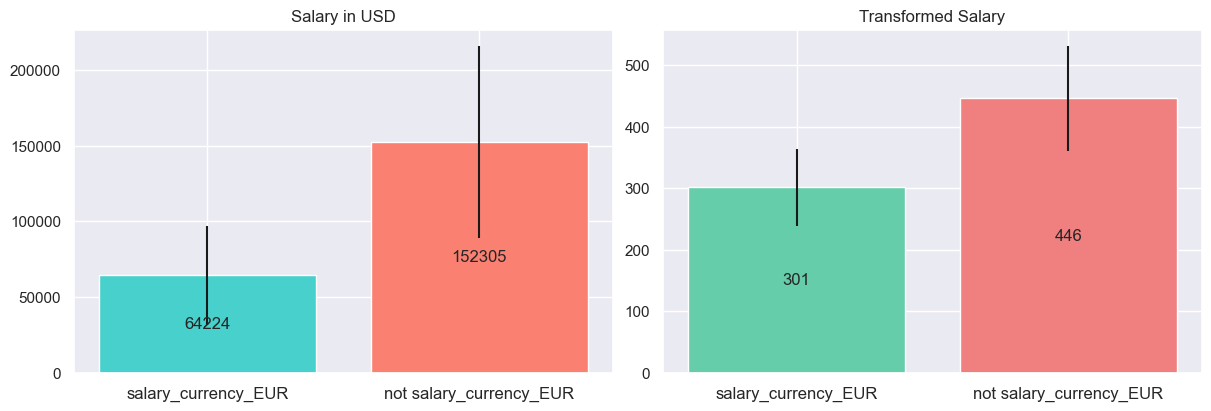

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_GBP                                                   
0                          152629  63483  13869                446  85
1                           81013  47802    551                333  73

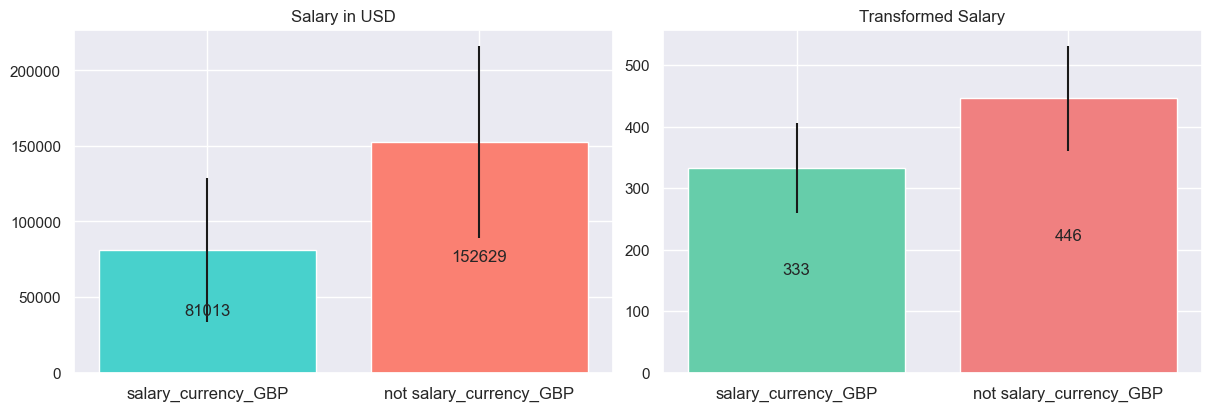

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_INR                                                   
0                          150288  64177  14371                443  87
1                           33910  19277     49                224  53

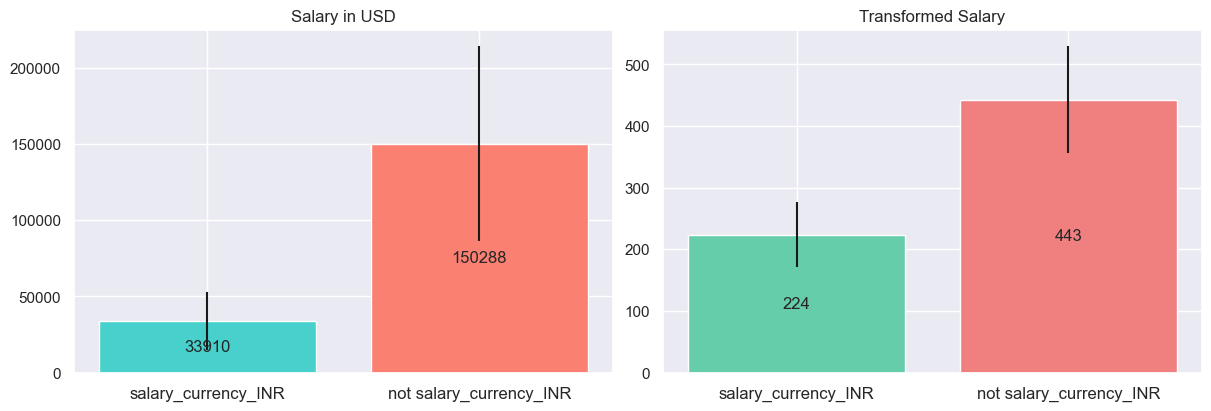

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_PLN                                                   
0                          149940  64406  14414                442  87
1                           36295  11609      6                236  37

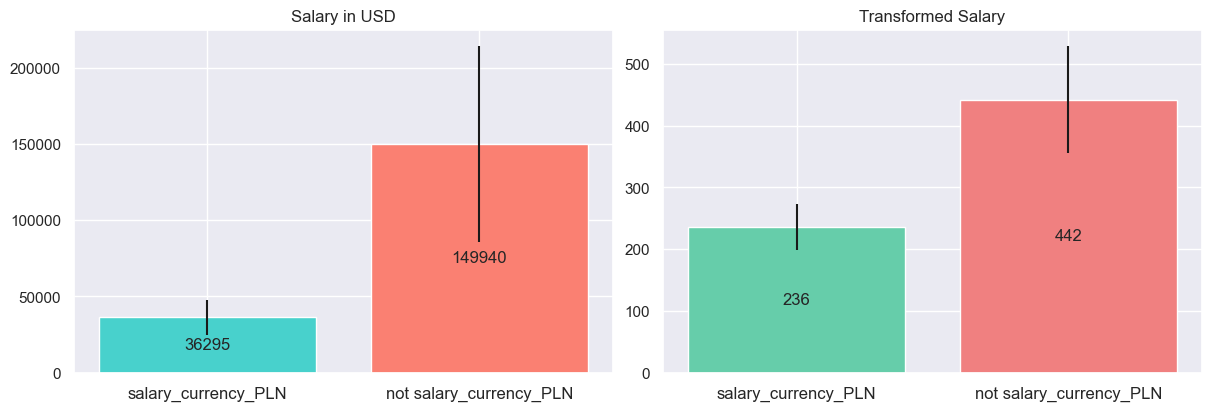

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
salary_currency_USD                                                   
0                           73958  44474   1067                319  74
1                          155960  61871  13353                452  81

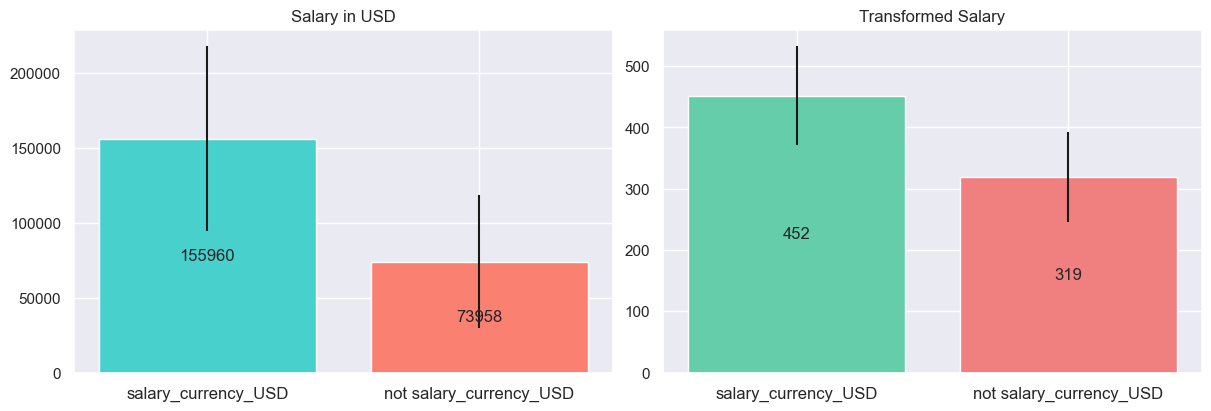

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_AR                                                   
0                            149959  64412  14409                442  87
1                             62272  18504     11                302  42

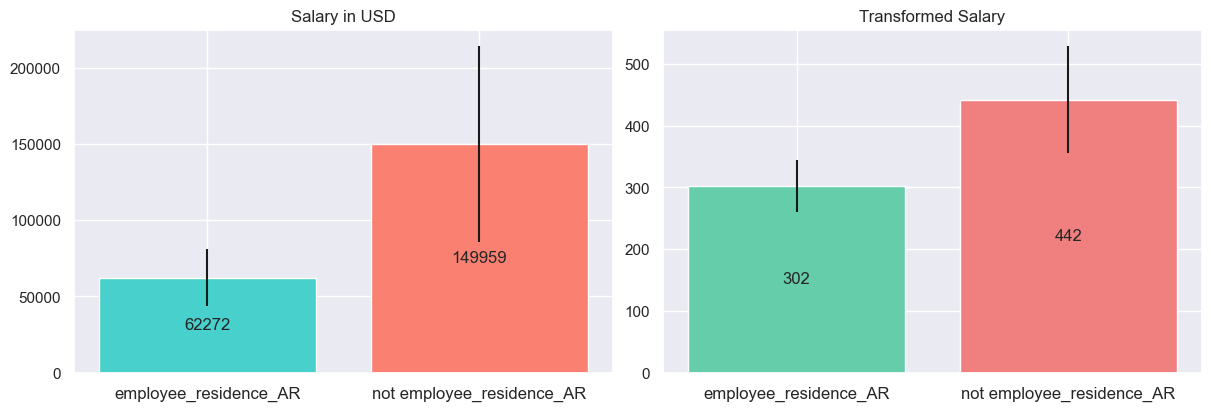

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_AT                                                   
0                            149949  64420  14410                442  87
1                             68378  15101     10                316  31

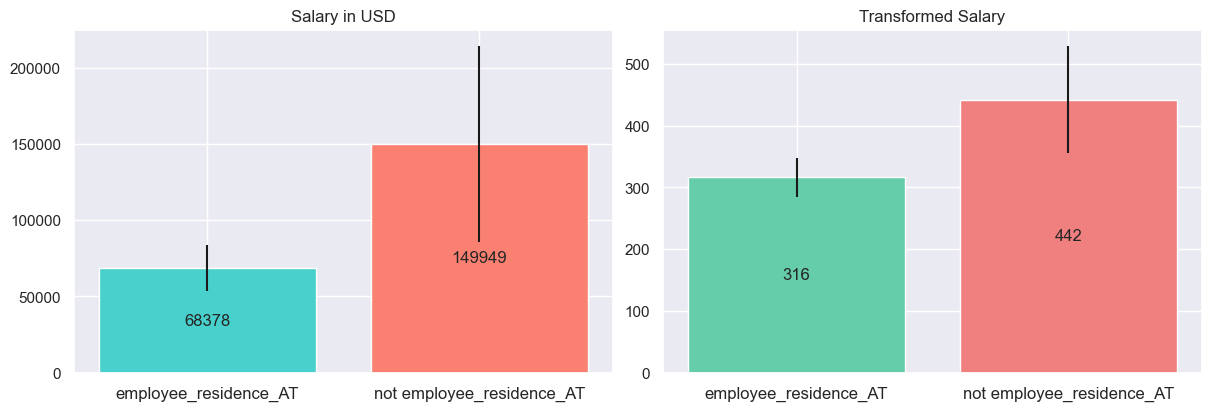

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_AU                                                    
0                            149932  64399  14374                442   87
1                            137401  74486     46                420  104

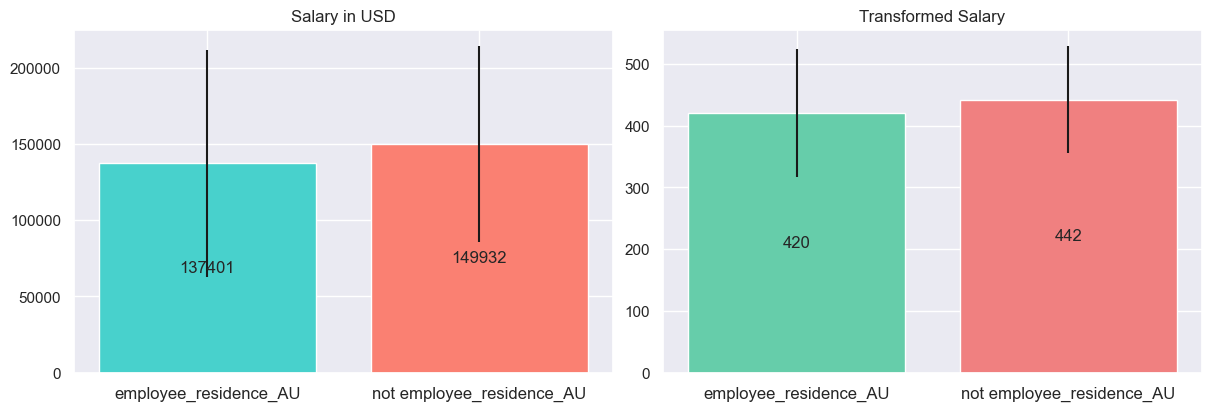

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_BR                                                   
0                            149982  64411  14403                442  87
1                             74411  32850     17                323  63

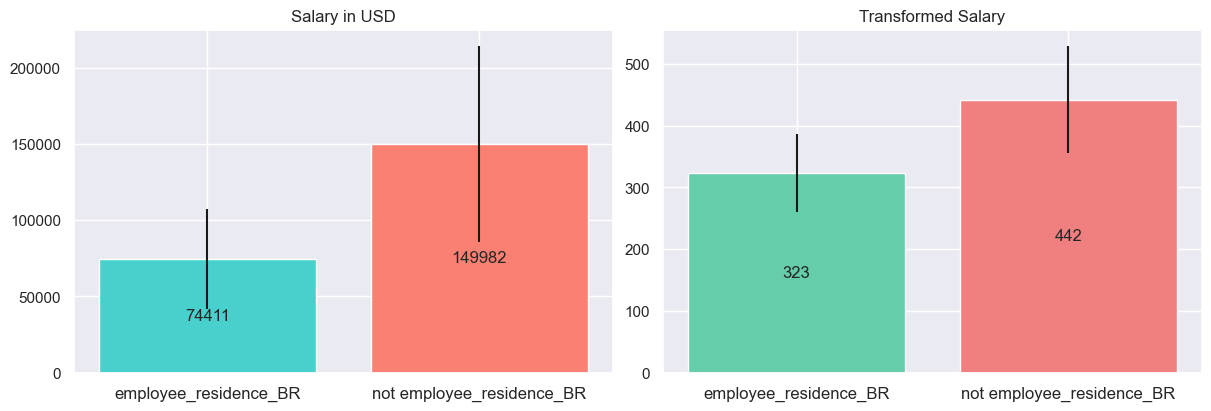

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_CA                                                   
0                            150030  64571  14047                442  88
1                            144697  58897    373                436  80

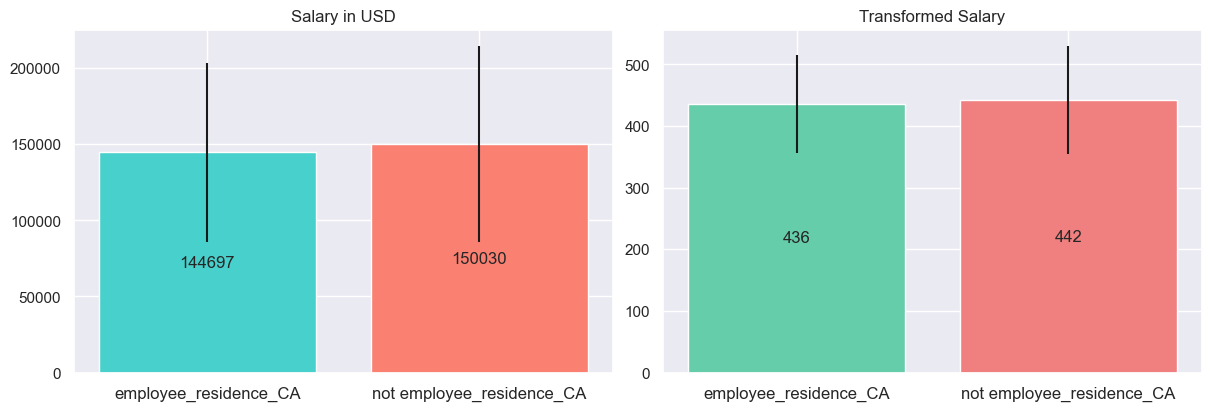

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_CH                                                    
0                            149899  64426  14413                442   87
1                            137305  85486      7                421  105

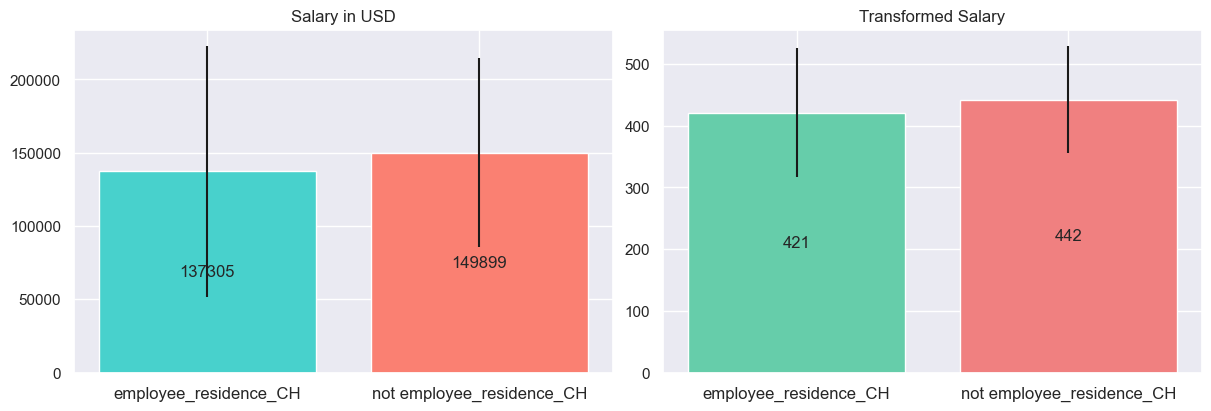

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_CO                                                   
0                            149971  64420  14404                442  87
1                             79115  30019     16                334  60

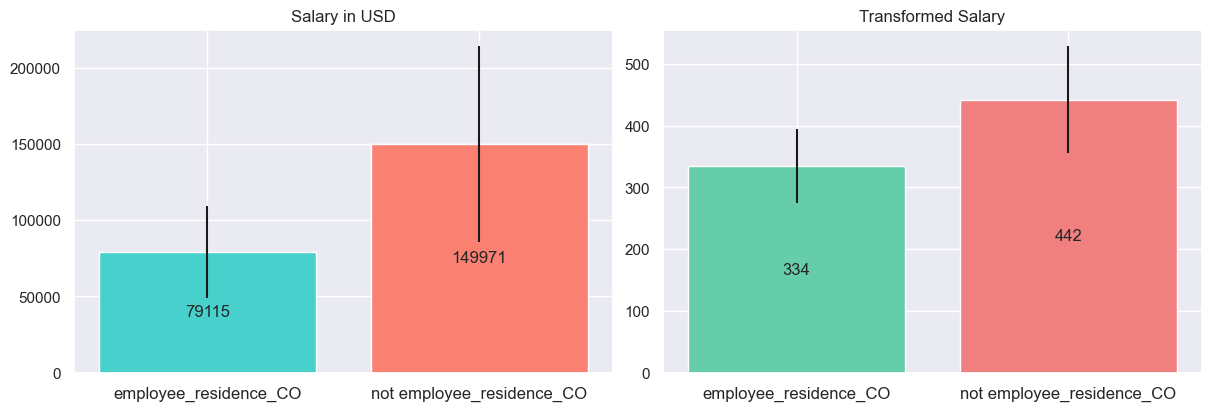

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_DE                                                   
0                            150208  64364  14332                442  87
1                             98470  54835     88                362  87

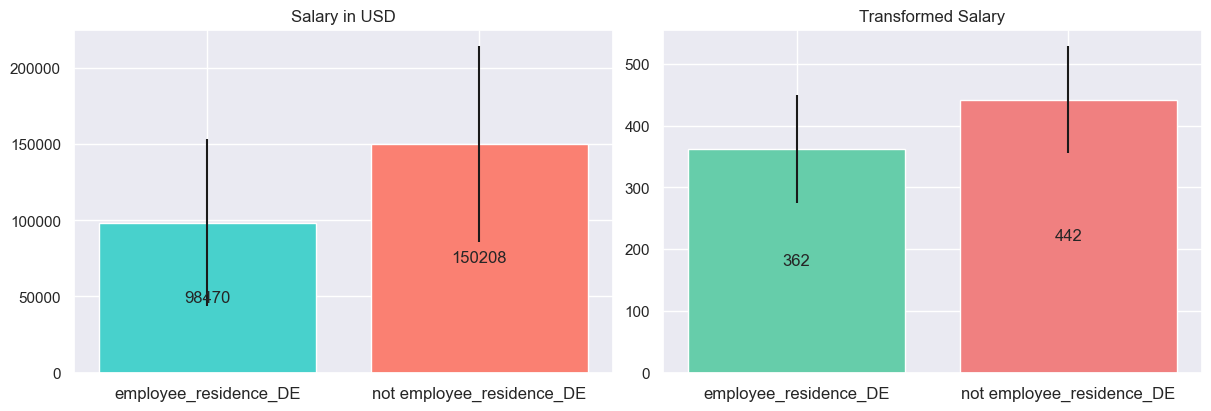

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_EE                                                   
0                            149973  64392  14409                442  87
1                             43941   8749     11                260  23

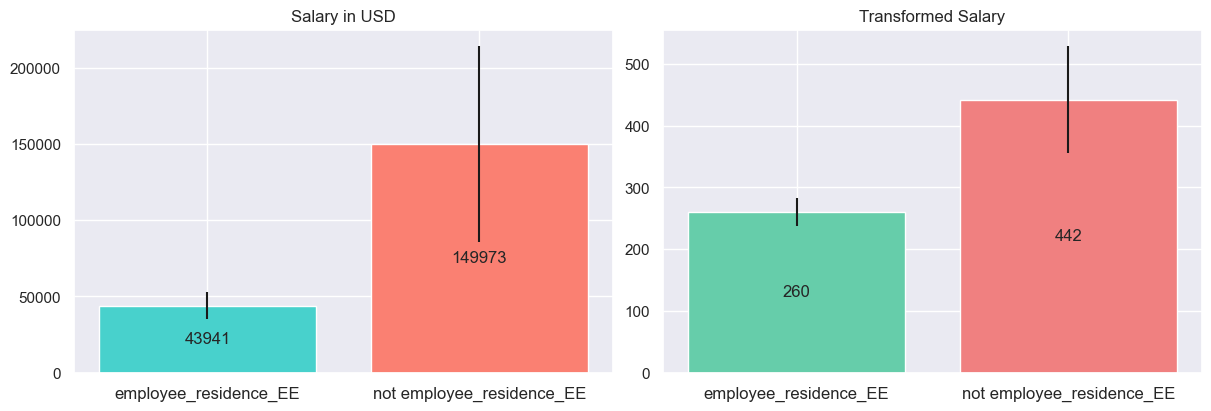

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_EG                                                    
0                            149906  64429  14406                442   87
1                            135807  70464     14                417  108

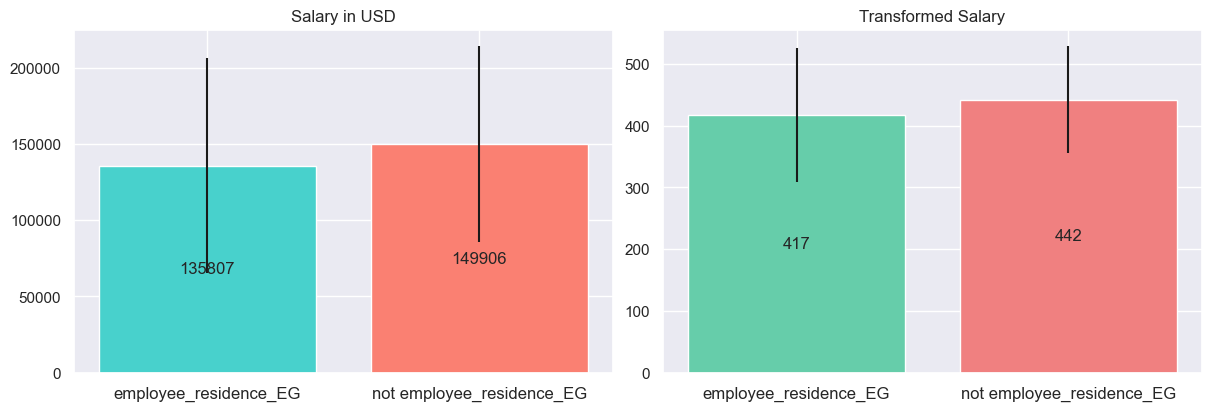

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_ES                                                   
0                            150709  64044  14292                443  86
1                             58668  36987    128                288  65

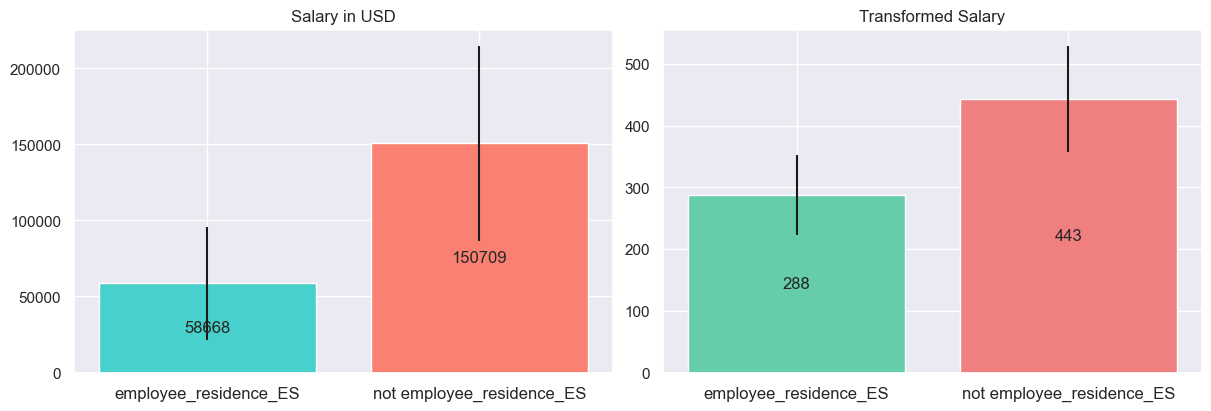

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_FR                                                   
0                            150175  64313  14356                442  87
1                             86612  60853     64                338  94

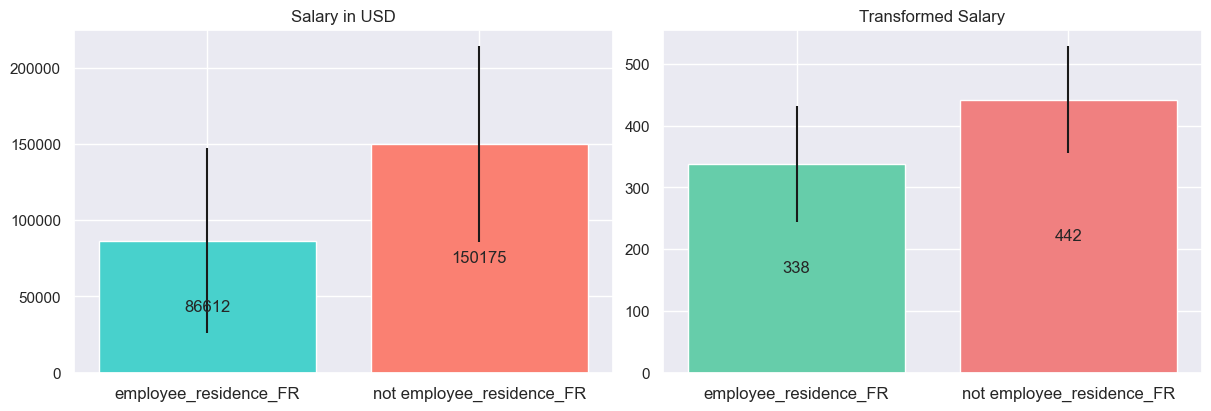

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_GB                                                   
0                            152396  63618  13783                446  86
1                             95725  57880    637                357  87

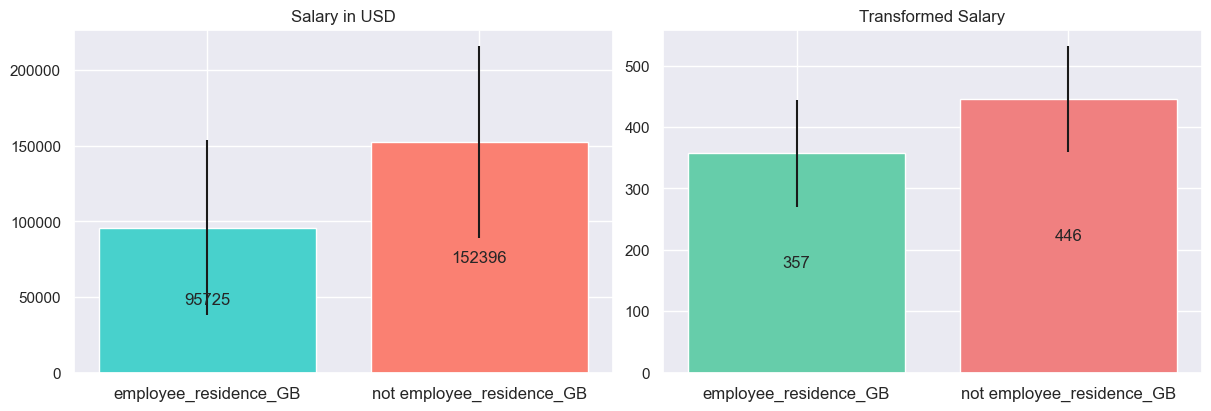

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_GR                                                   
0                            150002  64383  14404                442  87
1                             51692  21262     16                274  54

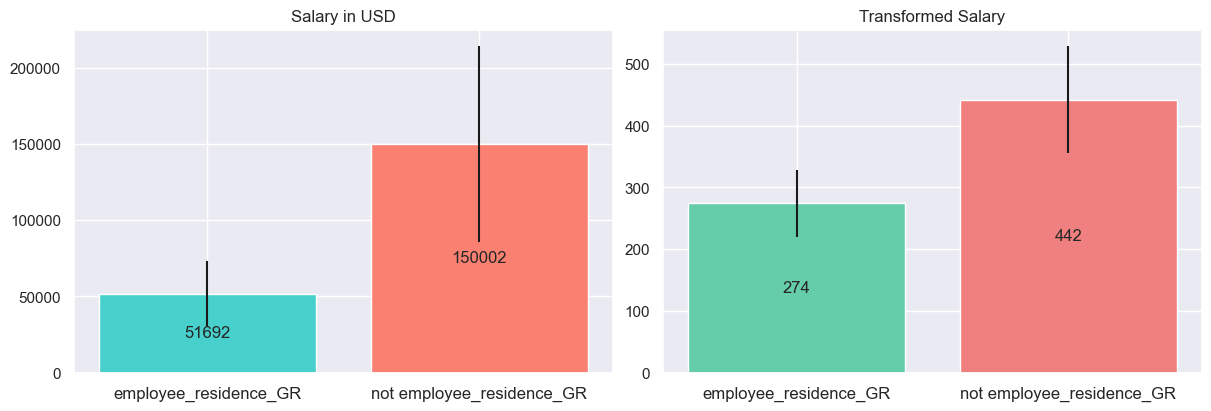

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IE                                                   
0                            149930  64441  14408                442  88
1                            104694  33896     12                381  52

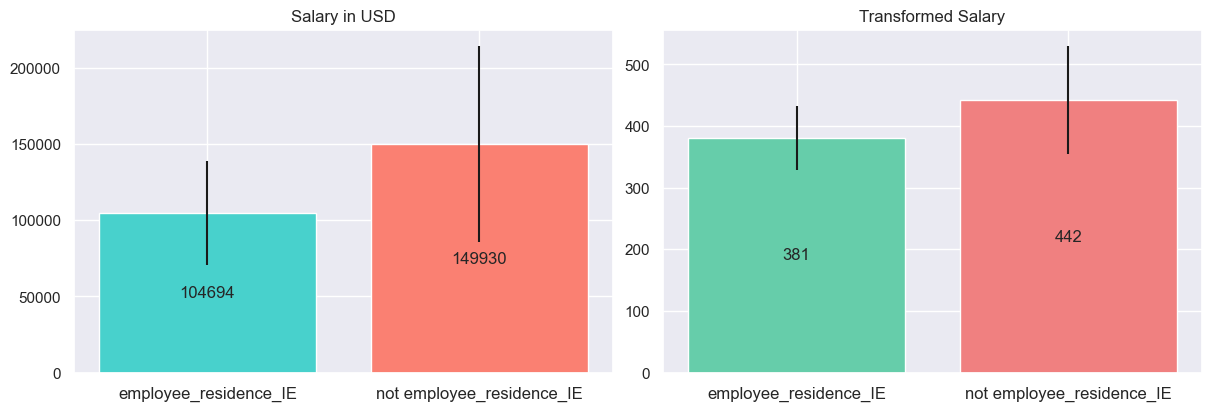

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IN                                                   
0                            150364  64148  14354                443  87
1                             47248  39994     66                252  85

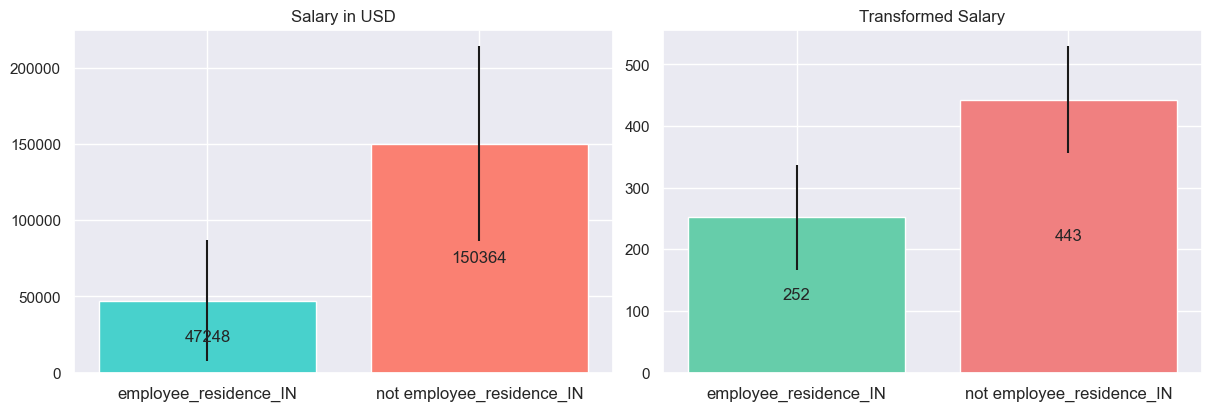

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_IT                                                   
0                            150031  64369  14399                442  87
1                             54867  30538     21                279  66

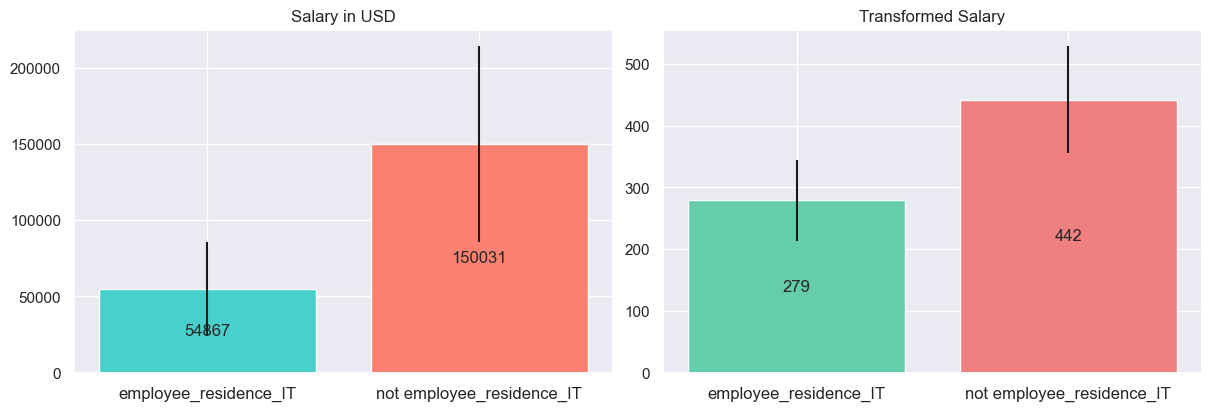

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_LT                                                   
0                            149983  64406  14404                442  87
1                             68553  29287     16                312  59

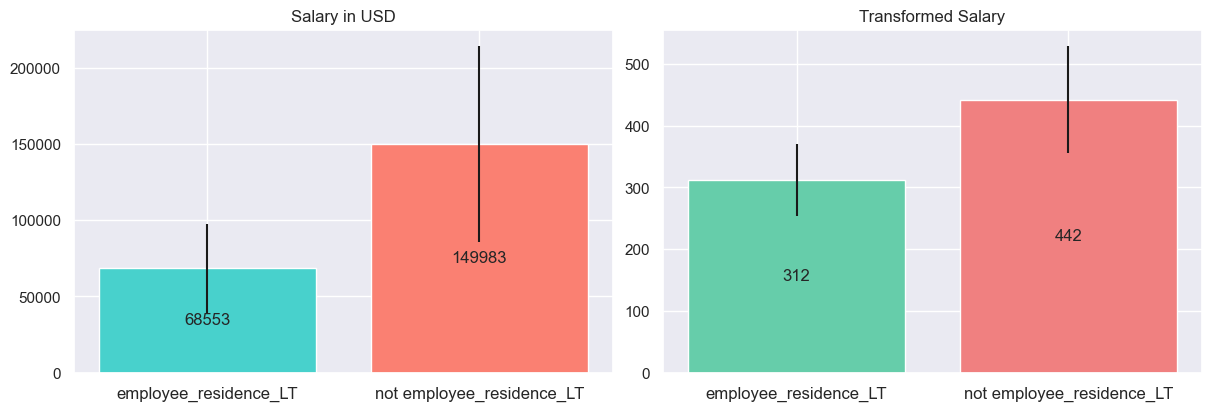

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_LV                                                   
0                            149985  64394  14406                442  87
1                             54734  19875     14                284  45

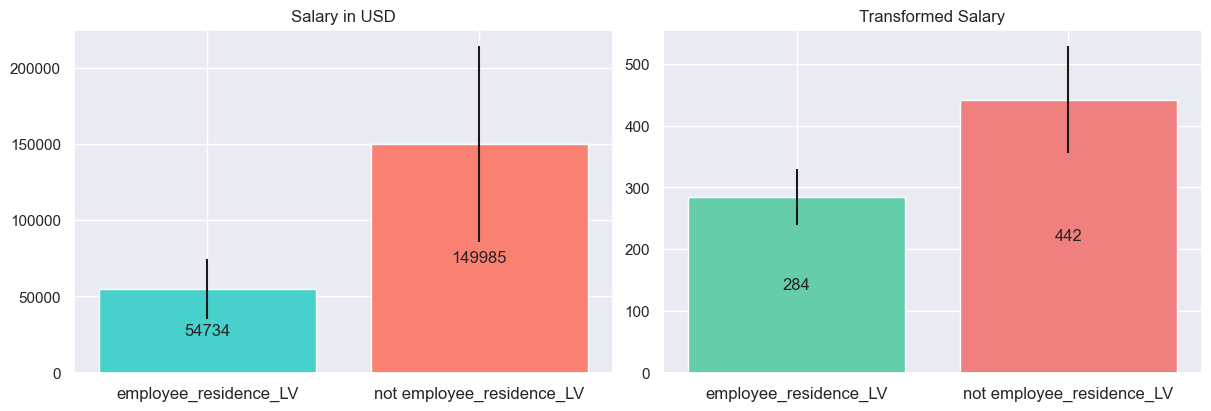

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_MX                                                    
0                            149943  64406  14408                442   87
1                             89258  72868     12                333  126

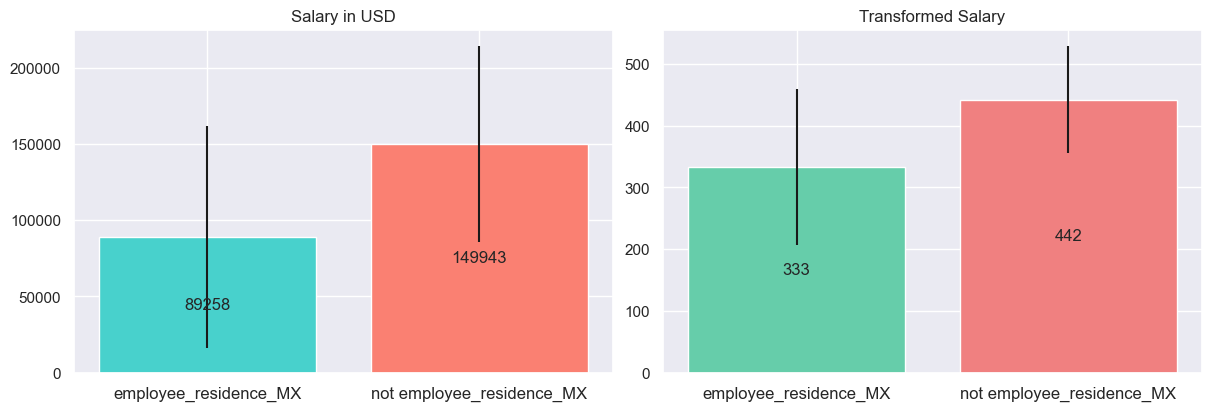

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NG                                                   
0                            149974  64385  14408                442  87
1                             52416  49059     12                264  92

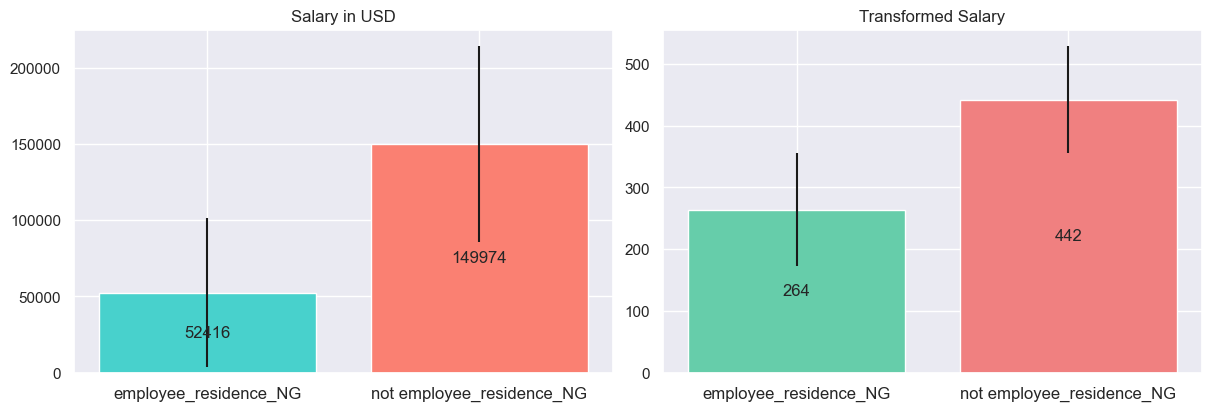

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NL                                                   
0                            150035  64404  14392                442  87
1                             76752  28581     28                330  55

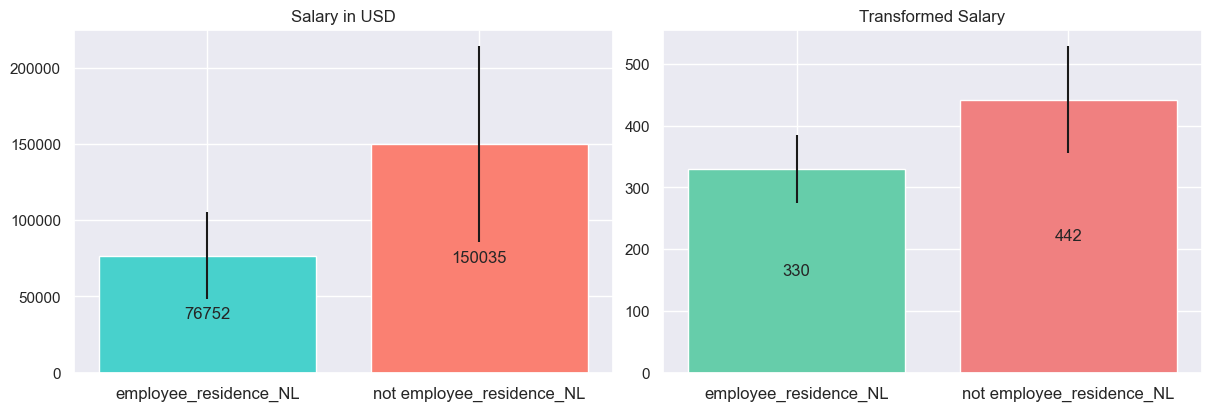

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_NZ                                                   
0                            149892  64443  14415                442  88
1                            152218  35137      5                453  45

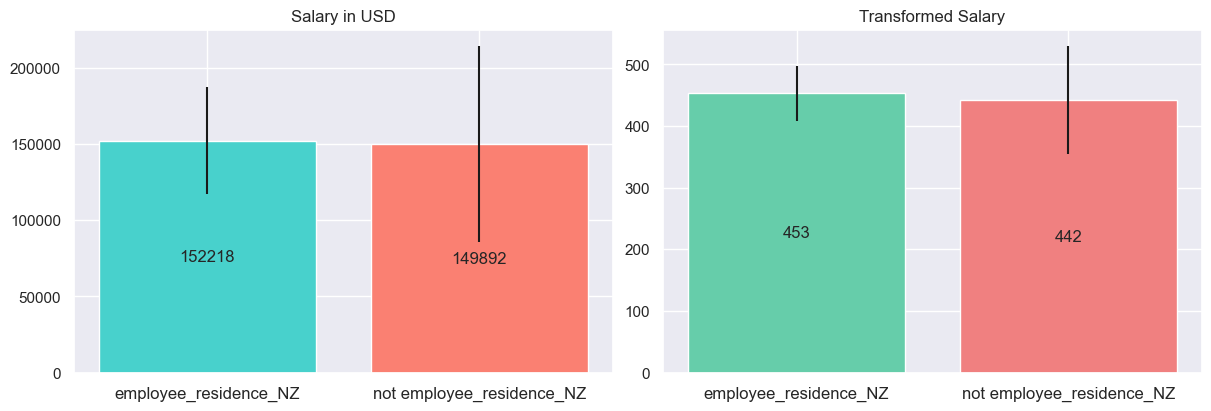

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_PH                                                   
0                            149940  64411  14413                442  87
1                             51337  24241      7                273  58

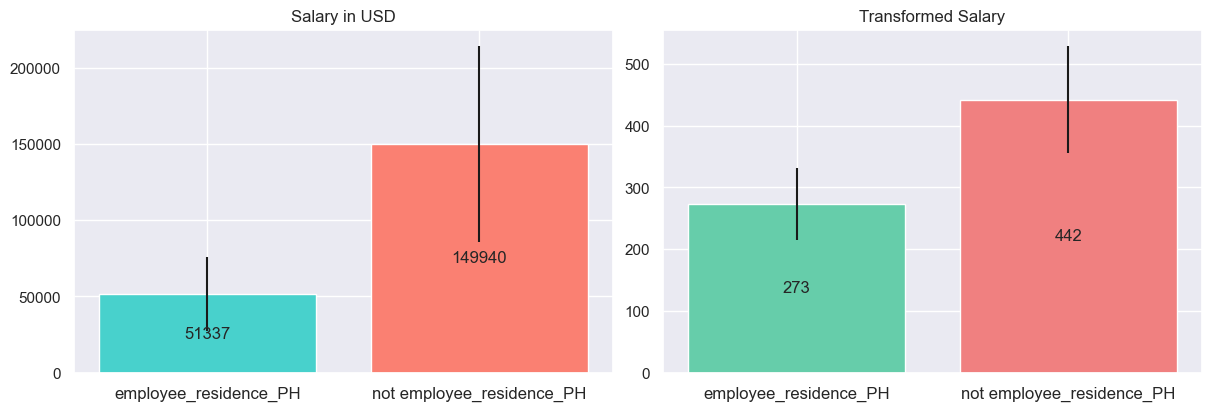

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_PL                                                    
0                            149961  64407  14406                442   87
1                             79055  54735     14                322  100

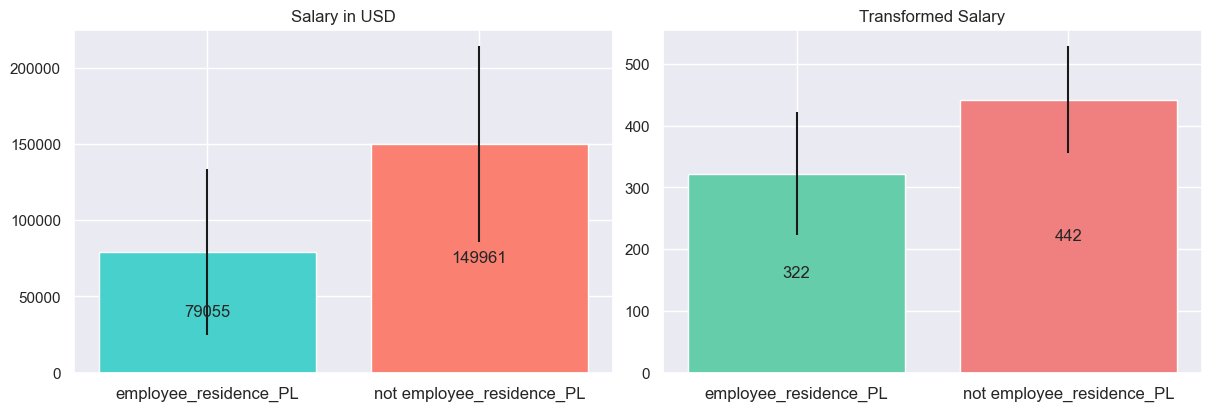

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_PT                                                   
0                            150093  64339  14390                442  87
1                             53920  28464     30                277  63

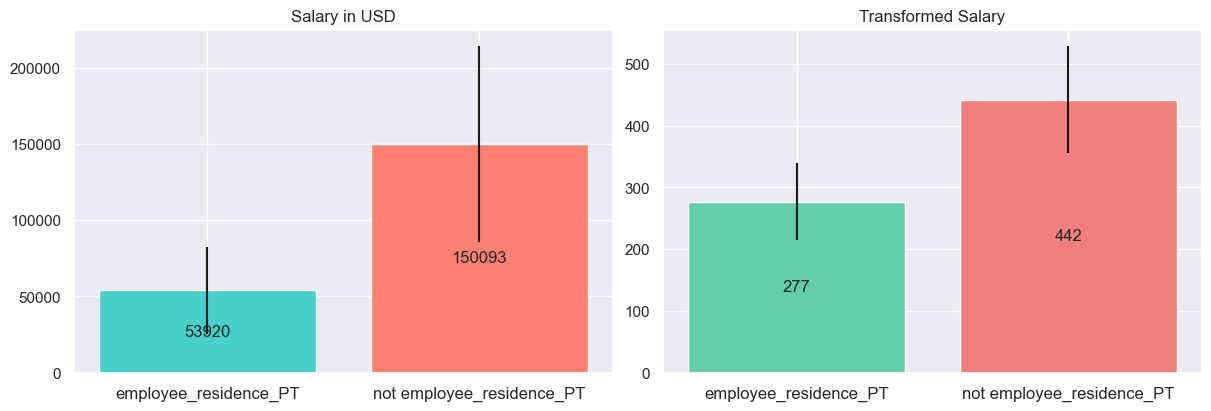

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_SI                                                   
0                            149931  64417  14414                442  87
1                             56186  28245      6                284  64

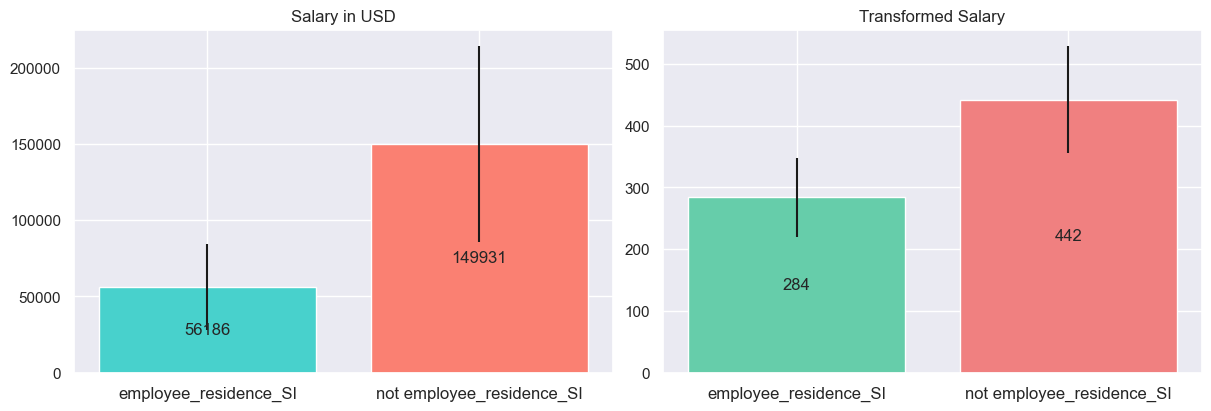

salary_in_usd               transformed_salary     
                               mean    std  count               mean  std
employee_residence_UA                                                    
0                            149932  64416  14409                442   87
1                             98272  71246     11                355  113

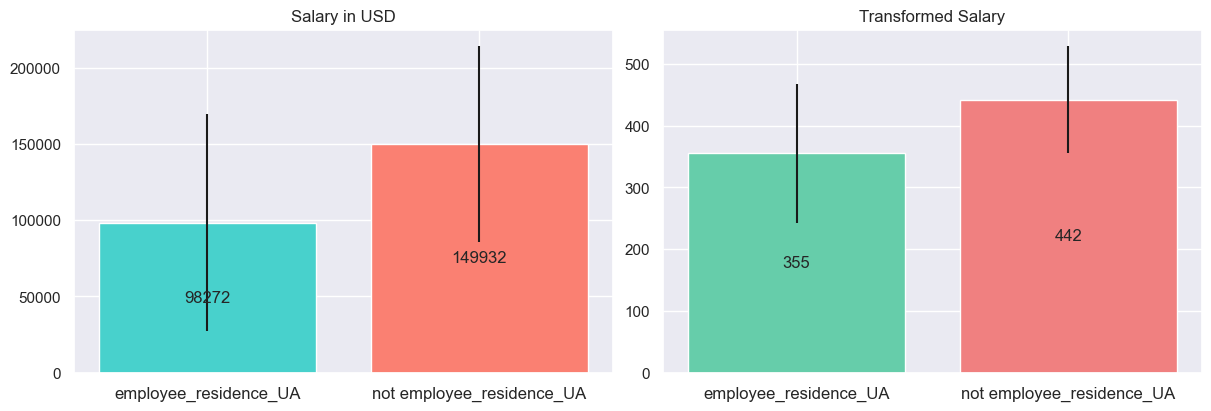

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_US                                                   
0                             98689  61881   1706                359  98
1                            156763  61614  12714                453  80

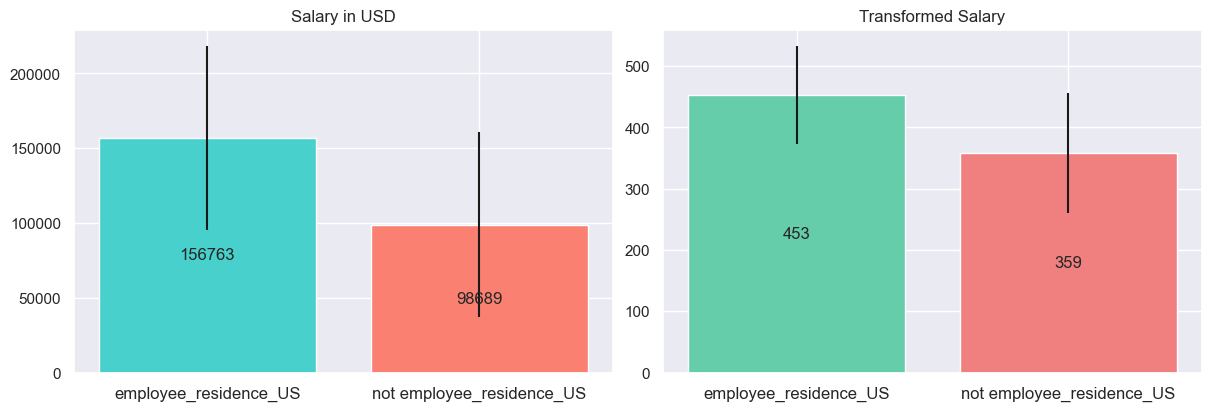

salary_in_usd               transformed_salary    
                               mean    std  count               mean std
employee_residence_ZA                                                   
0                            149982  64397  14406                442  87
1                             57308  24142     14                289  50

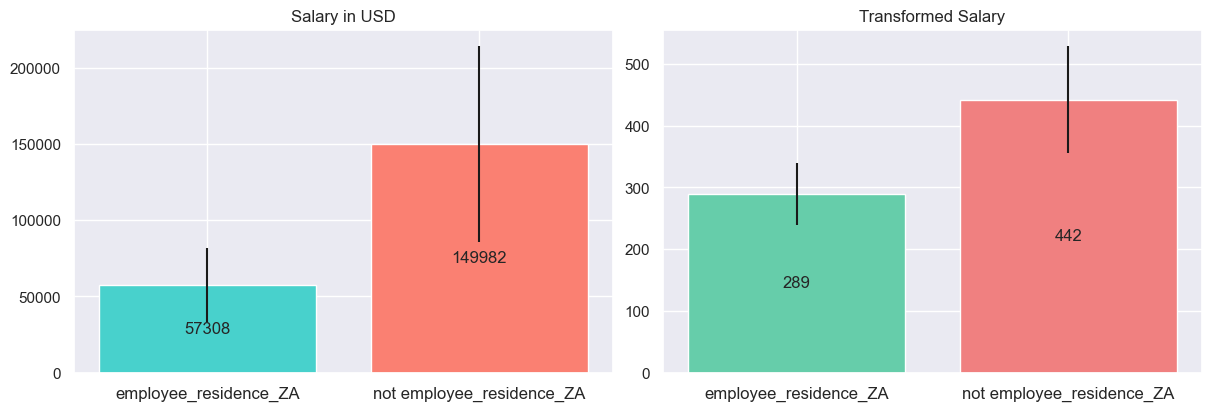

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
remote_ratio_Hybrid                                                    
0                          150779  63980  14221                443   86
1                           86502  65345    199                334  103

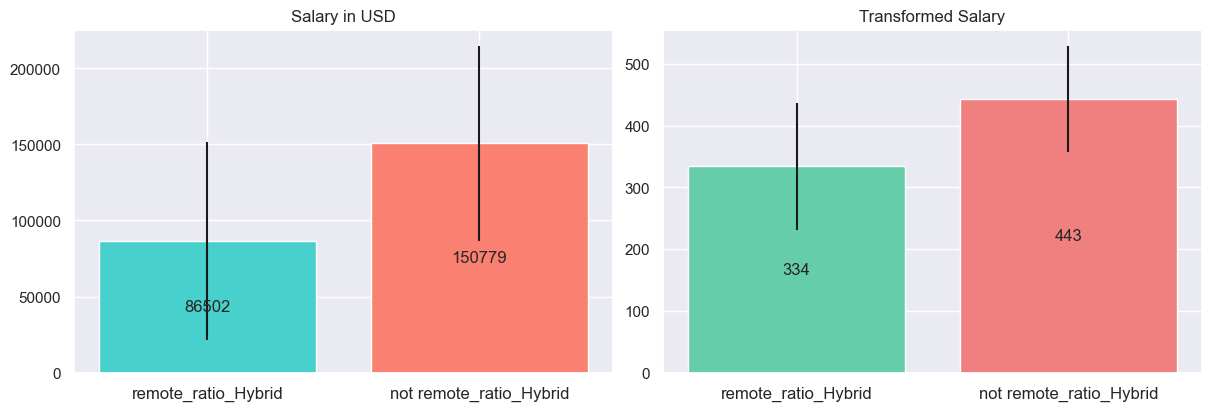

salary_in_usd              transformed_salary    
                              mean    std count               mean std
remote_ratio_On_Site                                                  
0                           143312  60932  4792                433  87
1                           153168  65867  9628                446  87

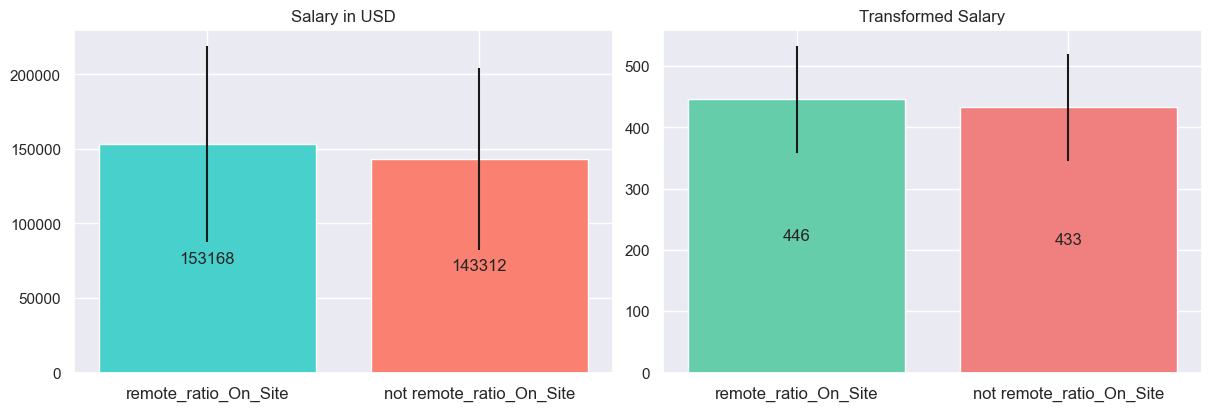

salary_in_usd              transformed_salary    
                             mean    std count               mean std
remote_ratio_Remote                                                  
0                          151818  66519  9827                444  89
1                          145773  59528  4593                437  84

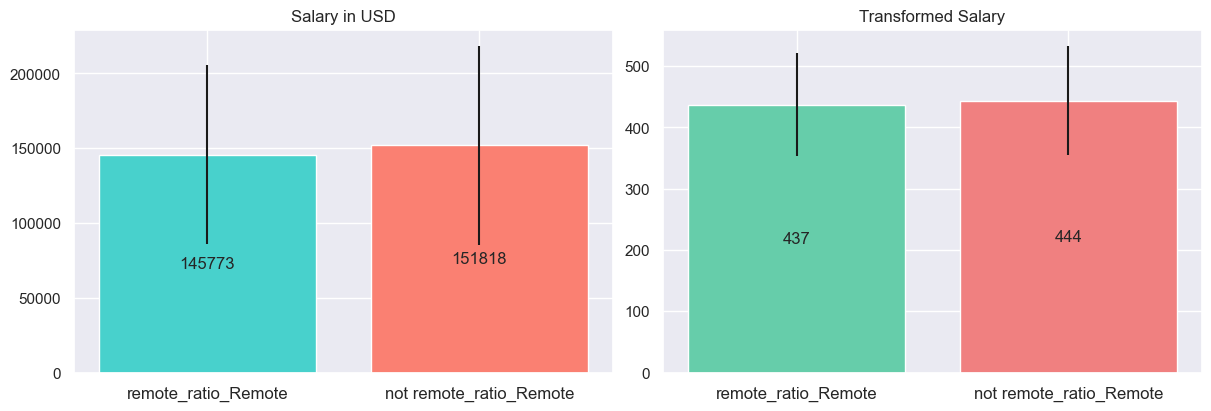

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_AR                                                   
0                          149931  64425  14413                442  87
1                           69571  17299      7                318  36

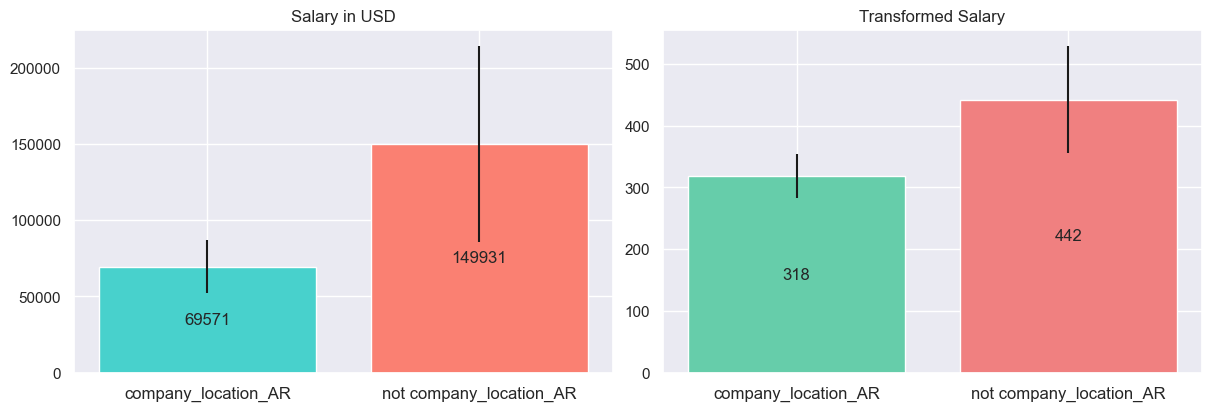

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_AT                                                   
0                          149949  64420  14410                442  87
1                           68479  15045     10                317  31

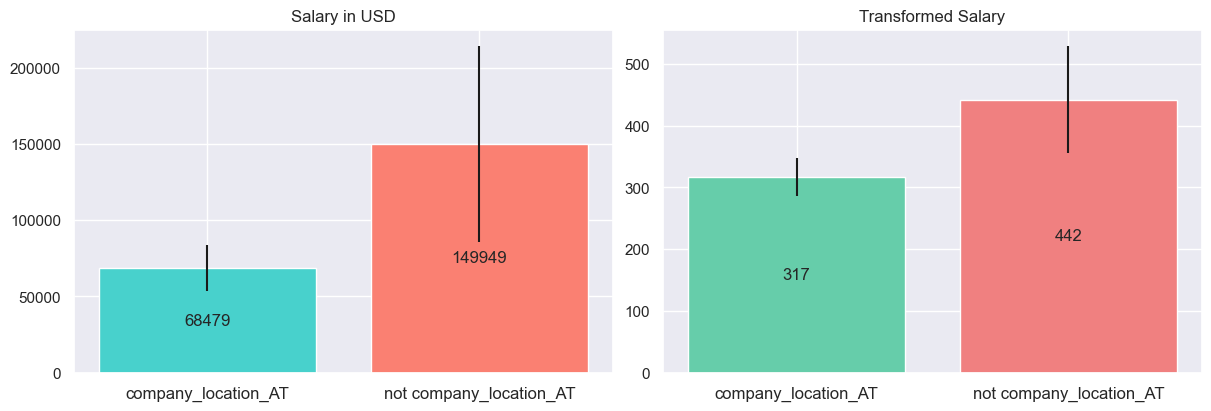

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_AU                                                    
0                          149938  64398  14372                442   87
1                          136280  74144     48                418  104

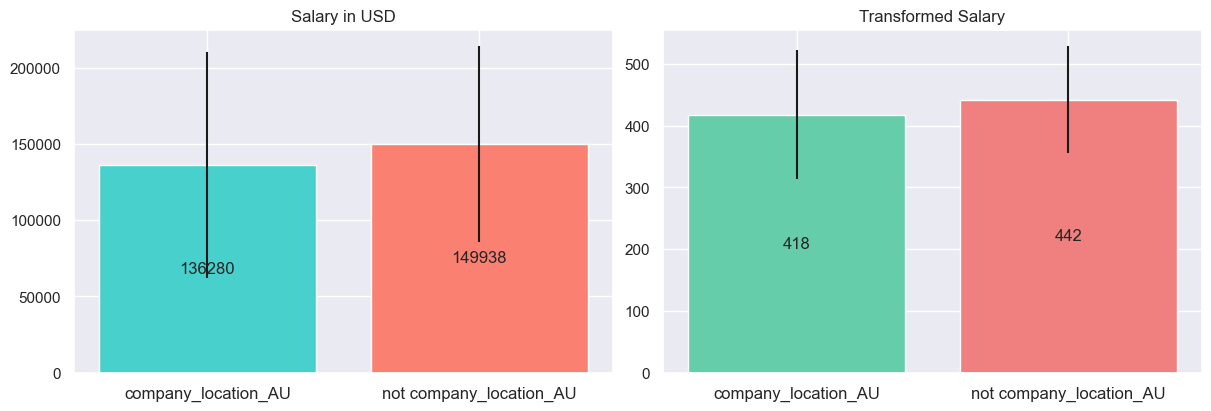

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_BR                                                   
0                          149979  64408  14405                442  87
1                           67000  24585     15                310  52

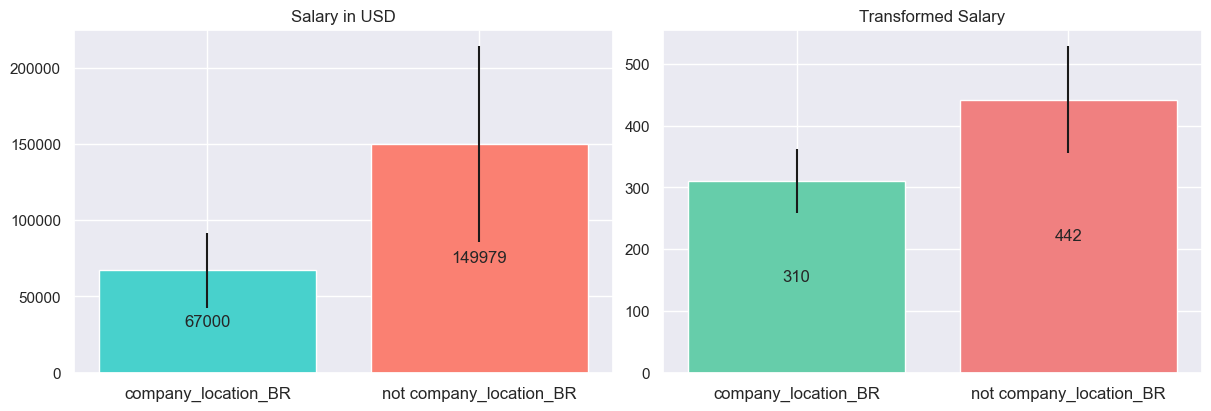

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_CA                                                   
0                          150039  64557  14045                442  88
1                          144387  59483    375                436  82

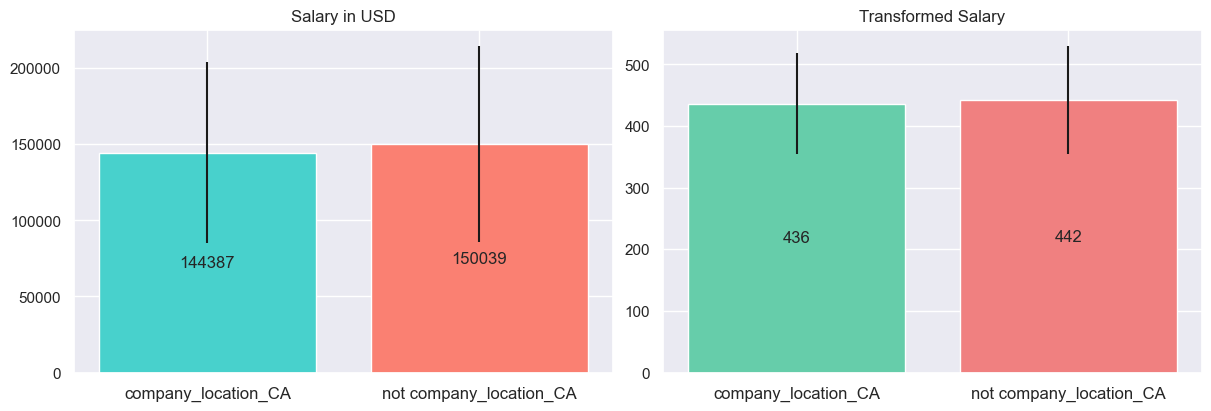

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_CH                                                    
0                          149907  64419  14412                442   87
1                          123182  88654      8                393  125

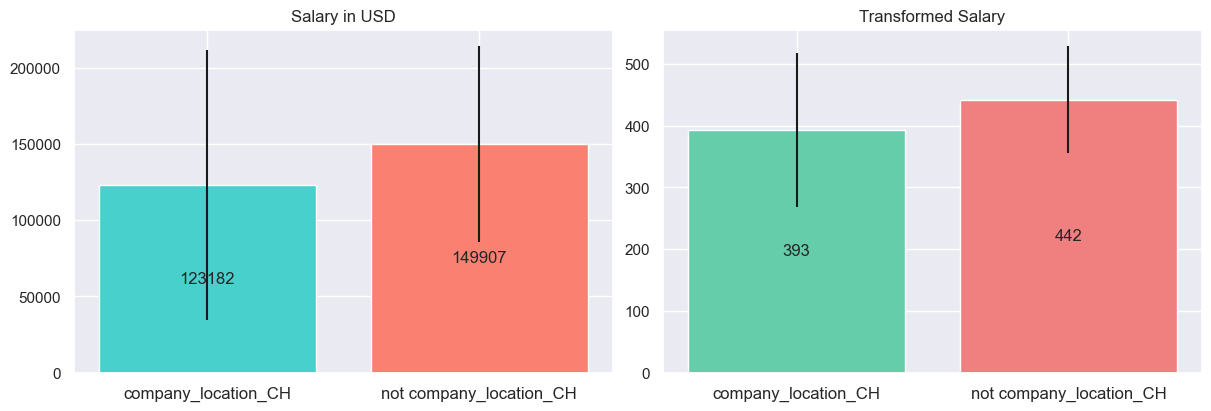

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_CO                                                   
0                          149971  64420  14404                442  87
1                           79115  30019     16                334  60

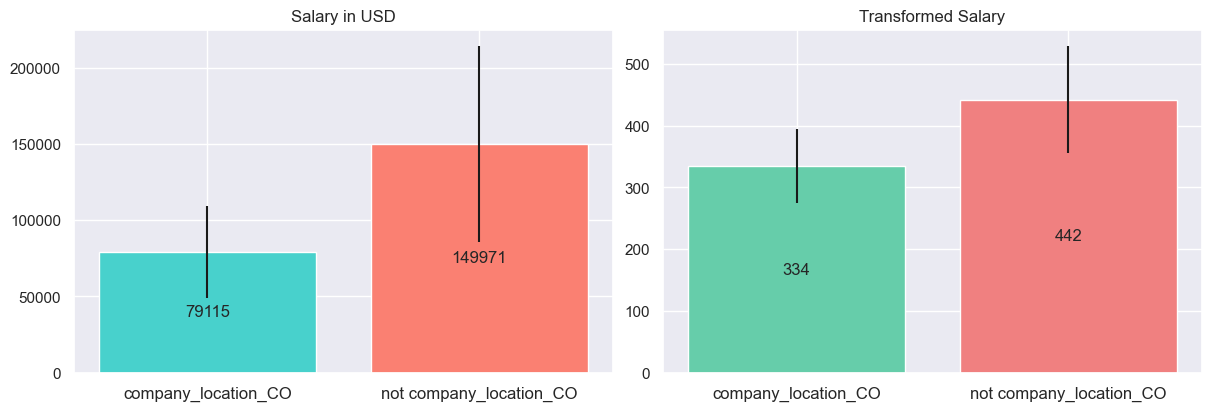

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_DE                                                   
0                          150245  64342  14328                442  87
1                           95050  54872     92                356  87

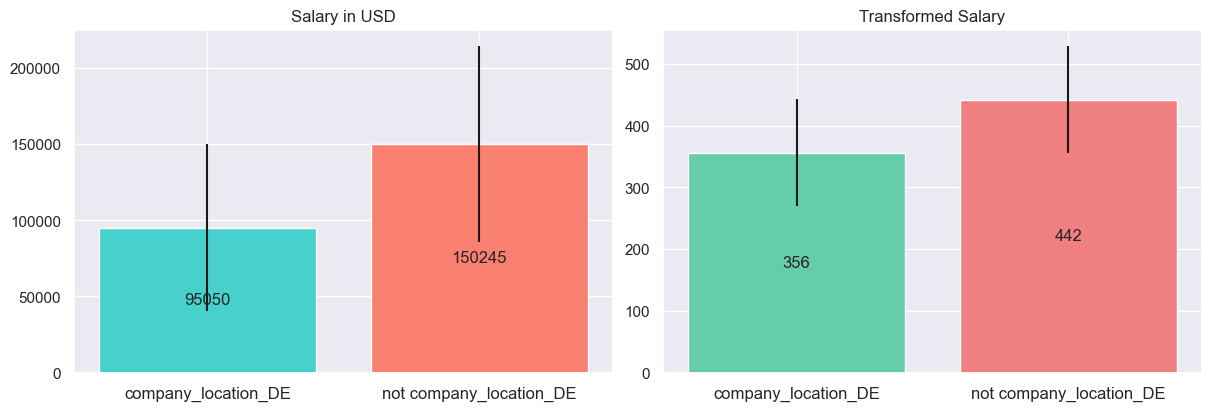

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_EE                                                   
0                          149973  64392  14409                442  87
1                           43941   8749     11                260  23

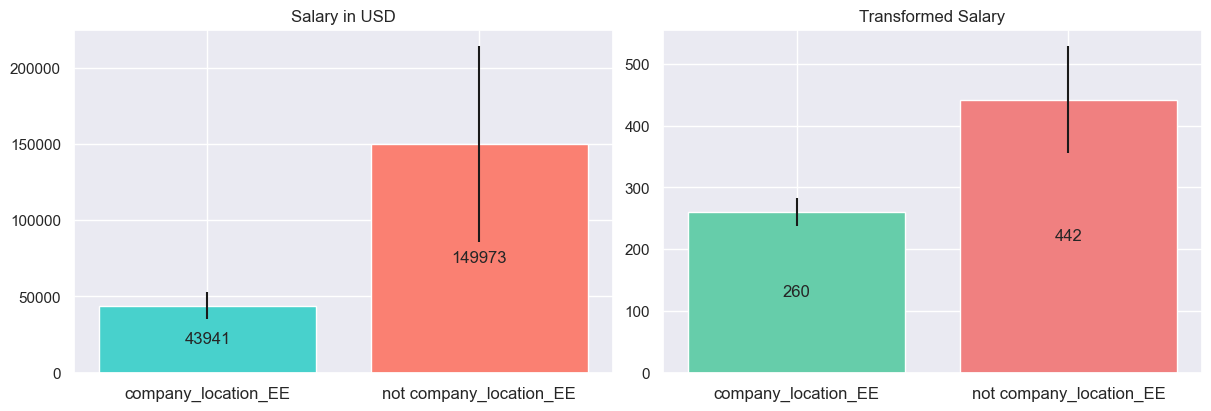

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_EG                                                    
0                          149901  64431  14407                442   87
1                          140869  70642     13                425  108

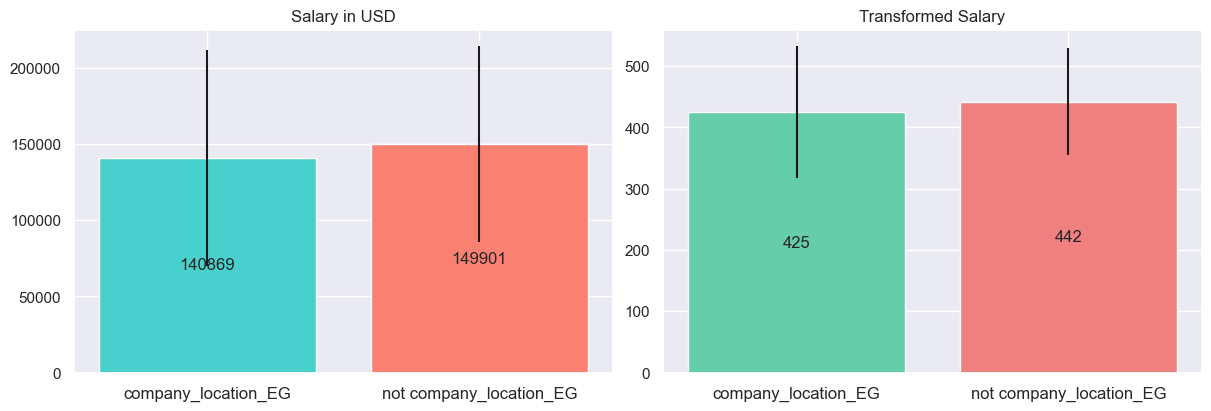

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_ES                                                   
0                          150712  64040  14294                443  86
1                           56932  34523    126                285  61

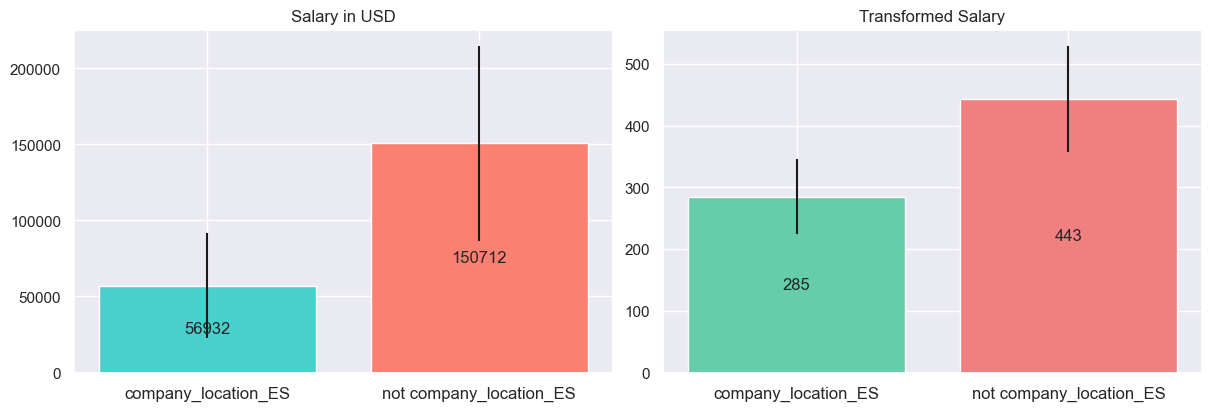

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_FR                                                   
0                          150158  64337  14361                442  87
1                           85337  55472     59                337  90

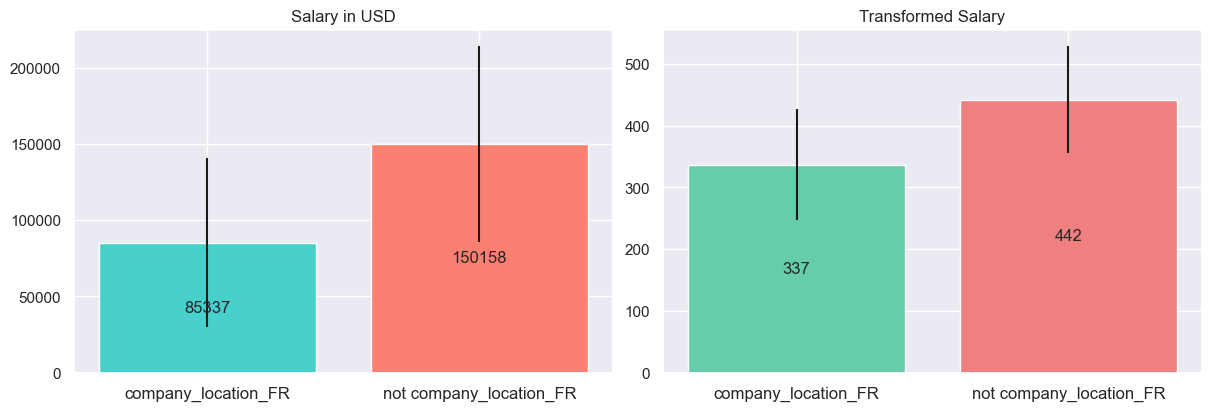

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_GB                                                   
0                          152425  63608  13778                446  85
1                           95534  57756    642                357  87

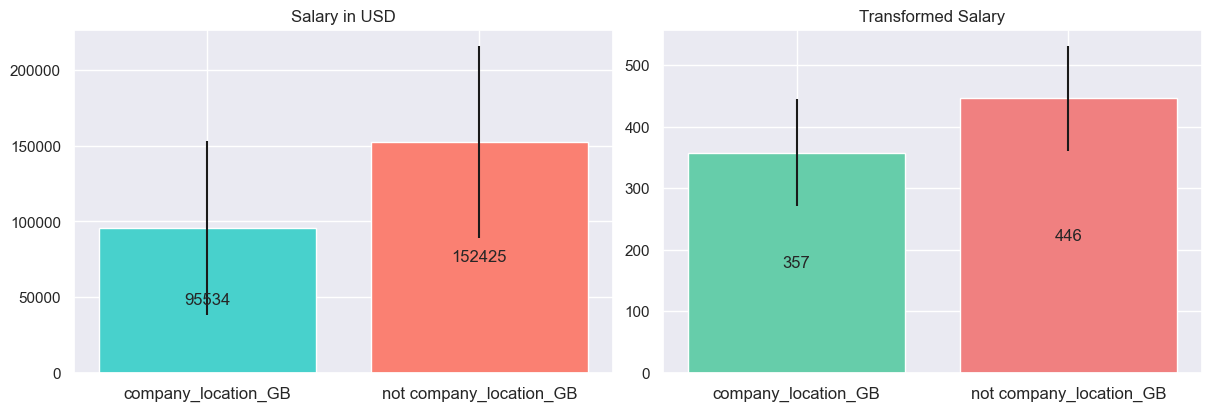

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_GR                                                   
0                          149987  64390  14406                442  87
1                           52260  21279     14                276  54

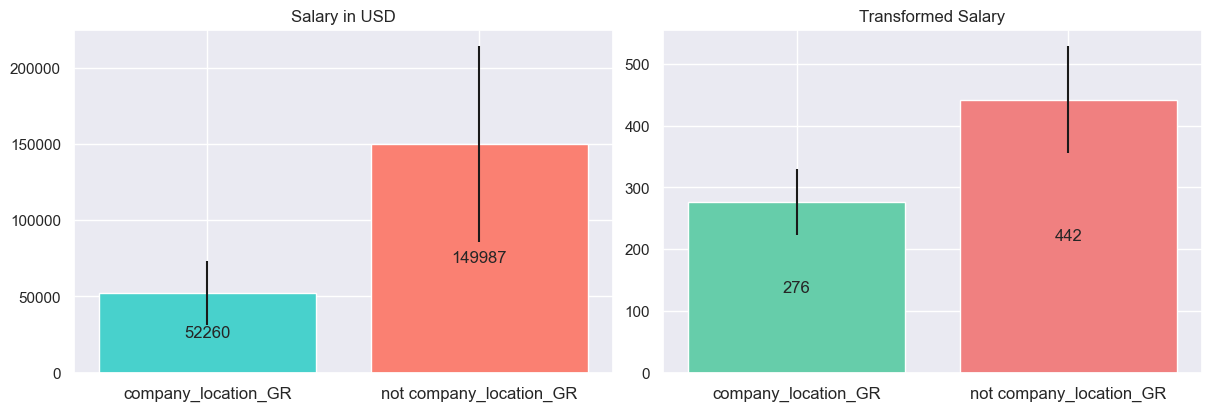

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IE                                                   
0                          149930  64441  14408                442  88
1                          104694  33896     12                381  52

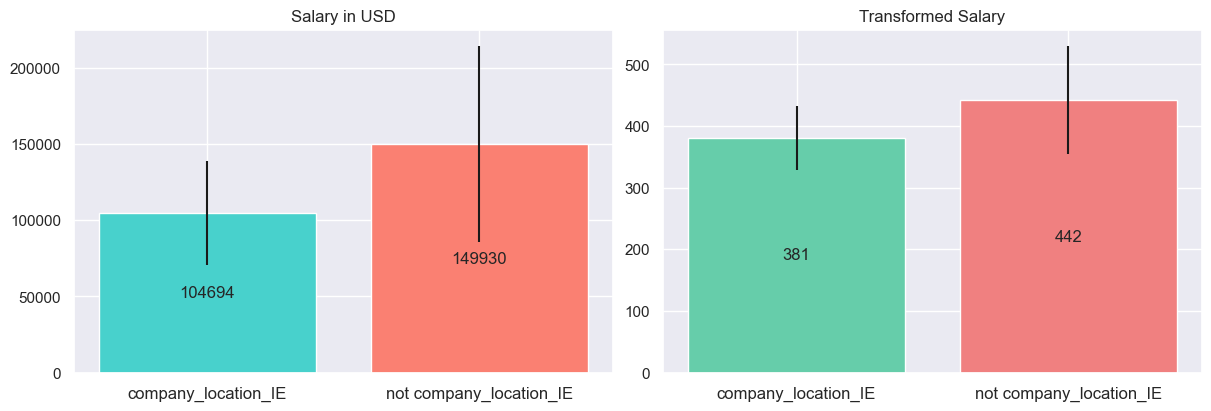

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IN                                                   
0                          150323  64162  14363                443  87
1                           41360  34229     57                239  77

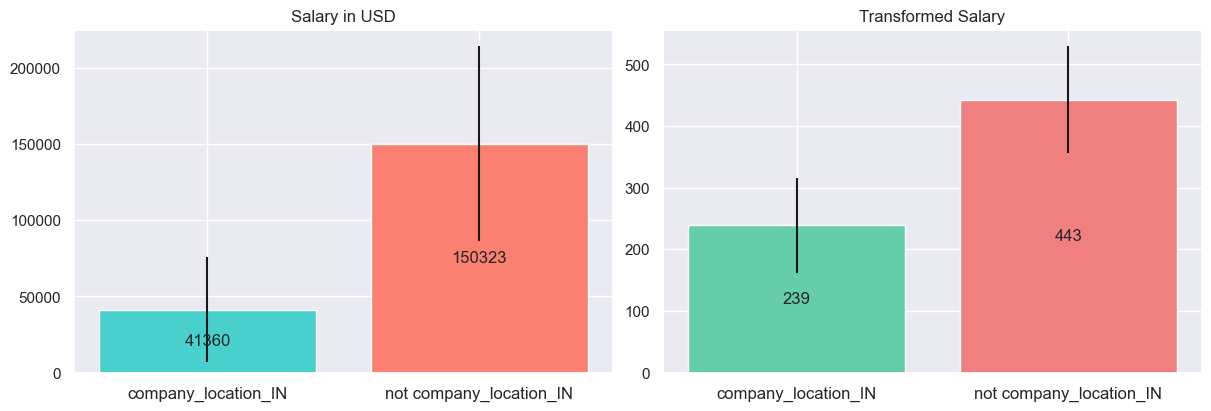

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_IT                                                   
0                          149990  64387  14406                442  87
1                           49600  18169     14                270  48

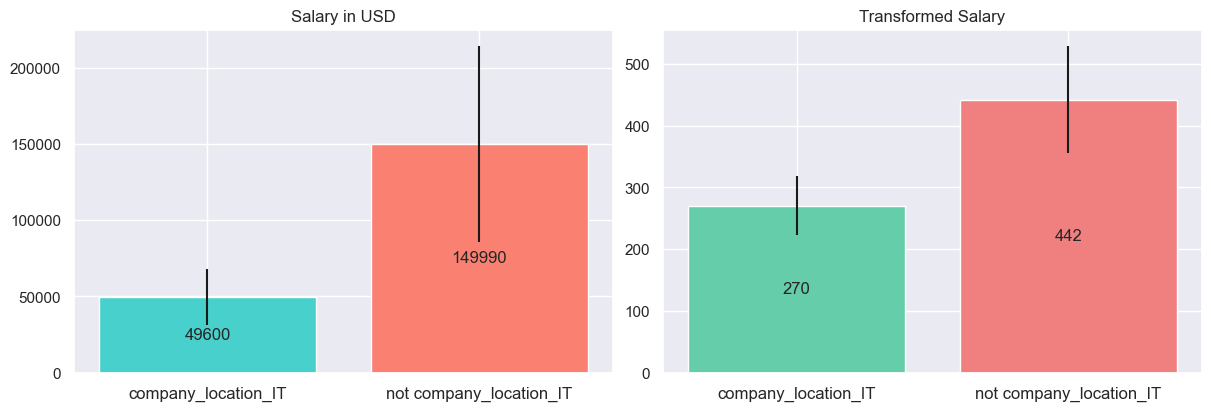

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_LT                                                   
0                          149983  64406  14404                442  87
1                           68553  29287     16                312  59

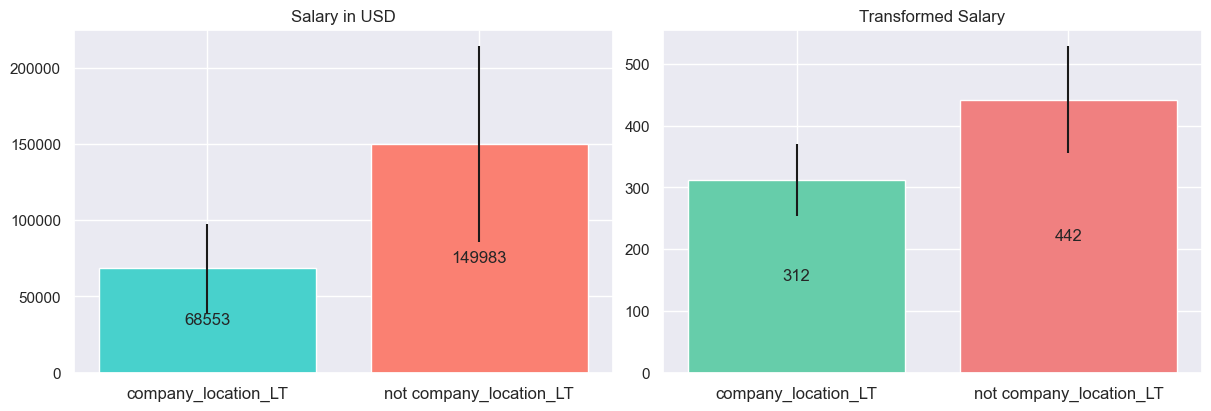

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_LV                                                   
0                          149985  64394  14406                442  87
1                           54734  19875     14                284  45

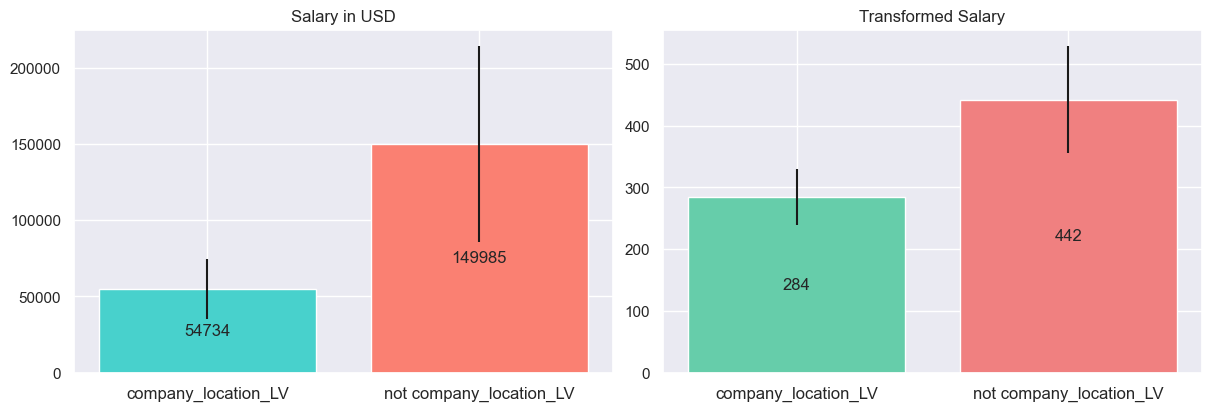

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_MX                                                    
0                          149949  64404  14407                442   87
1                           87007  70236     13                330  121

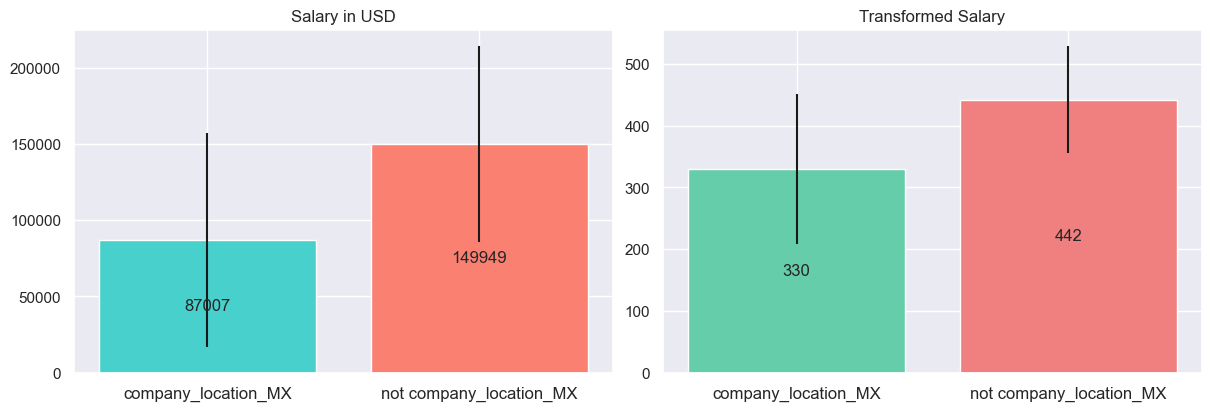

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NG                                                   
0                          149948  64403  14411                442  87
1                           60444  54127      9                283  95

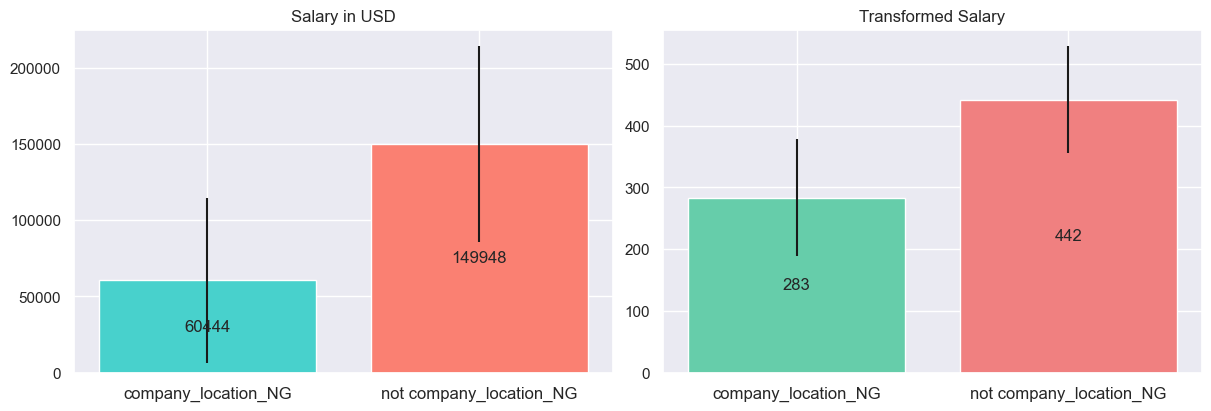

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NL                                                   
0                          150036  64402  14392                442  87
1                           76171  30171     28                327  60

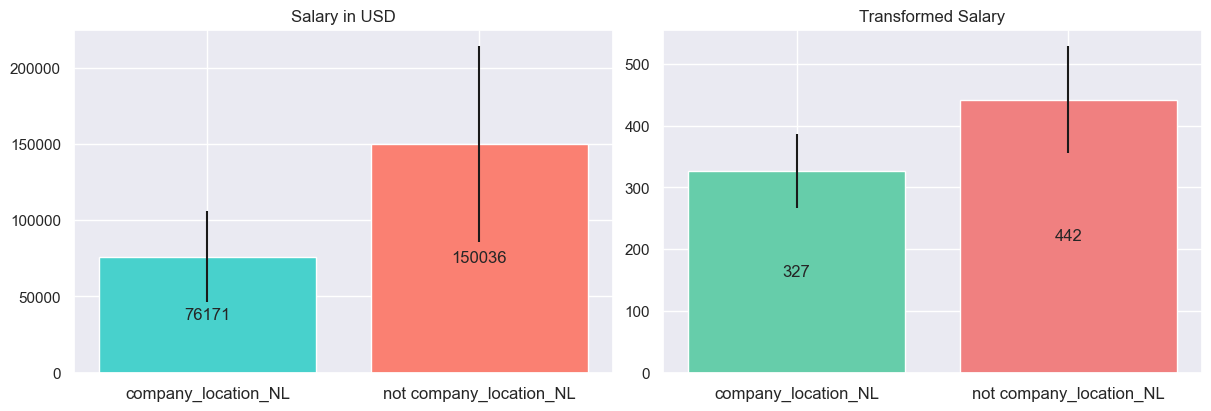

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_NZ                                                   
0                          149892  64443  14415                442  88
1                          152218  35137      5                453  45

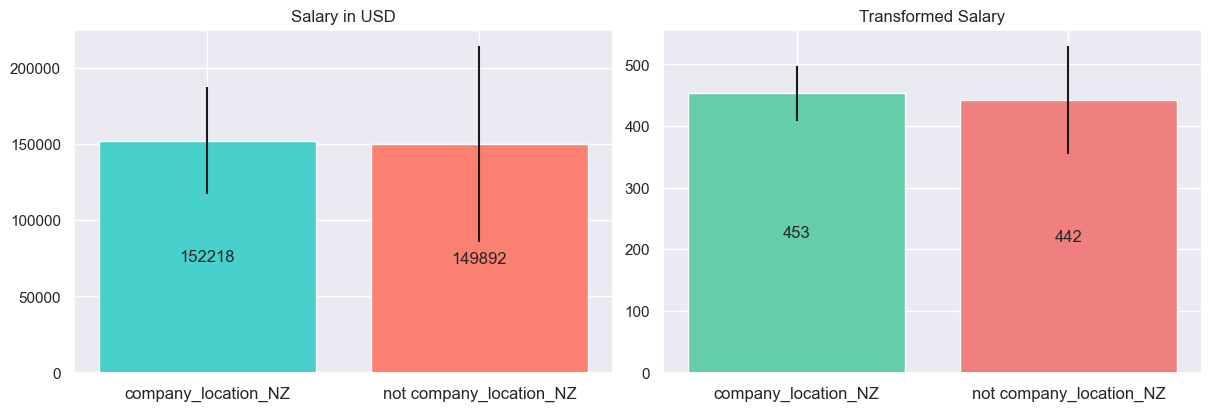

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_PH                                                   
0                          149925  64420  14415                442  87
1                           55720  27981      5                282  67

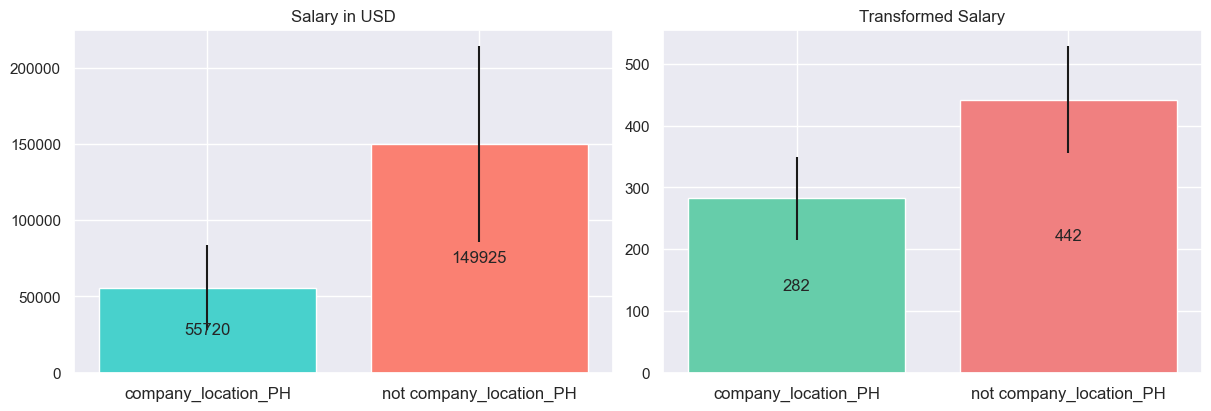

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_PL                                                   
0                          149949  64415  14407                442  87
1                           86787  56866     13                338  99

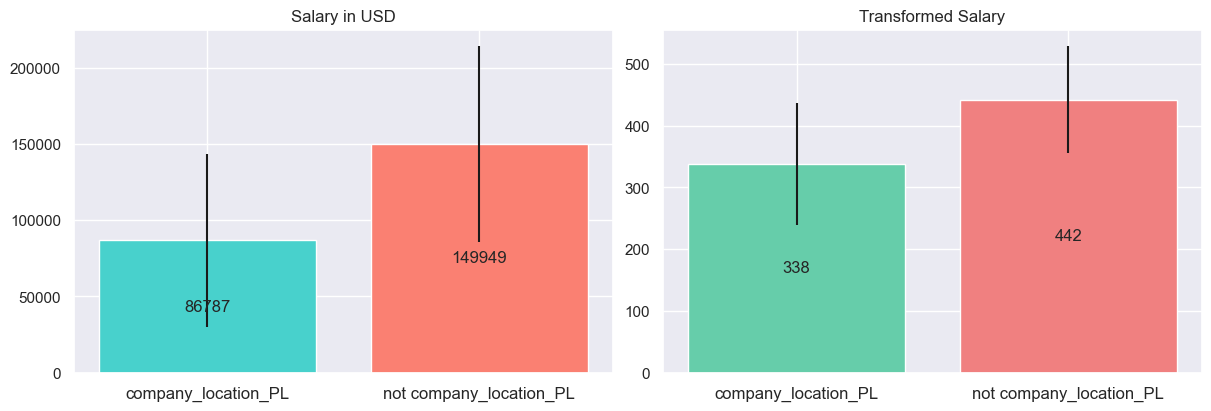

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_PT                                                   
0                          150078  64345  14393                442  87
1                           51115  22826     27                272  56

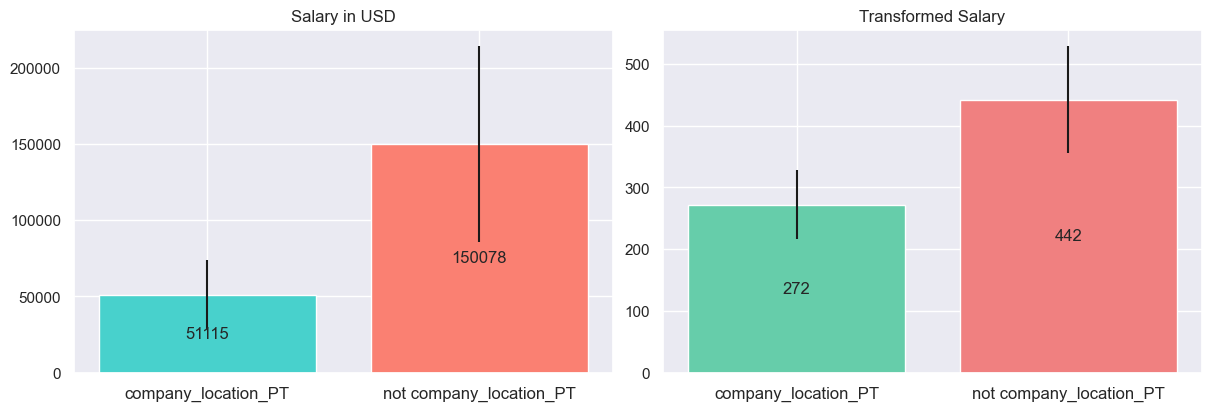

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_SI                                                   
0                          149931  64417  14414                442  87
1                           56186  28245      6                284  64

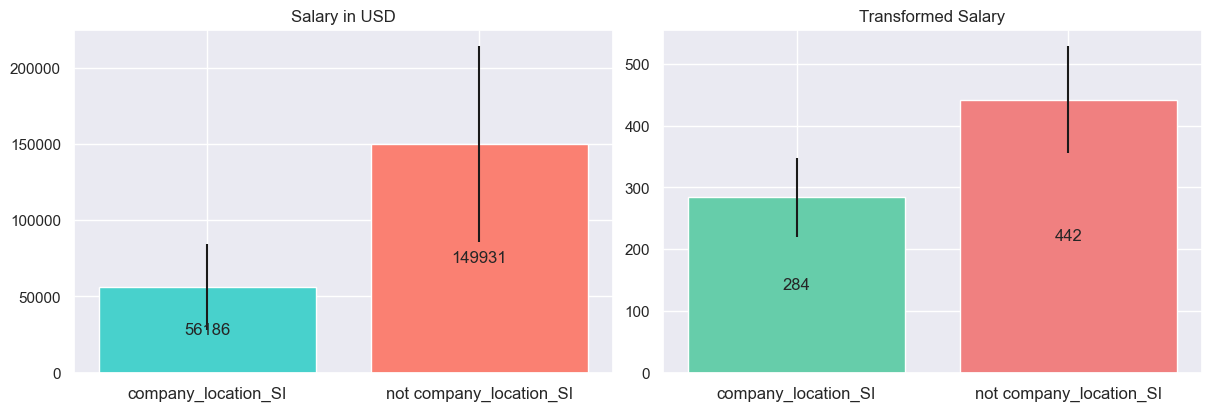

salary_in_usd               transformed_salary     
                             mean    std  count               mean  std
company_location_UA                                                    
0                          149923  64422  14410                442   87
1                          105600  70596     10                370  106

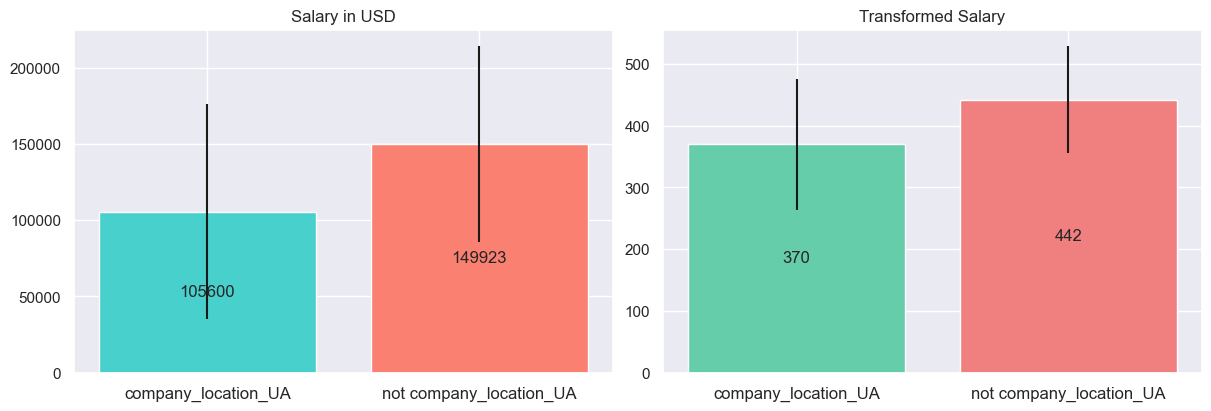

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_US                                                   
0                           98969  61870   1679                359  98
1                          156603  61709  12741                453  80

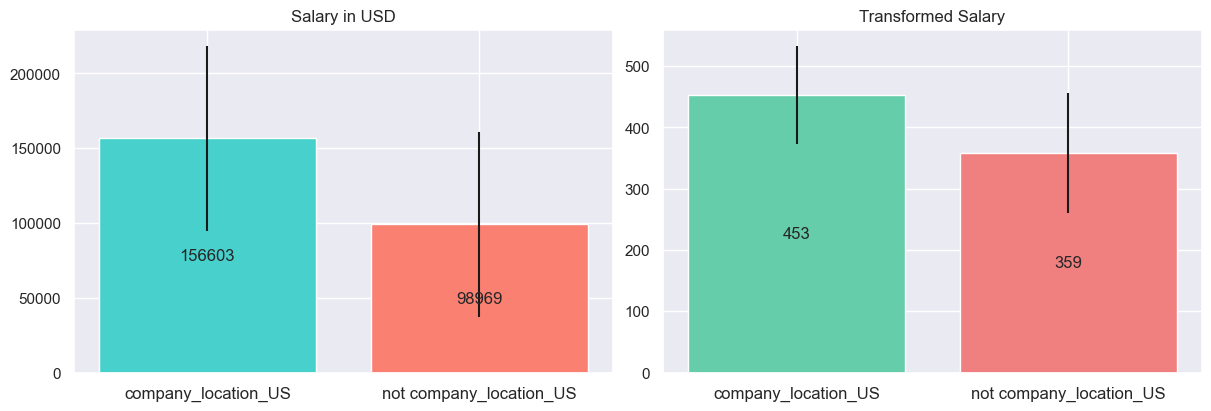

salary_in_usd               transformed_salary    
                             mean    std  count               mean std
company_location_ZA                                                   
0                          149982  64397  14406                442  87
1                           57308  24142     14                289  50

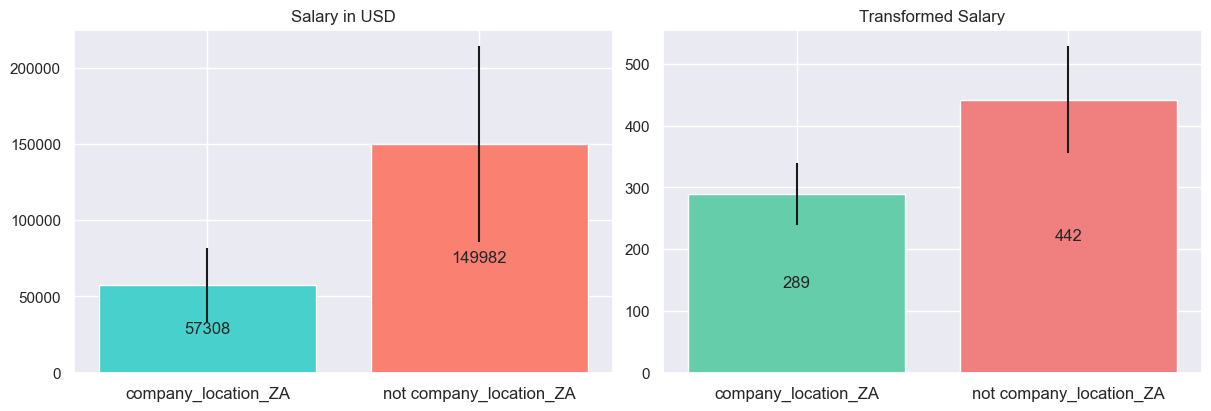

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_L                                                    
0                     150280  63829  13500                443   86
1                     144207  72547    920                429  106

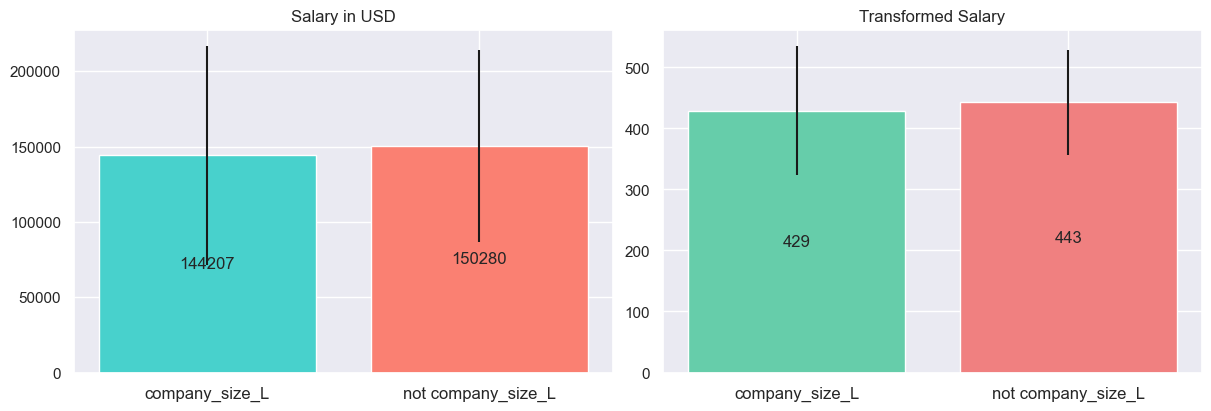

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_M                                                    
0                     137925  73233   1048                419  108
1                     150830  63601  13372                444   85

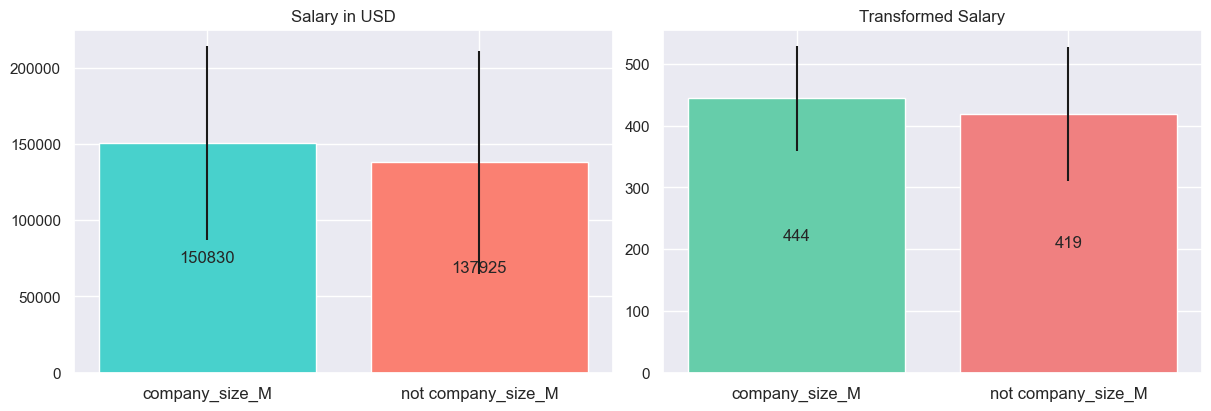

salary_in_usd               transformed_salary     
                        mean    std  count               mean  std
company_size_S                                                    
0                     150404  64233  14292                443   87
1                      92776  61553    128                347  100

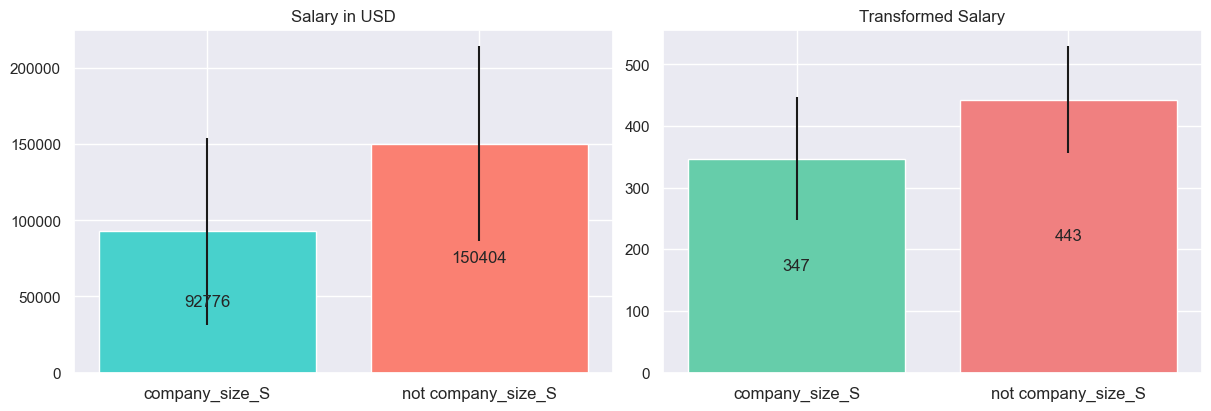

In [40]:
diffs = {}

aux = new_X.groupby('work_year')[['salary_in_usd', 'transformed_salary']].agg(['mean', 'std', 'count']).iloc[:,:5].astype(int)
display(aux)
for year in aux.index:
    diffs['work_year_' + str(year)] = aux.loc[year,('transformed_salary', 'mean')] - avg
    diffs['work_year_' + str(year)] = (diffs['work_year_' + str(year)], abs(diffs['work_year_' + str(year)])/aux.loc[year,('transformed_salary', 'std')])

for var in new_X.columns[1:-2]:
    aux = new_X.groupby(var)[['salary_in_usd', 'transformed_salary']].agg(['mean', 'std', 'count']).iloc[:,:5].astype(int)
    display(aux)
    diffs[var] = aux.loc[1,('transformed_salary', 'mean')] - avg
    diffs[var] = (diffs[var], abs(diffs[var])/aux.loc[1,('transformed_salary', 'std')])
    plotting(var)

In [41]:
diffs = pd.DataFrame(diffs, index=['differences', 'abs_z_score']).transpose()
diffs.sort_values('abs_z_score', ascending=False).head(30)

differences  abs_z_score
job_name_Insight        -175.43998     9.233683
employee_residence_EE   -182.43998     7.932173
company_location_EE     -182.43998     7.932173
salary_currency_PLN     -206.43998     5.579459
salary_currency_INR     -218.43998     4.121509
employee_residence_AT   -126.43998     4.078709
company_location_AT     -125.43998     4.046451
job_name_Associate      -128.43998     4.013749
company_location_IT     -172.43998     3.592500
employee_residence_LV   -158.43998     3.520888
company_location_LV     -158.43998     3.520888
company_location_AR     -124.43998     3.456666
employee_residence_AR   -140.43998     3.343809
employee_residence_GR   -168.43998     3.119259
company_location_GR     -166.43998     3.082222
employee_residence_ZA   -153.43998     3.068800
company_location_ZA     -153.43998     3.068800
company_location_PT     -170.43998     3.043571
employee_residence_PH   -169.43998     2.921379
employment_type_FL      -177.43998     2.772500
company_location_IN     -203.43998     2.642078
employee_residence_PT   -165.43998     2.626031
company_location_ES     -157.43998     2.580983
company_location_BR     -132.43998     2.546923
employee_residence_IT   -163.43998     2.476363
employee_residence_SI   -158.43998     2.475625
company_location_SI     -158.43998     2.475625
company_location_PH     -160.43998     2.394627
employee_residence_ES   -154.43998     2.376000
salary_currency_EUR     -141.43998     2.281290

In [42]:
diffs[diffs.differences > 0].sort_values('abs_z_score', ascending=False)

differences  abs_z_score
job_name_Director           82.56002     1.032000
job_name_Head               78.56002     0.770196
job_name_Decision           29.56002     0.720976
experience_level_EX         57.56002     0.685238
job_name_Applied            49.56002     0.652106
job_name_Machine            47.56002     0.580000
job_name_Prompt             39.56002     0.507180
job_name_Infrastructure     40.56002     0.494634
job_name_Architect          26.56002     0.340513
job_name_Research           32.56002     0.325600
job_name_Software           32.56002     0.301482
job_name_Deep               36.56002     0.287874
job_name_Robotics           22.56002     0.285570
experience_level_SE         19.56002     0.250769
job_name_Principal          23.56002     0.235600
company_location_NZ         10.56002     0.234667
employee_residence_NZ       10.56002     0.234667
job_name_Vision             25.56002     0.216610
job_name_Scientist          17.56002     0.209048
job_name_Engineer           15.56002     0.183059
job_name_AI                 18.56002     0.165714
employee_residence_US       10.56002     0.132000
company_location_US         10.56002     0.132000
job_name_Cloud               8.56002     0.129697
salary_currency_USD          9.56002     0.118025
job_name_Analytics           5.56002     0.075135
work_year_2023               5.56002     0.065412
job_name_Product             3.56002     0.048108
remote_ratio_On_Site         3.56002     0.040920
company_size_M               1.56002     0.018353
job_name_Lead                0.56002     0.004912